In [0]:
from copy import deepcopy
from time import time
from itertools import zip_longest

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import scipy.stats as stats
from scipy.optimize import minimize, root_scalar, differential_evolution

from sklearn.cluster import DBSCAN, KMeans, MeanShift
from sklearn.neighbors import NearestNeighbors as nn
from sklearn.metrics import (pairwise_distances, 
                             calinski_harabaz_score, silhouette_score, davies_bouldin_score)
from sklearn.metrics.pairwise import paired_distances

import sklearn

### DBSCAN

In [0]:
def reader(file_name, skip_lines=0, commos2points=False):
    '''
    read only 3 coords
    return np.array

    '''

    list_obj = list()
    with open(file_name, 'r') as fd_file:
        for line in fd_file:
            if skip_lines:
                skip_lines -= 1
                continue
            if commos2points:
                line = line.replace(',', '.')
            line = line.split()
            coords = np.zeros(shape=(3,))
            coords[0] = float(line[0])
            coords[1] = float(line[1])
            coords[2] = float(line[2])
            list_obj.append(coords)
    return np.array(list_obj)

def get_cone(array, ra, dec, offset=1.5):
    mask = ((array[:,0] > ra - offset) & (array[:, 0] < ra + offset) &
            (array[:,1] > dec - offset) & (array[:,1] < dec + offset))
    return array[mask]


def left_right_regions(points_ra_dec):
    array = points_ra_dec
    mask_right = (((array[:,0] < 60) | (array[:,0] > 306)) &
                  (array[:, 1] > -12) & (array[:, 1] < 37))
    mask_left = ((array[:,0] > 102) & (array[:,0] < 270) & 
                 (array[:,1] > -4) & (array[:,1] < 69))
    
    return array[mask_left], array[mask_right]

def do_scan(points_xyz, n_neighbors, eps, verbose=False):
    num_clusters_inter = 4
    
    dbscan = DBSCAN(eps=eps, min_samples=n_neighbors+1).fit(points_xyz)
    cen_dbscan = points_xyz[dbscan.labels_==0].mean(axis=0)

    clusters = list()
    cen_clusters = list()

    labels, count_labels = np.unique(dbscan.labels_, return_counts=True)
    most_freq_labels = labels[np.argsort(count_labels)[::-1][:num_clusters_inter]]

    for lab in most_freq_labels:
        if lab == -1:
            continue
        clusters.append(points_xyz[dbscan.labels_==lab])    
        cen_clusters.append(clusters[-1].mean(axis=0))
        if verbose:
            print('for label', lab, 'there are', clusters[-1].shape[0], 'galaxies')
    
    noize = points_xyz[dbscan.labels_==-1]
    if verbose:
        print('noize num : ', noize.shape)

    return clusters, cen_clusters, noize, dbscan.labels_


def to_ra_dec_redshift(points_xyz):
    if points_xyz.shape == (3,):
        points_xyz = points_xyz.reshape((1,3)) 
    redshift = np.linalg.norm(points_xyz, axis=1)
    ra = np.arctan(points_xyz[:,1]/points_xyz[:,0]) * 180.0 / np.pi
    dec = (90.0 - np.arccos(
        points_xyz[:,2]/np.linalg.norm(points_xyz, axis=1)) * 180.0 / np.pi)
    
    mask_2_3 = (points_xyz[:,0] < 0)
    mask_4 = ((points_xyz[:,0] > 0) & (points_xyz[:,1] < 0))
    
    ra[mask_2_3] = 180 + ra[mask_2_3]
    ra[mask_4] = 360 + ra[mask_4]
    
    points_sphere = np.zeros_like(points_xyz)
    points_sphere[:,0] = ra
    points_sphere[:,1] = dec
    points_sphere[:,2] = redshift
    

    return points_sphere


def to_xyz(polar_points):
    points = polar_points
    if points.shape == (3,):
        points = points.reshape((1,3))
    cos_dec = np.cos(points[:,1]*np.pi/180.0)
    sin_dec = np.sin(points[:,1]*np.pi/180.0)
    
    cos_ra = np.cos(points[:,0]*np.pi/180.0)
    sin_ra = np.sin(points[:,0]*np.pi/180.0)
    
    r = points[:,2]
    points_xyz = np.zeros_like(points)
    points_xyz[:,0] = r * cos_dec * cos_ra
    points_xyz[:,1] = r * cos_dec * sin_ra
    points_xyz[:,2] = r * sin_dec 
    return points_xyz

def func_distr(points, n_neighbors):
    #calculate dist to n_neighbor and indecies
    nbrs = nn(n_neighbors=n_neighbors+1, algorithm='ball_tree').fit(points)
    dist, ind = nbrs.kneighbors(points)
    dist_to_nneighbor = dist[:,n_neighbors]   
    return dist, ind

def shuffle_coords(arr_clusters):
    list_coords_shuffled = list()
    for coord in arr_clusters.T:
        coord_to_shuffle = deepcopy(coord)
        np.random.shuffle(coord_to_shuffle)
        list_coords_shuffled.append(coord_to_shuffle)
    
    arr_clusters_shuffled = np.array(list_coords_shuffled).T
    return arr_clusters_shuffled


def get_hist(arr_clusters, num_bins, right_edge):
    pair_dist_clusters = pairwise_distances(arr_clusters)
    not_zero_pair = np.triu(pair_dist_clusters)
    not_zero_pair = not_zero_pair[not_zero_pair!=0]
    arr_clusters.shape

    #to_del = np.unique(np.argwhere((pair_dist_clusters<2) & (pair_dist_clusters>0)).flatten())
    #arr_clusters = np.delete(arr_clusters, to_del, 0)

    n1 = np.histogram(not_zero_pair, num_bins, [0, right_edge])
    return n1

'''
def get_hist(arr_clusters, num_bins, right_edge):
    r = nn(n_neighbors=9).fit(arr_clusters)
    m = r.kneighbors(arr_clusters)[0]
    m = m.ravel()
    m = m[m!=0]
    n1 = np.histogram(m, num_bins, [0, right_edge])
    return n1
'''    
    
    


'\ndef get_hist(arr_clusters, num_bins, right_edge):\n    r = nn(n_neighbors=9).fit(arr_clusters)\n    m = r.kneighbors(arr_clusters)[0]\n    m = m.ravel()\n    m = m[m!=0]\n    n1 = np.histogram(m, num_bins, [0, right_edge])\n    return n1\n'

In [0]:
class distr_red_shift(stats.rv_continuous):
    max_prob_distr = 1.02
    max_val_distr = 0.3
    
    def __init__(self, min_val=0., max_val=max_val_distr):
        super().__init__()
        self.min_val = min_val
        self.max_val = max_val
    
    def _rvs(self):
        size = self._size[0]
        min_prob = self.cdf(self.min_val)
        max_prob = self.cdf(self.max_val)
        
        list_values = list()
        i = 0
        while i < size-1:
            prob = np.random.rand() * (max_prob - min_prob) + min_prob
            sol_eq = root_scalar(
                self.__make_equation_cdf, args=prob, bracket=[0, 0.3], method='brentq')
            if(sol_eq.converged):
                list_values.append(sol_eq.root)
                i+=1
        return np.array(list_values)        
    
    
    def _pdf(self, x):
        res = np.zeros_like(x)
        res[x <= 0.075] = 93.*x[x <= 0.075]
        res[(0.075 < x) & (x <= 0.09)] = 7
        res[(0.09 < x) & (x <= 0.14)]  = 5.8
        res[(0.14 < x) & (x <= 0.21)] = -50.*x[(0.14 < x) & (x <= 0.21)] + 12.
        res[(0.21 < x) & (x <= 0.3)] = 1.5
        return res
    
    def _cdf(self, x):
        res = np.zeros_like(x)
        res[x <= 0.075] = 46.5*x[x <= 0.075]**2
        res[(0.075 < x) & (x <= 0.09)] = 7.*x[(0.075 < x) & (x <= 0.09)] - 0.2625 
        res[(0.09 < x) & (x <= 0.14)] = 5.8*x[(0.09 < x) & (x <= 0.14)] - 0.1545 #0.522 + (0.2625 + 0.105)
        res[(0.14 < x) & (x <= 0.21)] = (-25.*x[(0.14 < x) & (x <= 0.21)]**2 
                                         + 12.*x[(0.14 < x) & (x <= 0.21)] - 0.5325)
        res[(0.21 < x) & (x <= 0.3)] = 1.5*x[(0.21 < x) & (x <= 0.3)] + 0.57
        res[x >= 0.3] = 1.02
        return res
    
    def __cdf_for_one(self, x):
        if x < 0:
            res = 0
        if x <= 0.075:
            res = 46.5*x**2
        if 0.075 < x <= 0.09:
            res = 7.*x - 0.2625 
        if 0.09 < x <= 0.14:
            res = 5.8 * x - 0.522 + (0.2625 + 0.105)
        if 0.14 < x <= 0.21:
            res = -25.*x**2 + 12.*x - 0.5325
        if 0.21 < x <= 0.3:
            res =  1.5*x + 0.57
        if x > 0.3:
            res = 1.02
        return res    
    
    def __make_equation_cdf(self, x, y):
        return self.__cdf_for_one(x) - y
    


In [0]:
a = distr_red_shift()

In [0]:
a.pdf(0.1)

5.8

In [0]:
def plot_distinguish(n1, n2):
    distinguish = n1[0] - n2[0]
    plt.errorbar(n2[1][1:], 
             np.zeros_like(n2[1][1:]), 
             yerr=[np.zeros_like(distinguish), distinguish], alpha=1)
    
def uniform_distr(points_xyz, in_polar):
    if in_polar:
        points = to_ra_dec_redshift(points_xyz)
    else:
        points = points_xyz
    new_coords = np.zeros_like(points)
    
    for i, coord in enumerate(points.T):
        max_ = np.max(coord)
        min_ = np.min(coord)
        if i==2 and in_polar:
            new_coords[:,i] = distr_red_shift(min_val=min_, max_val=max_).rvs(size=coord.shape[0]+1)
            continue   
        new_coord = np.random.rand(*coord.shape)*(max_ - min_) + min_
        new_coords[:,i] = new_coord
    if in_polar:
        return to_xyz(new_coords)
    return new_coords
        
def plot_results(array_clusters_xyz, 
                 num_bins, right_edge, 
                 mod_mix, 
                 save=False, name='all_diagrams'):
    '''
    mod_mix:
    1: mix red_shift
    2: mix all polar coords
    3: mix all xyz coords
    4: uniform polar coords
    5: uniform xyz coords
    '''
    
    mix_array_clusters_xyz = None
    mix_array_clusters_polar = None
    array_clusters_polar = to_ra_dec_redshift(array_clusters_xyz)
    
    
    if mod_mix==1:
        array_clusters_polar_mix = deepcopy(array_clusters_polar)
        array_clusters_polar_mix[:,2] = shuffle_coords(
            array_clusters_polar_mix[:,2].reshape(-1, 1)).reshape(-1,)

        mix_array_clusters_xyz = to_xyz(array_clusters_polar_mix)
    elif mod_mix==2:
        mix_array_clusters_xyz = to_xyz(shuffle_coords(array_clusters_polar))
    elif mod_mix==3:
        mix_array_clusters_xyz = shuffle_coords(array_clusters_xyz)
    elif mod_mix==4:
        mix_array_clusters_xyz = uniform_distr(array_clusters_xyz, in_polar=True)
    elif mod_mix==5:
        mix_array_clusters_xyz = uniform_distr(array_clusters_xyz, in_polar=False)
    
    mix_array_clusters_polar = to_ra_dec_redshift(mix_array_clusters_xyz)
    
    n1 = get_hist(array_clusters_xyz, num_bins, right_edge)           
    n2 = get_hist(mix_array_clusters_xyz, num_bins, right_edge)
    fig = plt.figure(figsize=(8, 20))
    plt.subplot(511)
    plt.scatter(n1[1][1:], n1[0], s=2)
    plt.scatter(n2[1][1:], n2[0], s=2, alpha=0.8)
    plt.xlim([0, right_edge])
    #plt.xticks(np.linspace(0, right_edge, 11))
    num_bao = round(right_edge/0.035)
    plt.xticks(np.linspace(0, num_bao*0.035, num_bao+1))
    plt.grid(True)
    
    plt.subplot(512)
    plot_distinguish(n1, n2)
    plt.xlim([0, right_edge])
    plt.xticks(np.linspace(0, num_bao*0.035, num_bao+1))
    plt.grid(True)
    
    num_bins = 50
    plt.subplot(513)
    plt.title('ra')
    plt.hist(array_clusters_polar[:,0], num_bins)
    plt.hist(mix_array_clusters_polar[:,0], num_bins, alpha=0.8)
    plt.grid(True)
    
    plt.subplot(514)
    plt.title('dec')
    plt.hist(array_clusters_polar[:,1], num_bins)
    plt.hist(mix_array_clusters_polar[:,1], num_bins, alpha=0.8)
    plt.grid(True)
    
    plt.subplot(515)
    plt.title('redshift')
    plt.hist(array_clusters_polar[:,2], num_bins)
    plt.hist(mix_array_clusters_polar[:,2], num_bins, alpha=0.8)
    plt.grid(True)
    
    if save:
        name = name + '.png'
        fig.savefig(name)

In [0]:
def centers_by_labels(points_xyz, labels):
    all_labels = np.unique(labels)
    cen_clusters = list()
    for lab in all_labels[1:]: #don't need noize
        cen_clusters.append(points_xyz[labels==lab].mean(axis=0))
        
    return np.array(cen_clusters)

def get_squared_func_coefs(
    expected, offset, value_left, value_right):
    
    A = np.array([[expected**2, expected, 1], 
                  [(expected-offset)**2, (expected-offset), 1], 
                  [(expected+offset)**2, (expected+offset), 1]])
   
    b = np.array([0, value_left, value_right])
    return(np.linalg.solve(A, b))
    

def squared_func(x, coefs):
    return x**2*coefs[0] + x*coefs[1] + coefs[2]

def get_subareas(points_sphere, num_subareas):
    if num_subareas==1:
        return to_xyz(points_sphere)
    elif num_subareas == 4:
        ra_mask = (points_sphere[:,0] < 189.675)
        z_mask =  (points_sphere[:,2] < 0.11)
        
        subareas = np.array([
            to_xyz(points_sphere[ra_mask & z_mask]),
            to_xyz(points_sphere[~ra_mask & z_mask]),
            to_xyz(points_sphere[ra_mask & ~z_mask]),
            to_xyz(points_sphere[~ra_mask & ~z_mask])
        ])
        
    elif num_subareas == 6:
        ra_mask = (points_sphere[:,0] < 189.675)
        z_01 = (points_sphere[:,2] < 0.1)
        z_02 = ((points_sphere[:,2] < 0.2) & (points_sphere[:,2] > 0.1))
        z_03 = ((points_sphere[:,2] < 0.3) & (points_sphere[:,2] > 0.2))
        
        subareas = np.array([
            to_xyz(points_sphere[ra_mask & z_01]),
            to_xyz(points_sphere[~ra_mask & z_01]),
            to_xyz(points_sphere[ra_mask & z_02]),
            to_xyz(points_sphere[~ra_mask & z_02]),
            to_xyz(points_sphere[ra_mask & z_03]),
            to_xyz(points_sphere[~ra_mask & z_03]),
        ])
    
     
    elif num_subareas == 5:
        ra_mask = (points_sphere[:,0] < 189.675)
        z_01 = (points_sphere[:,2] < 0.1)
        z_02 = ((points_sphere[:,2] < 0.2) & (points_sphere[:,2] > 0.1))
        z_03 = ((points_sphere[:,2] < 0.3) & (points_sphere[:,2] > 0.2))
        
        subareas = np.array([
            to_xyz(points_sphere[ra_mask & z_01]),
            to_xyz(points_sphere[~ra_mask & z_01]),
            to_xyz(points_sphere[ra_mask & z_02]),
            to_xyz(points_sphere[~ra_mask & z_02]),
            to_xyz(points_sphere[z_03])
        ])
    return subareas
    
    
    
    
def loss_dbscan(eps, num_neighbors, 
                points_xyz, 
                c_num_galaxies_in_1, c_num_clusters, 
                threshold_small, throw_huge=True,
                verbose=True):
    
    start_time = time()
    dbscan = DBSCAN(eps=eps, min_samples=num_neighbors).fit(points_xyz)
    time_impl = time() - start_time
    
    labels_no_small, num_dep = small_to_noize(dbscan.labels_, threshold_small)
    if throw_huge:
        labels_ = huge_to_noize(labels_no_small, 3, 1500)
    else:
        labels_ = labels_no_small
    
    res = np.unique(labels_, return_counts=True)
    num_in_clusters = res[1][1:]
    num_clusters = len(res[0])-1
    
    loss_noize = 0 #(np.abs((num_in_clusters[0] / points_xyz.shape[0])-0.25)*50)**2
    
    if num_clusters == 0:
        loss_num_in_cl = 5000000.
        loss_num_clusters = 5000000.
    else:
        loss_num_in_cl = squared_func(num_in_clusters, c_num_galaxies_in_1).mean()
        loss_num_clusters = squared_func(num_clusters, c_num_clusters).mean()
        
    if time_impl < 5.*60:
        loss_time = 0
    else:
        loss_time = np.exp(np.abs(time_impl - 14.*60))
    
    
    
    loss = loss_num_in_cl + loss_num_clusters + loss_time + loss_noize
    
    if verbose:
        print('eps = {0:.5f}  num_neighbors = {1}'.format(eps, num_neighbors))
        
        print('time:', time_impl)
        
        print(loss_num_in_cl, 
              loss_num_clusters, 
              loss_noize, '\n')
        
        print('num clusters =', num_clusters, 
              'num without dropping =', num_dep+num_clusters)
        
        print(loss)
        
        print('------------------------------------------\n')
              
    return loss

def loss_func(args_alg, *args):
      
    points_xyz = args[0]
    c_num_galaxies_in_1 = args[1]
    c_num_clusters = args[2]
    threshold_small = args[3]
    throw_huge = args[4]
    verbose = args[5]
    
    eps=args_alg[0]
    num_neighbors=round(args_alg[1])

    return loss_dbscan(
        eps, num_neighbors, points_xyz,
        c_num_galaxies_in_1, c_num_clusters, 
        threshold_small, throw_huge, verbose)  
                
def apply_dbscan(points_xyz, eps, num_neighbors):
    '''
    return: (labels, num of uniq labels)
    '''
    dbscan = DBSCAN(eps=eps, min_samples=num_neighbors).fit(points_xyz)
    uniq = np.unique(dbscan.labels_, return_counts=True)
    return [dbscan.labels_, uniq[1]]
    




def eval_dif_evol(xyz_subareas, result):
    labels_list = list()
    num_in_clusters_list = list()
    for xyz_subarea, res in zip_longest(xyz_subareas, result):
        labels, num_in_cl = apply_dbscan(xyz_subarea, res.x[0], round(res.x[1])) 
        labels_list.append(labels)
        num_in_clusters_list.append(num_in_cl)
    
    
    return labels_list, num_in_clusters_list
  



In [0]:
all_gal = reader('gdrive/My Drive/data/0_03_Space.txt')
all_gal = all_gal[all_gal[:,2]>10e-4]
left_area, right_area = left_right_regions(all_gal)
xyz_subareas = get_subareas(left_area, 4)

In [0]:
def small_to_noize(labels, small_number):
    lab, counts = np.unique(labels, return_counts=True)
    mask_small = (counts < small_number)
    small_num_labels = lab[mask_small]
    new_labels = deepcopy(labels)
    new_labels[np.in1d(labels, small_num_labels)] = -1    
    
    return new_labels, len(small_num_labels)
        
def detect_huge_clusters(labels, num_hugest, threshold):
    lab, counts = np.unique(labels, return_counts=True)
    num_hugest = np.argsort(counts)[-2:-num_hugest-2:-1]
    
    lab_hugest = lab[num_hugest]
    counts_hugest = counts[num_hugest]
    list_hugest = list()
    
    #print(counts_hugest, num_hugest)
    
    for i, counts_cur in zip_longest(lab_hugest, counts_hugest):
        if counts_cur < threshold:
            break
        list_hugest.append(i)
    
    return np.array(list_hugest)
    
    
    
def huge_to_noize(labels, num_hugest, threshold):
    new_labels = deepcopy(labels)
    new_labels[np.in1d(labels, detect_huge_clusters(labels, num_hugest, threshold))] = -1    
        
    return new_labels
    



In [0]:
def dif_evol_on_subareas(xyz_subareas, num_galaxies_at_all, 
                         fine_num_galaxies_in1cl, 
                         fine_num_clusters,
                         bounds_eps, bounds_neighbors, 
                         threshold_small, throw_huge,
                         max_iter, pop_size):
    
    expected_num_gal_in1cl = fine_num_galaxies_in1cl['expected']
    offset = fine_num_galaxies_in1cl['offset']
    left_fine = fine_num_galaxies_in1cl['left_fine']
    right_fine = fine_num_galaxies_in1cl['right_fine']
    solve_num_galaxies_in1cl = get_squared_func_coefs(
        expected_num_gal_in1cl, offset, left_fine, right_fine)

    
    result = list()
    for i, xyz_subarea in enumerate(xyz_subareas):
        print('\n\n\n subarea_BB {0} !!!'.format(i))
        
        expected_clusters_this_area = round(
            fine_num_clusters['num_clusters'] * xyz_subarea.shape[0] / num_galaxies_at_all)
        offset = round(fine_num_clusters['offset'] * xyz_subarea.shape[0] / num_galaxies_at_all) + 1
        left_fine = fine_num_clusters['left_fine']
        right_fine = fine_num_clusters['right_fine']
        
        solve_num_cl = squared_func_coefs_num_clusters(
            expected_clusters_this_area, offset, left_fine, right_fine)
        
        print('expected clusters', expected_clusters_this_area)
        result_ = differential_evolution(loss_func,
                                    [bounds_eps, bounds_neighbors], 
                                    (xyz_subarea, solve_num_galaxies_in1cl, solve_num_cl, 
                                     threshold_small, throw_huge, True),
                                    maxiter=max_iter, popsize=pop_size)
        result.append(result_)
        print('expected clusters were', expected_clusters_this_area)
    return result
    



In [0]:
def final_res(xyz_subareas, result, threshold_small, recount_huge,
              num_hugest=10, threshold_huge=1500):
    labels_list = eval_dif_evol(xyz_subareas, result)[0]
    all_area, all_labels = concat_results(xyz_subareas, labels_list)

    labels_no_small = small_to_noize(all_labels, threshold_small)[0]
    
    if recount_huge:
        labels_huge = detect_huge_clusters(labels_no_small, num_hugest, threshold_huge)
        list_huge_areas = [all_area[all_labels==i] for i in labels_huge]

        result_huge = dif_evol_on_subareas(list_huge_areas, left_area.shape[0], 
                         fine_num_gal_in1cl,
                         fine_num_clusters,
                         bounds_eps, bounds_neighbors, 
                         threshold_small=threshold_small, throw_huge=False, 
                         max_iter=10, pop_size=10)
        
        mask_huge = np.in1d(labels_no_small, labels_huge)
        area_without_huge = all_area[~mask_huge]
        labels_without_huge = labels_no_small[~mask_huge]
        area_huge, labels_recounted_huge= final_res(
            list_huge_areas, result_huge, threshold_small, False)
        
        print(labels_recounted_huge)
        
        all_area, labels = concat_results([area_without_huge, area_huge], 
                                          [labels_without_huge, labels_recounted_huge])
    
    else:
        labels = labels_no_small
    
    return all_area, labels



def silhouette_no_noize(points_xyz, labels_with_noize):
    mask_noize = (labels_with_noize==-1)
    labels_no_noize = labels_with_noize[~mask_noize]
    points_xyz_no_noize = points_xyz[~mask_noize]
    start_time = time()
    res = silhouette_score(points_xyz_no_noize, labels_no_noize)
    time_impl = time() - start_time
    
    return res, time_impl

def estimate_res(points_xyz, labels):
    mask_noize = (labels==-1)
    labels_without_noize = labels[~mask_noize]
    points_xyz_without_noize = points_xyz[~mask_noize]
    
    sil = silhouette_score(
        points_xyz_without_noize, labels_without_noize)
    
    cal_har = calinski_harabaz_score(
        points_xyz_without_noize, labels_without_noize)
    
    dav_bol = davies_bouldin_score(
        points_xyz_without_noize, labels_without_noize)
    
    
    return sil, cal_har, dav_bol

def show_learned_params(result):
    for a in result:
        print(a.x[0], a.x[1])
        print(a.fun)
        print()    

def visual_estimate(labels):
    uniq_lab, counts = np.unique(labels, return_counts=True)
    num_clusters = uniq_lab.shape[0]
    num_hugest_clusters = np.argsort(counts)[:-10:-1]
    
    hugest_clusters = counts[num_hugest_clusters]
    
    mask_more_regular = counts > 250
    num_more_regular = (mask_more_regular).sum()
    
    mask_less_regular = counts < 50
    num_less_regular = (mask_less_regular).sum()
    
    regular_lab = uniq_lab[~mask_more_regular&~mask_less_regular]
    regular_labels = labels[np.in1d(labels, regular_lab)]
    
    plt.hist(np.unique(regular_labels, return_counts=True)[1], bins=50)
    plt.plot()
    
    print('Total num clusters is', num_clusters)
    print('Hugest clusters have', hugest_clusters[1:])
    print('More than 250 galaxies have', num_more_regular, 'clusters')
    print('Less than 50 galaxies have', num_less_regular, 'clusters')
    
        
    
    return num_clusters, hugest_clusters[1:], num_more_regular, num_less_regular, regular_labels  
    

In [0]:
fine_num_gal_in1cl = {
    'expected': 150,
    'offset': 50,
    'left_fine': 2,
    'right_fine': 1
}

fine_num_clusters = {
    'num_clusters': 1300,
    'offset': 50,
    'left_fine': 2.5,
    'right_fine': 1
}

bounds_eps = (0.00001, 0.001)
bounds_neighbors = (3, 40)

result_1 = dif_evol_on_subareas(xyz_subareas, left_area.shape[0], 
                         fine_num_gal_in1cl,
                         fine_num_clusters,
                         bounds_eps, bounds_neighbors, 
                         threshold_small=45, throw_huge=True, 
                         max_iter=15, pop_size=12)

NameError: ignored

In [0]:
fine_num_gal_in1cl = {
    'expected': 150,
    'offset': 50,
    'left_fine': 2,
    'right_fine': 1
}

fine_num_clusters = {
    'num_clusters': 1300,
    'offset': 50,
    'left_fine': 2.5,
    'right_fine': 1
}

bounds_eps = (0.00001, 0.001)
bounds_neighbors = (3, 40)

result_2 = dif_evol_on_subareas(xyz_subareas_5, left_area.shape[0], 
                         fine_num_gal_in1cl,
                         fine_num_clusters,
                         bounds_eps, bounds_neighbors, 
                         threshold_small=45, throw_huge=True, 
                         max_iter=15, pop_size=12)




 subarea_BB 0 !!!
expected clusters 288
eps = 0.00047  num_neighbors = 39.0
time: 2.016862630844116
209.60915 997.944444444 0 

num clusters = 4 num without dropping = 4
1207.55359444
------------------------------------------

eps = 0.00034  num_neighbors = 24.0
time: 4.025686502456665
58.02304 990.991319444 0 

num clusters = 5 num without dropping = 7
1049.01435944
------------------------------------------

eps = 0.00030  num_neighbors = 13.0
time: 2.9473071098327637
123.68712 990.991319444 0 

num clusters = 5 num without dropping = 47
1114.67843944
------------------------------------------

eps = 0.00064  num_neighbors = 20.0
time: 3.3990514278411865
11.9939139535 508.506944444 0 

num clusters = 86 num without dropping = 241
520.500858398
------------------------------------------

eps = 0.00018  num_neighbors = 26.0
time: 1.8389472961425781
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00022 

eps = 0.00087  num_neighbors = 22.0
time: 2.3416712284088135
6.99688020305 106.324652778 0 

num clusters = 197 num without dropping = 417
113.321532981
------------------------------------------

eps = 0.00081  num_neighbors = 5.0
time: 2.521552085876465
31.228569338 0.0746527777776 0 

num clusters = 287 num without dropping = 4051
31.3032221158
------------------------------------------

eps = 0.00096  num_neighbors = 5.0
time: 3.1192290782928467
17380.5109042 73.046875 0 

num clusters = 213 num without dropping = 2999
17453.5577792
------------------------------------------

eps = 0.00040  num_neighbors = 18.0
time: 2.4585893154144287
5.02908 956.590277778 0 

num clusters = 10 num without dropping = 43
961.619357778
------------------------------------------

eps = 0.00089  num_neighbors = 17.0
time: 2.7694292068481445
11.9125221311 26.2777777778 0 

num clusters = 244 num without dropping = 729
38.1902999089
------------------------------------------

eps = 0.00089  num_neighbor

eps = 0.00009  num_neighbors = 17.0
time: 1.5451123714447021
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00087  num_neighbors = 14.0
time: 2.6035256385803223
18.2599969466 9.84027777778 0 

num clusters = 262 num without dropping = 1013
28.1002747243
------------------------------------------

eps = 0.00032  num_neighbors = 16.0
time: 1.7899720668792725
99.71616 990.991319444 0 

num clusters = 5 num without dropping = 26
1090.70747944
------------------------------------------

eps = 0.00092  num_neighbors = 10.0
time: 2.599508047103882
18.4173329114 7.77777777778 0 

num clusters = 316 num without dropping = 1661
26.1951106892
------------------------------------------

eps = 0.00093  num_neighbors = 19.0
time: 2.444148063659668
16.1613616327 25.1579861111 0 

num clusters = 245 num without dropping = 628
41.3193477438
------------------------------------------

eps = 0.00042  num_neighbors = 18.0
ti

eps = 0.00081  num_neighbors = 9.0
time: 2.6184961795806885
18.5781744966 0.590277777778 0 

num clusters = 298 num without dropping = 2021
19.1684522744
------------------------------------------

eps = 0.00080  num_neighbors = 10.0
time: 3.2681217193603516
20.3198596491 0.296875 0 

num clusters = 285 num without dropping = 1722
20.6167346491
------------------------------------------

eps = 0.00059  num_neighbors = 18.0
time: 2.2117302417755127
9.06253972603 575.199652778 0 

num clusters = 73 num without dropping = 248
584.262192504
------------------------------------------

eps = 0.00092  num_neighbors = 14.0
time: 2.452594518661499
15.1743130435 2.5 0 

num clusters = 276 num without dropping = 1038
17.6743130435
------------------------------------------

eps = 0.00084  num_neighbors = 11.0
time: 2.464607000350952
21.5850374558 0.616319444444 0 

num clusters = 283 num without dropping = 1516
22.2013569003
------------------------------------------

eps = 0.00095  num_neighbors

eps = 0.00097  num_neighbors = 13.0
time: 2.5465564727783203
16.1790751678 0.590277777778 0 

num clusters = 298 num without dropping = 1210
16.7693529456
------------------------------------------

eps = 0.00099  num_neighbors = 13.0
time: 2.6654868125915527
18.140069967 1.796875 0 

num clusters = 303 num without dropping = 1208
19.936944967
------------------------------------------

eps = 0.00097  num_neighbors = 13.0
time: 2.568545341491699
16.1790751678 0.590277777778 0 

num clusters = 298 num without dropping = 1210
16.7693529456
------------------------------------------

eps = 0.00029  num_neighbors = 16.0
time: 1.7080192565917969
44.9767 984.0625 0 

num clusters = 6 num without dropping = 20
1029.0392
------------------------------------------

eps = 0.00091  num_neighbors = 12.0
time: 2.5185739994049072
12.1992417508 0.421875 0 

num clusters = 297 num without dropping = 1335
12.6211167508
------------------------------------------

eps = 0.00095  num_neighbors = 16.0
time

eps = 0.00092  num_neighbors = 15.0
time: 2.5235512256622314
16.3593257353 4.11111111111 0 

num clusters = 272 num without dropping = 947
20.4704368464
------------------------------------------

eps = 0.00098  num_neighbors = 17.0
time: 2.5155582427978516
10.6339624549 2.15798611111 0 

num clusters = 277 num without dropping = 826
12.791948566
------------------------------------------

eps = 0.00048  num_neighbors = 15.0
time: 1.8849172592163086
7.85088 825.0625 0 

num clusters = 30 num without dropping = 212
832.91338
------------------------------------------

eps = 0.00091  num_neighbors = 12.0
time: 2.5555331707000732
12.0914160535 0.782986111111 0 

num clusters = 299 num without dropping = 1335
12.8744021646
------------------------------------------

eps = 0.00090  num_neighbors = 12.0
time: 2.450167179107666
12.2419803509 0.296875 0 

num clusters = 285 num without dropping = 1334
12.5388553509
------------------------------------------

eps = 0.00093  num_neighbors = 14.0

eps = 0.00093  num_neighbors = 14.0
time: 2.7064661979675293
10.1166759857 1.546875 0 

num clusters = 279 num without dropping = 1065
11.6635509857
------------------------------------------

eps = 0.00094  num_neighbors = 14.0
time: 3.424034833908081
10.6651766323 -0.0781250000002 0 

num clusters = 291 num without dropping = 1083
10.5870516323
------------------------------------------

eps = 0.00088  num_neighbors = 11.0
time: 2.674466371536255
12.7839535836 -0.00868055555566 0 

num clusters = 293 num without dropping = 1508
12.7752730281
------------------------------------------

eps = 0.00092  num_neighbors = 13.0
time: 2.477595090866089
10.6917919732 0.782986111111 0 

num clusters = 299 num without dropping = 1210
11.4747780844
------------------------------------------

eps = 0.00088  num_neighbors = 13.0
time: 2.4945852756500244
17.5201021739 2.5 0 

num clusters = 276 num without dropping = 1188
20.0201021739
------------------------------------------

eps = 0.00094  num_n

eps = 0.00093  num_neighbors = 14.0
time: 2.5625457763671875
10.1319433692 1.546875 0 

num clusters = 279 num without dropping = 1069
11.6788183692
------------------------------------------

eps = 0.00093  num_neighbors = 13.0
time: 2.4805774688720703
11.5834909091 3.61111111111 0 

num clusters = 308 num without dropping = 1214
15.1946020202
------------------------------------------

eps = 0.00092  num_neighbors = 14.0
time: 2.5475358963012695
13.9459494585 2.15798611111 0 

num clusters = 277 num without dropping = 1049
16.1039355696
------------------------------------------

eps = 0.00092  num_neighbors = 14.0
time: 2.4626071453094482
14.1625782609 2.5 0 

num clusters = 276 num without dropping = 1054
16.6625782609
------------------------------------------

eps = 0.00093  num_neighbors = 14.0
time: 2.560546398162842
10.1319433692 1.546875 0 

num clusters = 279 num without dropping = 1069
11.6788183692
------------------------------------------

eps = 0.00095  num_neighbors = 

eps = 0.00089  num_neighbors = 12.0
time: 2.457609176635742
14.6594985816 0.8125 0 

num clusters = 282 num without dropping = 1333
15.4719985816
------------------------------------------

eps = 0.00089  num_neighbors = 12.0
time: 2.5285511016845703
14.6594985816 0.8125 0 

num clusters = 282 num without dropping = 1333
15.4719985816
------------------------------------------

eps = 0.00089  num_neighbors = 13.0
time: 2.4196105003356934
15.1066524823 0.8125 0 

num clusters = 282 num without dropping = 1185
15.9191524823
------------------------------------------

eps = 0.00092  num_neighbors = 13.0
time: 2.5305464267730713
10.695148495 0.782986111111 0 

num clusters = 299 num without dropping = 1209
11.4781346061
------------------------------------------

eps = 0.00091  num_neighbors = 14.0
time: 2.4556102752685547
14.923410989 3.671875 0 

num clusters = 273 num without dropping = 1038
18.595285989
------------------------------------------

eps = 0.00098  num_neighbors = 16.0
tim

eps = 0.00093  num_neighbors = 14.0
time: 3.267125129699707
10.2351411348 0.8125 0 

num clusters = 282 num without dropping = 1076
11.0476411348
------------------------------------------

eps = 0.00094  num_neighbors = 14.0
time: 3.067258358001709
10.5541703448 -0.0763888888889 0 

num clusters = 290 num without dropping = 1080
10.4777814559
------------------------------------------

eps = 0.00094  num_neighbors = 14.0
time: 2.4486145973205566
10.5541703448 -0.0763888888889 0 

num clusters = 290 num without dropping = 1079
10.4777814559
------------------------------------------

eps = 0.00094  num_neighbors = 14.0
time: 2.708465337753296
10.5541703448 -0.0763888888889 0 

num clusters = 290 num without dropping = 1080
10.4777814559
------------------------------------------

expected clusters were 288



 subarea_BB 1 !!!
expected clusters 272
eps = 0.00058  num_neighbors = 29.0
time: 1.8849194049835205
27.7871103448 870.582644628 0 

num clusters = 29 num without dropping = 45
89

eps = 0.00070  num_neighbors = 26.0
time: 2.2726941108703613
25.0109976471 518.5 0 

num clusters = 85 num without dropping = 158
543.510997647
------------------------------------------

eps = 0.00025  num_neighbors = 16.0
time: 1.730006456375122
4.4525 1072.74793388 0 

num clusters = 2 num without dropping = 9
1077.20043388
------------------------------------------

eps = 0.00006  num_neighbors = 15.0
time: 1.5441133975982666
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00067  num_neighbors = 22.0
time: 2.2267229557037354
26.4202913043 480.867768595 0 

num clusters = 92 num without dropping = 223
507.288059899
------------------------------------------

eps = 0.00067  num_neighbors = 21.0
time: 2.225742816925049
26.0331742574 434.566115702 0 

num clusters = 101 num without dropping = 254
460.59928996
------------------------------------------

eps = 0.00063  num_neighbors = 28.0
time: 2.3136696815

eps = 0.00077  num_neighbors = 32.0
time: 2.1667494773864746
28.8803358025 540.640495868 0 

num clusters = 81 num without dropping = 120
569.52083167
------------------------------------------

eps = 0.00056  num_neighbors = 9.0
time: 2.039849281311035
26.6958344371 220.0 0 

num clusters = 151 num without dropping = 1413
246.695834437
------------------------------------------

eps = 0.00064  num_neighbors = 6.0
time: 2.147768020629883
12.7555312217 41.0950413223 0 

num clusters = 221 num without dropping = 3269
53.850572544
------------------------------------------

eps = 0.00036  num_neighbors = 35.0
time: 2.207732677459717
2.9505 1072.74793388 0 

num clusters = 2 num without dropping = 2
1075.69843388
------------------------------------------

eps = 0.00078  num_neighbors = 11.0
time: 3.1572072505950928
14.517437037 49.173553719 0 

num clusters = 216 num without dropping = 1264
63.690990756
------------------------------------------

eps = 0.00065  num_neighbors = 29.0
time: 

eps = 0.00053  num_neighbors = 5.0
time: 2.0268571376800537
20.1537147208 86.4669421488 0 

num clusters = 197 num without dropping = 4473
106.62065687
------------------------------------------

eps = 0.00062  num_neighbors = 9.0
time: 2.1457860469818115
16.5717636364 110.289256198 0 

num clusters = 187 num without dropping = 1567
126.861019835
------------------------------------------

eps = 0.00078  num_neighbors = 15.0
time: 2.2197444438934326
19.23453 79.8842975207 0 

num clusters = 200 num without dropping = 739
99.1188275207
------------------------------------------

eps = 0.00040  num_neighbors = 4.0
time: 1.8009848594665527
20.1561 344.512396694 0 

num clusters = 120 num without dropping = 6128
364.668496694
------------------------------------------

eps = 0.00095  num_neighbors = 9.0
time: 2.557551622390747
66.0605050691 47.5 0 

num clusters = 217 num without dropping = 1490
113.560505069
------------------------------------------

eps = 0.00078  num_neighbors = 15.0
t

eps = 0.00066  num_neighbors = 8.0
time: 2.0981638431549072
15.9465990698 50.8760330579 0 

num clusters = 215 num without dropping = 2045
66.8226321276
------------------------------------------

eps = 0.00070  num_neighbors = 7.0
time: 2.2281405925750732
10.5346198276 25.867768595 0 

num clusters = 232 num without dropping = 2599
36.4023884226
------------------------------------------

eps = 0.00072  num_neighbors = 7.0
time: 2.167757511138916
15.6148917031 29.673553719 0 

num clusters = 229 num without dropping = 2550
45.2884454221
------------------------------------------

eps = 0.00041  num_neighbors = 7.0
time: 2.2467095851898193
20.8637558824 615.79338843 0 

num clusters = 68 num without dropping = 1547
636.657144312
------------------------------------------

eps = 0.00092  num_neighbors = 7.0
time: 3.4979915618896484
34.7444139303 77.7479338843 0 

num clusters = 201 num without dropping = 2041
112.492347815
------------------------------------------

eps = 0.00076  num_n

eps = 0.00067  num_neighbors = 5.0
time: 2.2607016563415527
10.4671589744 23.4752066116 0 

num clusters = 234 num without dropping = 4275
33.9423655859
------------------------------------------

eps = 0.00076  num_neighbors = 7.0
time: 2.4905717372894287
16.1995690987 24.6570247934 0 

num clusters = 233 num without dropping = 2496
40.8565938921
------------------------------------------

eps = 0.00070  num_neighbors = 6.0
time: 2.1737544536590576
14.3227591489 22.3223140496 0 

num clusters = 235 num without dropping = 3150
36.6450731985
------------------------------------------

eps = 0.00077  num_neighbors = 4.0
time: 2.559530258178711
35.9824843478 28.3760330579 0 

num clusters = 230 num without dropping = 4892
64.3585174057
------------------------------------------

eps = 0.00072  num_neighbors = 7.0
time: 2.3536486625671387
11.8689974026 27.1074380165 0 

num clusters = 231 num without dropping = 2569
38.9764354191
------------------------------------------

eps = 0.00075  n

eps = 0.00076  num_neighbors = 7.0
time: 2.2966811656951904
16.2336822511 27.1074380165 0 

num clusters = 231 num without dropping = 2498
43.3411202676
------------------------------------------

eps = 0.00072  num_neighbors = 5.0
time: 2.6045053005218506
20.4056803347 18.0 0 

num clusters = 239 num without dropping = 4109
38.4056803347
------------------------------------------

eps = 0.00073  num_neighbors = 5.0
time: 3.0212671756744385
22.3746390041 16.0123966942 0 

num clusters = 241 num without dropping = 4035
38.3870356984
------------------------------------------

eps = 0.00069  num_neighbors = 5.0
time: 2.389626979827881
15.7314641026 23.4752066116 0 

num clusters = 234 num without dropping = 4207
39.2066707141
------------------------------------------

eps = 0.00075  num_neighbors = 7.0
time: 2.210738182067871
17.4000966102 21.1983471074 0 

num clusters = 236 num without dropping = 2522
38.5984437176
------------------------------------------

eps = 0.00069  num_neighbo

eps = 0.00071  num_neighbors = 5.0
time: 2.3746354579925537
18.0958529412 19.0371900826 0 

num clusters = 238 num without dropping = 4122
37.1330430238
------------------------------------------

eps = 0.00063  num_neighbors = 6.0
time: 2.0887973308563232
15.0293037383 52.6074380165 0 

num clusters = 214 num without dropping = 3293
67.6367417548
------------------------------------------

eps = 0.00065  num_neighbors = 6.0
time: 2.1727516651153564
13.0373392857 36.5950413223 0 

num clusters = 224 num without dropping = 3260
49.632380608
------------------------------------------

eps = 0.00074  num_neighbors = 8.0
time: 2.2807109355926514
13.7224586207 25.867768595 0 

num clusters = 232 num without dropping = 2067
39.5902272157
------------------------------------------

eps = 0.00073  num_neighbors = 7.0
time: 2.196756601333618
16.8505554585 29.673553719 0 

num clusters = 229 num without dropping = 2528
46.5241091775
------------------------------------------

eps = 0.00071  num_

eps = 0.00066  num_neighbors = 4.0
time: 2.245710611343384
14.9410138528 27.1074380165 0 

num clusters = 231 num without dropping = 5836
42.0484518693
------------------------------------------

eps = 0.00065  num_neighbors = 6.0
time: 2.0967984199523926
13.1251217778 35.152892562 0 

num clusters = 225 num without dropping = 3257
48.2780143398
------------------------------------------

eps = 0.00066  num_neighbors = 4.0
time: 2.6754636764526367
14.9410138528 27.1074380165 0 

num clusters = 231 num without dropping = 5836
42.0484518693
------------------------------------------

eps = 0.00067  num_neighbors = 5.0
time: 3.0292625427246094
16.2371016949 21.1983471074 0 

num clusters = 236 num without dropping = 4282
37.4354488024
------------------------------------------

eps = 0.00066  num_neighbors = 5.0
time: 2.2887065410614014
12.2117497872 22.3223140496 0 

num clusters = 235 num without dropping = 4309
34.5340638368
------------------------------------------

eps = 0.00066  nu

eps = 0.00070  num_neighbors = 8.0
time: 2.2397334575653076
15.2039248869 41.0950413223 0 

num clusters = 221 num without dropping = 2041
56.2989662092
------------------------------------------

eps = 0.00065  num_neighbors = 6.0
time: 2.169774055480957
12.9064197309 38.0661157025 0 

num clusters = 223 num without dropping = 3267
50.9725354334
------------------------------------------

eps = 0.00065  num_neighbors = 6.0
time: 2.109790563583374
13.1239848889 35.152892562 0 

num clusters = 225 num without dropping = 3261
48.2768774509
------------------------------------------

eps = 0.00068  num_neighbors = 5.0
time: 2.2477095127105713
11.4776050209 18.0 0 

num clusters = 239 num without dropping = 4262
29.4776050209
------------------------------------------

eps = 0.00074  num_neighbors = 8.0
time: 2.277710199356079
13.5324943231 29.673553719 0 

num clusters = 229 num without dropping = 2072
43.2060480422
------------------------------------------

eps = 0.00068  num_neighbors 

eps = 0.00068  num_neighbors = 6.0
time: 2.193742275238037
11.1014584362 14.1404958678 0 

num clusters = 243 num without dropping = 3208
25.241954304
------------------------------------------

eps = 0.00068  num_neighbors = 6.0
time: 2.160761833190918
11.1014584362 14.1404958678 0 

num clusters = 243 num without dropping = 3208
25.241954304
------------------------------------------

eps = 0.00068  num_neighbors = 6.0
time: 2.2591166496276855
11.1177613169 14.1404958678 0 

num clusters = 243 num without dropping = 3207
25.2582571846
------------------------------------------

eps = 0.00068  num_neighbors = 6.0
time: 2.1847658157348633
11.1014584362 14.1404958678 0 

num clusters = 243 num without dropping = 3208
25.241954304
------------------------------------------

eps = 0.00068  num_neighbors = 6.0
time: 2.5605506896972656
11.1014584362 14.1404958678 0 

num clusters = 243 num without dropping = 3208
25.241954304
------------------------------------------

eps = 0.00068  num_ne

eps = 0.00056  num_neighbors = 26.0
time: 1.6830337047576904
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00077  num_neighbors = 28.0
time: 1.790971040725708
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00090  num_neighbors = 6.0
time: 1.860931634902954
4.71299252336 418.421875 0 

num clusters = 107 num without dropping = 3068
423.134867523
------------------------------------------

eps = 0.00019  num_neighbors = 35.0
time: 1.53411865234375
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00038  num_neighbors = 4.0
time: 1.6260662078857422
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 1439
10000000.0
------------------------------------------

eps = 0.00082  num_neighbors = 32.0
time: 1.8069641590118408
5000000.0 5000000.0

eps = 0.00046  num_neighbors = 28.0
time: 1.6600439548492432
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00067  num_neighbors = 20.0
time: 1.748992919921875
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 1
10000000.0
------------------------------------------

eps = 0.00073  num_neighbors = 10.0
time: 1.8259496688842773
5.56722222222 977.157986111 0 

num clusters = 9 num without dropping = 308
982.725208333
------------------------------------------

eps = 0.00091  num_neighbors = 22.0
time: 1.8549554347991943
6.3388 1018.94965278 0 

num clusters = 3 num without dropping = 27
1025.28845278
------------------------------------------

eps = 0.00079  num_neighbors = 8.0
time: 1.8039662837982178
5.68568108108 793.699652778 0 

num clusters = 37 num without dropping = 1035
799.385333859
------------------------------------------

eps = 0.00064  num_neighbors = 6.0
time: 1.7280101776123047

eps = 0.00098  num_neighbors = 37.0
time: 1.9129011631011963
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00098  num_neighbors = 6.0
time: 2.029837131500244
5.20147612903 229.921875 0 

num clusters = 155 num without dropping = 3370
235.123351129
------------------------------------------

eps = 0.00071  num_neighbors = 15.0
time: 1.7949681282043457
5.6426 1033.07465278 0 

num clusters = 1 num without dropping = 37
1038.71725278
------------------------------------------

eps = 0.00087  num_neighbors = 11.0
time: 1.8339629173278809
5.46273939394 818.741319444 0 

num clusters = 33 num without dropping = 447
824.204058838
------------------------------------------

eps = 0.00081  num_neighbors = 12.0
time: 1.8119595050811768
5.52598333333 956.590277778 0 

num clusters = 12 num without dropping = 226
962.116261111
------------------------------------------

eps = 0.00067  num_neighbors = 28.0
time: 1.74

eps = 0.00099  num_neighbors = 24.0
time: 1.8879220485687256
6.18532 1004.921875 0 

num clusters = 5 num without dropping = 26
1011.107195
------------------------------------------

eps = 0.00085  num_neighbors = 31.0
time: 1.813955307006836
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00096  num_neighbors = 32.0
time: 2.3066723346710205
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00090  num_neighbors = 38.0
time: 2.519552707672119
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00091  num_neighbors = 7.0
time: 1.991858720779419
4.8249010989 493.699652778 0 

num clusters = 91 num without dropping = 2179
498.524553877
------------------------------------------

eps = 0.00094  num_neighbors = 4.0
time: 2.0428054332733154
6.86933636364 108.

eps = 0.00097  num_neighbors = 35.0
time: 1.8979096412658691
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00046  num_neighbors = 33.0
time: 1.6490516662597656
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00073  num_neighbors = 4.0
time: 1.8189754486083984
5.19959344262 651.616319444 0 

num clusters = 61 num without dropping = 6244
656.815912887
------------------------------------------

eps = 0.00097  num_neighbors = 5.0
time: 1.9518799781799316
5.37537263158 127.777777778 0 

num clusters = 190 num without dropping = 4855
133.153150409
------------------------------------------

eps = 0.00097  num_neighbors = 11.0
time: 1.976865291595459
4.93098387097 646.0 0 

num clusters = 62 num without dropping = 737
650.930983871
------------------------------------------

eps = 0.00084  num_neighbors = 6.0
time: 1.8469598293304

eps = 0.00049  num_neighbors = 9.0
time: 1.6770367622375488
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 58
10000000.0
------------------------------------------

eps = 0.00099  num_neighbors = 4.0
time: 2.079289436340332
7.54746124402 84.796875 0 

num clusters = 209 num without dropping = 7418
92.344336244
------------------------------------------

eps = 0.00099  num_neighbors = 9.0
time: 1.9918568134307861
4.85862795699 483.949652778 0 

num clusters = 93 num without dropping = 1405
488.808280735
------------------------------------------

eps = 0.00099  num_neighbors = 4.0
time: 2.15676212310791
7.62945592417 80.7829861111 0 

num clusters = 211 num without dropping = 7421
88.4124420353
------------------------------------------

eps = 0.00098  num_neighbors = 11.0
time: 1.9498798847198486
4.8281968254 640.407986111 0 

num clusters = 63 num without dropping = 753
645.236182937
------------------------------------------

eps = 0.00024  num_neighbors = 35.0
time:

eps = 0.00099  num_neighbors = 9.0
time: 1.9348914623260498
4.88196344086 483.949652778 0 

num clusters = 93 num without dropping = 1395
488.831616219
------------------------------------------

eps = 0.00099  num_neighbors = 4.0
time: 2.0798234939575195
7.86002952381 82.7777777778 0 

num clusters = 210 num without dropping = 7430
90.6378073016
------------------------------------------

eps = 0.00099  num_neighbors = 4.0
time: 2.182746648788452
7.6682847619 82.7777777778 0 

num clusters = 210 num without dropping = 7421
90.4460625397
------------------------------------------

eps = 0.00099  num_neighbors = 5.0
time: 2.1967389583587646
7.22488121827 110.921875 0 

num clusters = 197 num without dropping = 4933
118.146756218
------------------------------------------

eps = 0.00099  num_neighbors = 6.0
time: 2.5965094566345215
6.49596149068 210.296875 0 

num clusters = 161 num without dropping = 3396
216.792836491
------------------------------------------

eps = 0.00099  num_neigh

eps = 0.00099  num_neighbors = 28.0
time: 1.8929128646850586
6.97166666667 1018.94965278 0 

num clusters = 3 num without dropping = 9
1025.92131944
------------------------------------------

eps = 0.00100  num_neighbors = 33.0
time: 1.909902811050415
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 1
10000000.0
------------------------------------------

eps = 0.00072  num_neighbors = 3.0
time: 1.9828791618347168
5.13501690141 596.546875 0 

num clusters = 71 num without dropping = 11848
601.681891901
------------------------------------------

eps = 0.00031  num_neighbors = 4.0
time: 1.5871045589447021
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 662
10000000.0
------------------------------------------

eps = 0.00100  num_neighbors = 3.0
time: 2.062814712524414
10.289386722 32.2413194444 0 

num clusters = 241 num without dropping = 12019
42.5307061664
------------------------------------------

eps = 0.00100  num_neighbors = 3.0
time: 2.1248009204

eps = 0.00022  num_neighbors = 17.0
time: 1.5720970630645752
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00073  num_neighbors = 5.0
time: 1.9408864974975586
5.39082666667 744.782986111 0 

num clusters = 45 num without dropping = 3622
750.173812778
------------------------------------------

eps = 0.00099  num_neighbors = 12.0
time: 2.075809955596924
4.90051186441 662.921875 0 

num clusters = 59 num without dropping = 575
667.822386864
------------------------------------------

eps = 0.00100  num_neighbors = 19.0
time: 2.2347168922424316
5.73456190476 896.199652778 0 

num clusters = 21 num without dropping = 87
901.934214683
------------------------------------------

eps = 0.00100  num_neighbors = 3.0
time: 3.2391393184661865
10.2700719665 34.796875 0 

num clusters = 239 num without dropping = 12049
45.0669469665
------------------------------------------

eps = 0.00074  num_neighbors = 4.0
time: 

eps = 0.00091  num_neighbors = 18.0
time: 1.6700575351715088
4.53912 967.5325 0 

num clusters = 10 num without dropping = 56
972.07162
------------------------------------------

eps = 0.00051  num_neighbors = 27.0
time: 1.7250075340270996
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00097  num_neighbors = 4.0
time: 1.9319095611572266
16.8619657143 193.3825 0 

num clusters = 140 num without dropping = 6230
210.244465714
------------------------------------------

eps = 0.00069  num_neighbors = 13.0
time: 1.582092046737671
7.665 1043.02 0 

num clusters = 1 num without dropping = 45
1050.685
------------------------------------------

eps = 0.00091  num_neighbors = 30.0
time: 1.945009708404541
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 1
10000000.0
------------------------------------------

eps = 0.00049  num_neighbors = 15.0
time: 1.7010431289672852
5000000.0 5000000.0 0 

num cl

eps = 0.00076  num_neighbors = 18.0
time: 1.551105260848999
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 15
10000000.0
------------------------------------------

eps = 0.00097  num_neighbors = 15.0
time: 1.6540613174438477
4.21058181818 871.2925 0 

num clusters = 22 num without dropping = 163
875.503081818
------------------------------------------

eps = 0.00097  num_neighbors = 20.0
time: 1.8799192905426025
5.14112857143 934.8925 0 

num clusters = 14 num without dropping = 46
940.033628571
------------------------------------------

eps = 0.00091  num_neighbors = 7.0
time: 2.0868024826049805
5.76245671642 555.28 0 

num clusters = 67 num without dropping = 1675
561.042456716
------------------------------------------

eps = 0.00087  num_neighbors = 3.0
time: 1.870945692062378
8.93014086957 296.32 0 

num clusters = 115 num without dropping = 10490
305.25014087
------------------------------------------

eps = 0.00021  num_neighbors = 8.0
time: 1.8159570693969727

eps = 0.00007  num_neighbors = 33.0
time: 1.355224847793579
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00068  num_neighbors = 14.0
time: 1.5411107540130615
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 26
10000000.0
------------------------------------------

eps = 0.00063  num_neighbors = 16.0
time: 1.7709827423095703
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00089  num_neighbors = 17.0
time: 2.1667566299438477
4.72815555556 975.78 0 

num clusters = 9 num without dropping = 58
980.508155556
------------------------------------------

eps = 0.00088  num_neighbors = 7.0
time: 2.3896279335021973
4.70410491803 593.32 0 

num clusters = 61 num without dropping = 1541
598.024104918
------------------------------------------

eps = 0.00077  num_neighbors = 4.0
time: 1.6730413436889648
5.59107169811 646.

eps = 0.00091  num_neighbors = 4.0
time: 1.6580665111541748
8.61037719298 300.8925 0 

num clusters = 114 num without dropping = 6080
309.502877193
------------------------------------------

eps = 0.00095  num_neighbors = 3.0
time: 2.023858070373535
16.4475319149 189.72 0 

num clusters = 141 num without dropping = 10489
206.167531915
------------------------------------------

eps = 0.00094  num_neighbors = 5.0
time: 2.1757495403289795
11.7271663158 394.42 0 

num clusters = 95 num without dropping = 3963
406.147166316
------------------------------------------

eps = 0.00089  num_neighbors = 7.0
time: 1.9139068126678467
5.61844193548 586.8925 0 

num clusters = 62 num without dropping = 1560
592.510941935
------------------------------------------

eps = 0.00084  num_neighbors = 9.0
time: 1.8349487781524658
4.52533103448 817.48 0 

num clusters = 29 num without dropping = 604
822.005331034
------------------------------------------

eps = 0.00088  num_neighbors = 33.0
time: 1.714015

eps = 0.00079  num_neighbors = 40.0
time: 1.5971031188964844
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00089  num_neighbors = 4.0
time: 1.752993106842041
7.47785576923 348.5425 0 

num clusters = 104 num without dropping = 6008
356.020355769
------------------------------------------

eps = 0.00092  num_neighbors = 5.0
time: 1.9228971004486084
8.44058901099 415.72 0 

num clusters = 91 num without dropping = 3877
424.160589011
------------------------------------------

eps = 0.00033  num_neighbors = 3.0
time: 1.9219021797180176
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 2719
10000000.0
------------------------------------------

eps = 0.00047  num_neighbors = 24.0
time: 2.3916265964508057
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00096  num_neighbors = 18.0
time: 1.9119021892547607
4.605585714

eps = 0.00092  num_neighbors = 3.0
time: 1.7709991931915283
10.2284064 252.52 0 

num clusters = 125 num without dropping = 10567
262.7484064
------------------------------------------

eps = 0.00098  num_neighbors = 4.0
time: 1.8679473400115967
20.0991227586 175.42 0 

num clusters = 145 num without dropping = 6242
195.519122759
------------------------------------------

eps = 0.00098  num_neighbors = 4.0
time: 1.7250111103057861
18.3966966443 161.68 0 

num clusters = 149 num without dropping = 6221
180.076696644
------------------------------------------

eps = 0.00095  num_neighbors = 4.0
time: 1.7680037021636963
15.652711811 244.18 0 

num clusters = 127 num without dropping = 6202
259.832711811
------------------------------------------

eps = 0.00100  num_neighbors = 4.0
time: 1.7380039691925049
19.2168881988 123.82 0 

num clusters = 161 num without dropping = 6273
143.036888199
------------------------------------------

eps = 0.00098  num_neighbors = 3.0
time: 1.864949226379

eps = 0.00086  num_neighbors = 3.0
time: 1.8019652366638184
8.30089411765 358.4925 0 

num clusters = 102 num without dropping = 10502
366.793394118
------------------------------------------

eps = 0.00097  num_neighbors = 21.0
time: 2.012840509414673
5.03971666667 951.1425 0 

num clusters = 12 num without dropping = 39
956.182216667
------------------------------------------

eps = 0.00092  num_neighbors = 4.0
time: 1.953878402709961
12.5671122807 300.8925 0 

num clusters = 114 num without dropping = 6137
313.459612281
------------------------------------------

eps = 0.00098  num_neighbors = 3.0
time: 1.9079253673553467
7.93927484663 118.0 0 

num clusters = 163 num without dropping = 10398
125.939274847
------------------------------------------

eps = 0.00095  num_neighbors = 4.0
time: 1.7390227317810059
15.7223539683 248.3325 0 

num clusters = 126 num without dropping = 6202
264.054853968
------------------------------------------

eps = 0.00100  num_neighbors = 3.0
time: 1.93

eps = 0.00005  num_neighbors = 28.0
time: 1.2752685546875
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00099  num_neighbors = 5.0
time: 1.7959685325622559
15.4542262295 265.2925 0 

num clusters = 122 num without dropping = 4131
280.746726229
------------------------------------------

eps = 0.00100  num_neighbors = 24.0
time: 1.6690587997436523
4.05051428571 992.38 0 

num clusters = 7 num without dropping = 23
996.430514286
------------------------------------------

eps = 0.00099  num_neighbors = 3.0
time: 1.7759978771209717
9.09073372093 93.5425 0 

num clusters = 172 num without dropping = 10388
102.633233721
------------------------------------------

eps = 0.00072  num_neighbors = 23.0
time: 1.5401132106781006
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00099  num_neighbors = 6.0
time: 2.545536518096924
14.727990

eps = 0.00040  num_neighbors = 3.0
time: 1.4381754398345947
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 4233
10000000.0
------------------------------------------

eps = 0.00099  num_neighbors = 3.0
time: 2.0448222160339355
9.11292643678 88.4925 0 

num clusters = 174 num without dropping = 10382
97.6054264368
------------------------------------------

eps = 0.00100  num_neighbors = 3.0
time: 2.3776533603668213
9.16731954023 88.4925 0 

num clusters = 174 num without dropping = 10379
97.6598195402
------------------------------------------

eps = 0.00100  num_neighbors = 19.0
time: 2.102794647216797
4.40896 926.82 0 

num clusters = 15 num without dropping = 66
931.22896
------------------------------------------

eps = 0.00100  num_neighbors = 3.0
time: 1.823969841003418
9.15814057143 86.02 0 

num clusters = 175 num without dropping = 10375
95.1781405714
------------------------------------------

eps = 0.00100  num_neighbors = 3.0
time: 1.8619296550750732
9.1581

eps = 0.00012  num_neighbors = 34.0
time: 1.0574109554290771
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00061  num_neighbors = 31.0
time: 1.166330099105835
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00012  num_neighbors = 30.0
time: 1.2342917919158936
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00006  num_neighbors = 4.0
time: 1.30824875831604
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00005  num_neighbors = 21.0
time: 1.1103622913360596
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00078  num_neighbors = 28.0
time: 1.1413624286651611
5000000.0 5000000.0 0 

num clust

In [0]:
fine_num_gal_in1cl = {
    'expected': 150,
    'offset': 50,
    'left_fine': 2,
    'right_fine': 1
}

fine_num_clusters = {
    'num_clusters': 1572,
    'offset': 50,
    'left_fine': 2.5,
    'right_fine': 1
}

bounds_eps = (0.00001, 0.003)
bounds_neighbors = (3, 40)

result_3 = dif_evol_on_subareas(xyz_subareas_5, left_area.shape[0], 
                         fine_num_gal_in1cl,
                         fine_num_clusters,
                         bounds_eps, bounds_neighbors, 
                         threshold_small=45, throw_huge=True, 
                         max_iter=12, pop_size=10)




 subarea_BB 0 !!!
expected clusters 349
eps = 0.00177  num_neighbors = 26.0
time: 4.041679620742798
31820.2496277 418.421875 0 

num clusters = 166 num without dropping = 304
32238.6715027
------------------------------------------

eps = 0.00121  num_neighbors = 39.0
time: 2.733429431915283
13.6291021277 325.074652778 0 

num clusters = 188 num without dropping = 221
338.703754905
------------------------------------------

eps = 0.00185  num_neighbors = 6.0
time: 4.210581302642822
1541032.4831 1417.796875 0 

num clusters = 10 num without dropping = 199
1542450.27997
------------------------------------------

eps = 0.00051  num_neighbors = 21.0
time: 1.9388847351074219
8.64610833333 1303.94965278 0 

num clusters = 24 num without dropping = 66
1312.59576111
------------------------------------------

eps = 0.00027  num_neighbors = 29.0
time: 1.6830332279205322
1.3412 1476.50694444 0 

num clusters = 3 num without dropping = 4
1477.84814444
----------------------------------------

eps = 0.00135  num_neighbors = 19.0
time: 3.6938765048980713
58.5649760331 145.824652778 0 

num clusters = 242 num without dropping = 600
204.389628811
------------------------------------------

eps = 0.00157  num_neighbors = 18.0
time: 3.867765426635742
32845.359631 533.671875 0 

num clusters = 142 num without dropping = 427
33379.031506
------------------------------------------

eps = 0.00110  num_neighbors = 9.0
time: 2.951308250427246
11865.2890469 191.546875 0 

num clusters = 226 num without dropping = 1443
12056.8359219
------------------------------------------

eps = 0.00074  num_neighbors = 17.0
time: 2.3326609134674072
5.06023928571 409.449652778 0 

num clusters = 168 num without dropping = 546
414.509892064
------------------------------------------

eps = 0.00213  num_neighbors = 10.0
time: 4.988135099411011
1287096.29225 1401.24131944 0 

num clusters = 12 num without dropping = 90
1288497.53357
------------------------------------------

eps = 0.00123  num_neighbors

eps = 0.00074  num_neighbors = 32.0
time: 2.2617006301879883
11.2031087719 1054.44444444 0 

num clusters = 57 num without dropping = 96
1065.64755322
------------------------------------------

eps = 0.00098  num_neighbors = 13.0
time: 3.0822479724884033
17.712084 32.2413194444 0 

num clusters = 300 num without dropping = 1214
49.9534034444
------------------------------------------

eps = 0.00100  num_neighbors = 13.0
time: 2.9203126430511475
20.191736 32.2413194444 0 

num clusters = 300 num without dropping = 1206
52.4330554444
------------------------------------------

eps = 0.00117  num_neighbors = 11.0
time: 3.1152312755584717
33.2974642857 197.699652778 0 

num clusters = 224 num without dropping = 1095
230.997117064
------------------------------------------

eps = 0.00088  num_neighbors = 12.0
time: 2.4266090393066406
17.2181192857 62.171875 0 

num clusters = 280 num without dropping = 1340
79.3899942857
------------------------------------------

eps = 0.00107  num_neighb

eps = 0.00110  num_neighbors = 12.0
time: 2.8713510036468506
56.4460606742 86.8402777778 0 

num clusters = 267 num without dropping = 1160
143.286338452
------------------------------------------

eps = 0.00099  num_neighbors = 17.0
time: 2.5575497150421143
11.210432491 67.5 0 

num clusters = 277 num without dropping = 834
78.710432491
------------------------------------------

eps = 0.00080  num_neighbors = 9.0
time: 2.768697500228882
17.5949598616 47.5 0 

num clusters = 289 num without dropping = 2029
65.0949598616
------------------------------------------

eps = 0.00143  num_neighbors = 15.0
time: 3.7568421363830566
25394.4861376 400.574652778 0 

num clusters = 170 num without dropping = 592
25795.0607904
------------------------------------------

eps = 0.00092  num_neighbors = 20.0
time: 2.423607587814331
15.5635073394 216.741319444 0 

num clusters = 218 num without dropping = 571
232.304826784
------------------------------------------

eps = 0.00130  num_neighbors = 26.0


eps = 0.00089  num_neighbors = 10.0
time: 3.0033726692199707
17.5142624585 31.0 0 

num clusters = 301 num without dropping = 1709
48.5142624585
------------------------------------------

eps = 0.00079  num_neighbors = 5.0
time: 3.0482523441314697
31.0769263158 53.7777777778 0 

num clusters = 285 num without dropping = 4211
84.8547040936
------------------------------------------

eps = 0.00078  num_neighbors = 5.0
time: 4.866205930709839
27.2695842466 43.046875 0 

num clusters = 292 num without dropping = 4285
70.3164592466
------------------------------------------

eps = 0.00108  num_neighbors = 19.0
time: 2.943809747695923
15.3567172414 45.9913194444 0 

num clusters = 290 num without dropping = 711
61.3480366858
------------------------------------------

eps = 0.00093  num_neighbors = 12.0
time: 3.201164722442627
13.005751634 25.1579861111 0 

num clusters = 306 num without dropping = 1339
38.1637377451
------------------------------------------

eps = 0.00094  num_neighbors =

eps = 0.00101  num_neighbors = 13.0
time: 2.6215150356292725
18.8599526316 27.421875 0 

num clusters = 304 num without dropping = 1197
46.2818276316
------------------------------------------

eps = 0.00092  num_neighbors = 6.0
time: 2.688455820083618
23.339343609 88.9079861111 0 

num clusters = 266 num without dropping = 2786
112.24732972
------------------------------------------

eps = 0.00101  num_neighbors = 12.0
time: 2.701451301574707
23.9217356913 19.9236111111 0 

num clusters = 311 num without dropping = 1260
43.8453468024
------------------------------------------

eps = 0.00095  num_neighbors = 12.0
time: 3.744849443435669
15.2290100671 34.796875 0 

num clusters = 298 num without dropping = 1339
50.0258850671
------------------------------------------

eps = 0.00104  num_neighbors = 13.0
time: 3.844794273376465
24.3641618729 33.5069444444 0 

num clusters = 299 num without dropping = 1162
57.8711063174
------------------------------------------

eps = 0.00093  num_neighb

eps = 0.00090  num_neighbors = 9.0
time: 2.6095025539398193
18.1717762712 38.8125 0 

num clusters = 295 num without dropping = 1893
56.9842762712
------------------------------------------

eps = 0.00091  num_neighbors = 10.0
time: 2.8593547344207764
17.6591903537 19.9236111111 0 

num clusters = 311 num without dropping = 1677
37.5828014648
------------------------------------------

eps = 0.00093  num_neighbors = 11.0
time: 2.957322835922241
15.2854564263 12.8125 0 

num clusters = 319 num without dropping = 1486
28.0979564263
------------------------------------------

eps = 0.00093  num_neighbors = 11.0
time: 2.8703503608703613
15.2854564263 12.8125 0 

num clusters = 319 num without dropping = 1486
28.0979564263
------------------------------------------

eps = 0.00093  num_neighbors = 11.0
time: 2.971313714981079
15.2854564263 12.8125 0 

num clusters = 319 num without dropping = 1486
28.0979564263
------------------------------------------

expected clusters were 349



 subare

eps = 0.00051  num_neighbors = 35.0
time: 1.9139010906219482
19.6246533333 1438.24793388 0 

num clusters = 15 num without dropping = 22
1457.87258722
------------------------------------------

eps = 0.00122  num_neighbors = 36.0
time: 3.0082716941833496
23.3491033333 326.884297521 0 

num clusters = 180 num without dropping = 218
350.233400854
------------------------------------------

eps = 0.00052  num_neighbors = 20.0
time: 2.133777141571045
24.1158842105 1236.09504132 0 

num clusters = 38 num without dropping = 111
1260.21092553
------------------------------------------

eps = 0.00075  num_neighbors = 26.0
time: 2.4615867137908936
26.3697 715.0 0 

num clusters = 108 num without dropping = 193
741.3697
------------------------------------------

eps = 0.00029  num_neighbors = 28.0
time: 2.230739116668701
6.4896 1568.7892562 0 

num clusters = 1 num without dropping = 1
1575.2788562
------------------------------------------

eps = 0.00017  num_neighbors = 18.0
time: 2.31966757

eps = 0.00076  num_neighbors = 23.0
time: 2.4425973892211914
21.4630048 609.838842975 0 

num clusters = 125 num without dropping = 278
631.301847775
------------------------------------------

eps = 0.00154  num_neighbors = 29.0
time: 3.309119939804077
74.2371175824 318.243801653 0 

num clusters = 182 num without dropping = 288
392.480919235
------------------------------------------

eps = 0.00093  num_neighbors = 20.0
time: 2.46360182762146
12.2033681159 220.0 0 

num clusters = 207 num without dropping = 520
232.203368116
------------------------------------------

eps = 0.00095  num_neighbors = 27.0
time: 2.3866500854492188
33.1257726776 313.966942149 0 

num clusters = 183 num without dropping = 288
347.092714826
------------------------------------------

eps = 0.00135  num_neighbors = 29.0
time: 2.9773099422454834
37.1643051724 139.834710744 0 

num clusters = 232 num without dropping = 336
176.999015916
------------------------------------------

eps = 0.00103  num_neighbors 

eps = 0.00058  num_neighbors = 39.0
time: 2.5825188159942627
34.62952 1438.24793388 0 

num clusters = 15 num without dropping = 18
1472.87745388
------------------------------------------

eps = 0.00074  num_neighbors = 7.0
time: 3.2071714401245117
17.9741828326 137.004132231 0 

num clusters = 233 num without dropping = 2505
154.978315064
------------------------------------------

eps = 0.00080  num_neighbors = 10.0
time: 3.1361987590789795
13.0236439462 166.611570248 0 

num clusters = 223 num without dropping = 1478
179.635214194
------------------------------------------

eps = 0.00059  num_neighbors = 13.0
time: 3.477006196975708
24.102398374 621.776859504 0 

num clusters = 123 num without dropping = 633
645.879257878
------------------------------------------

eps = 0.00094  num_neighbors = 9.0
time: 2.8643574714660645
62.325854955 169.731404959 0 

num clusters = 222 num without dropping = 1518
232.057259914
------------------------------------------

eps = 0.00063  num_neigh

eps = 0.00061  num_neighbors = 29.0
time: 1.9668731689453125
26.7757542857 1261.59504132 0 

num clusters = 35 num without dropping = 61
1288.37079561
------------------------------------------

eps = 0.00080  num_neighbors = 7.0
time: 2.626511335372925
19.3904957265 134.202479339 0 

num clusters = 234 num without dropping = 2395
153.592975065
------------------------------------------

eps = 0.00072  num_neighbors = 3.0
time: 2.482574701309204
39.0716107884 115.400826446 0 

num clusters = 241 num without dropping = 7492
154.472437235
------------------------------------------

eps = 0.00108  num_neighbors = 4.0
time: 2.893341064453125
75413.919816 767.380165289 0 

num clusters = 100 num without dropping = 2200
76181.2999813
------------------------------------------

eps = 0.00119  num_neighbors = 5.0
time: 3.674891948699951
91554.4071187 828.520661157 0 

num clusters = 91 num without dropping = 1427
92382.9277798
------------------------------------------

eps = 0.00079  num_neig

eps = 0.00089  num_neighbors = 12.0
time: 2.5455384254455566
27.0766986784 154.421487603 0 

num clusters = 227 num without dropping = 1113
181.498186282
------------------------------------------

eps = 0.00075  num_neighbors = 10.0
time: 2.2067346572875977
13.7973376147 182.5 0 

num clusters = 218 num without dropping = 1442
196.297337615
------------------------------------------

eps = 0.00103  num_neighbors = 17.0
time: 2.598527669906616
24.9043241071 163.520661157 0 

num clusters = 224 num without dropping = 676
188.424985264
------------------------------------------

eps = 0.00067  num_neighbors = 4.0
time: 2.3066954612731934
16.1982482759 139.834710744 0 

num clusters = 232 num without dropping = 5752
156.03295902
------------------------------------------

eps = 0.00068  num_neighbors = 6.0
time: 2.2487123012542725
11.2797471074 112.830578512 0 

num clusters = 242 num without dropping = 3193
124.11032562
------------------------------------------

eps = 0.00040  num_neigh

eps = 0.00040  num_neighbors = 10.0
time: 1.7740015983581543
19.59675 1253.0661157 0 

num clusters = 36 num without dropping = 494
1272.6628657
------------------------------------------

eps = 0.00064  num_neighbors = 5.0
time: 2.202731132507324
15.4932955357 163.520661157 0 

num clusters = 224 num without dropping = 4364
179.013956693
------------------------------------------

eps = 0.00065  num_neighbors = 6.0
time: 2.0908191204071045
12.7281855856 169.731404959 0 

num clusters = 222 num without dropping = 3277
182.459590544
------------------------------------------

eps = 0.00064  num_neighbors = 6.0
time: 2.15575909614563
11.5534439462 166.611570248 0 

num clusters = 223 num without dropping = 3274
178.165014194
------------------------------------------

eps = 0.00075  num_neighbors = 7.0
time: 2.2926828861236572
18.1151165957 131.429752066 0 

num clusters = 235 num without dropping = 2513
149.544868662
------------------------------------------

eps = 0.00036  num_neighbo

eps = 0.00166  num_neighbors = 31.0
time: 2.259704828262329
5.02403174603 623.777777778 0 

num clusters = 126 num without dropping = 173
628.801809524
------------------------------------------

eps = 0.00160  num_neighbors = 21.0
time: 2.2387139797210693
7.79867582418 353.5 0 

num clusters = 182 num without dropping = 461
361.298675824
------------------------------------------

eps = 0.00196  num_neighbors = 21.0
time: 2.7404229640960693
14.2068968992 108.611111111 0 

num clusters = 258 num without dropping = 595
122.81800801
------------------------------------------

eps = 0.00255  num_neighbors = 28.0
time: 3.9357402324676514
32.7993678431 115.616319444 0 

num clusters = 255 num without dropping = 420
148.415687288
------------------------------------------

eps = 0.00180  num_neighbors = 22.0
time: 2.364642381668091
10.0849713004 203.949652778 0 

num clusters = 223 num without dropping = 509
214.034624078
------------------------------------------

eps = 0.00220  num_neighbo

eps = 0.00212  num_neighbors = 17.0
time: 2.6104843616485596
45.1484185874 84.796875 0 

num clusters = 269 num without dropping = 825
129.945293587
------------------------------------------

eps = 0.00180  num_neighbors = 16.0
time: 2.4785752296447754
17.8129227799 106.324652778 0 

num clusters = 259 num without dropping = 872
124.137575558
------------------------------------------

eps = 0.00234  num_neighbors = 23.0
time: 2.7304506301879883
38.2155015038 91.0 0 

num clusters = 266 num without dropping = 535
129.215501504
------------------------------------------

eps = 0.00195  num_neighbors = 23.0
time: 2.4506144523620605
11.2443755102 140.546875 0 

num clusters = 245 num without dropping = 507
151.79125051
------------------------------------------

eps = 0.00226  num_neighbors = 25.0
time: 2.7484195232391357
25.2394844444 82.7777777778 0 

num clusters = 270 num without dropping = 487
108.017262222
------------------------------------------

eps = 0.00230  num_neighbors = 3

eps = 0.00214  num_neighbors = 19.0
time: 2.682460069656372
29.470844697 95.2569444444 0 

num clusters = 264 num without dropping = 716
124.727789141
------------------------------------------

eps = 0.00212  num_neighbors = 22.0
time: 2.5485377311706543
18.5249286765 78.8125 0 

num clusters = 272 num without dropping = 572
97.3374286765
------------------------------------------

eps = 0.00187  num_neighbors = 12.0
time: 2.5485572814941406
48.0196007491 88.9079861111 0 

num clusters = 267 num without dropping = 1252
136.92758686
------------------------------------------

eps = 0.00220  num_neighbors = 22.0
time: 2.6244938373565674
28.2077558824 78.8125 0 

num clusters = 272 num without dropping = 560
107.020255882
------------------------------------------

eps = 0.00234  num_neighbors = 24.0
time: 2.7863988876342773
33.8300243542 80.7829861111 0 

num clusters = 271 num without dropping = 512
114.613010465
------------------------------------------

eps = 0.00224  num_neighbors 

eps = 0.00135  num_neighbors = 20.0
time: 2.378655433654785
5.13893693694 709.116319444 0 

num clusters = 111 num without dropping = 322
714.255256381
------------------------------------------

eps = 0.00177  num_neighbors = 10.0
time: 2.5985076427459717
45.4327396825 122.840277778 0 

num clusters = 252 num without dropping = 1582
168.27301746
------------------------------------------

eps = 0.00160  num_neighbors = 8.0
time: 2.4466161727905273
33.9557706767 91.0 0 

num clusters = 266 num without dropping = 2293
124.955770677
------------------------------------------

eps = 0.00206  num_neighbors = 17.0
time: 2.60750412940979
31.479330038 97.421875 0 

num clusters = 263 num without dropping = 825
128.901205038
------------------------------------------

eps = 0.00182  num_neighbors = 25.0
time: 2.4575891494750977
9.37250958904 216.741319444 0 

num clusters = 219 num without dropping = 386
226.113829033
------------------------------------------

eps = 0.00155  num_neighbors = 9

eps = 0.00067  num_neighbors = 35.0
time: 1.7544267177581787
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00152  num_neighbors = 13.0
time: 2.313692092895508
10.7615799163 156.671875 0 

num clusters = 239 num without dropping = 1134
167.433454916
------------------------------------------

eps = 0.00132  num_neighbors = 6.0
time: 2.1937601566314697
12.9677449275 71.1736111111 0 

num clusters = 276 num without dropping = 3733
84.1413560386
------------------------------------------

eps = 0.00156  num_neighbors = 39.0
time: 2.183746099472046
4.19704347826 1142.11111111 0 

num clusters = 46 num without dropping = 55
1146.30815459
------------------------------------------

eps = 0.00159  num_neighbors = 31.0
time: 2.219724655151367
4.85509183673 787.5 0 

num clusters = 98 num without dropping = 150
792.355091837
------------------------------------------

eps = 0.00127  num_neighbors = 3.0
time: 2.400

eps = 0.00146  num_neighbors = 9.0
time: 2.2856783866882324
15.5552129771 99.6111111111 0 

num clusters = 262 num without dropping = 2026
115.166324088
------------------------------------------

eps = 0.00173  num_neighbors = 13.0
time: 2.4905710220336914
20.6857283582 86.8402777778 0 

num clusters = 268 num without dropping = 1194
107.526006136
------------------------------------------

eps = 0.00201  num_neighbors = 8.0
time: 2.793396472930908
7.37718201058 325.074652778 0 

num clusters = 189 num without dropping = 1723
332.451834788
------------------------------------------

eps = 0.00083  num_neighbors = 6.0
time: 1.9259123802185059
5.24634871795 916.111111111 0 

num clusters = 78 num without dropping = 2728
921.357459829
------------------------------------------

eps = 0.00128  num_neighbors = 10.0
time: 2.2147490978240967
9.65611415525 216.741319444 0 

num clusters = 219 num without dropping = 1566
226.3974336
------------------------------------------

eps = 0.00099  nu

eps = 0.00253  num_neighbors = 34.0
time: 2.4995663166046143
28.0836242718 142.12 0 

num clusters = 206 num without dropping = 261
170.203624272
------------------------------------------

eps = 0.00127  num_neighbors = 30.0
time: 1.7539925575256348
3.93385 1334.38 0 

num clusters = 20 num without dropping = 31
1338.31385
------------------------------------------

eps = 0.00291  num_neighbors = 26.0
time: 2.6884562969207764
17.0484695122 305.5 0 

num clusters = 164 num without dropping = 307
322.548469512
------------------------------------------

eps = 0.00159  num_neighbors = 34.0
time: 1.8766746520996094
5.1778 1000.7325 0 

num clusters = 57 num without dropping = 75
1005.9103
------------------------------------------

eps = 0.00144  num_neighbors = 20.0
time: 1.8229501247406006
11.0075061728 809.9325 0 

num clusters = 81 num without dropping = 255
820.940006173
------------------------------------------

eps = 0.00191  num_neighbors = 40.0
time: 2.029834032058716
19.1082419

eps = 0.00157  num_neighbors = 9.0
time: 2.7314324378967285
19.2045350877 81.18 0 

num clusters = 228 num without dropping = 1656
100.384535088
------------------------------------------

eps = 0.00141  num_neighbors = 34.0
time: 2.228720188140869
4.31897777778 1267.5825 0 

num clusters = 27 num without dropping = 40
1271.90147778
------------------------------------------

eps = 0.00206  num_neighbors = 5.0
time: 2.463583469390869
39050.4506762 639.2925 0 

num clusters = 105 num without dropping = 2189
39689.7431762
------------------------------------------

eps = 0.00146  num_neighbors = 25.0
time: 1.8519346714019775
6.54282539683 951.1425 0 

num clusters = 63 num without dropping = 136
957.685325397
------------------------------------------

eps = 0.00208  num_neighbors = 3.0
time: 2.4725797176361084
47574.5036278 619.38 0 

num clusters = 108 num without dropping = 3542
48193.8836278
------------------------------------------

eps = 0.00221  num_neighbors = 22.0
time: 2.33366

eps = 0.00238  num_neighbors = 33.0
time: 2.3076908588409424
14.2943969072 182.5 0 

num clusters = 194 num without dropping = 269
196.794396907
------------------------------------------

eps = 0.00266  num_neighbors = 29.0
time: 2.4815962314605713
23.1370140845 120.8925 0 

num clusters = 213 num without dropping = 317
144.029514085
------------------------------------------

eps = 0.00230  num_neighbors = 27.0
time: 2.3606646060943604
24.846080543 98.7325 0 

num clusters = 221 num without dropping = 363
123.578580543
------------------------------------------

eps = 0.00155  num_neighbors = 14.0
time: 1.9039080142974854
12.9471046512 269.62 0 

num clusters = 172 num without dropping = 790
282.567104651
------------------------------------------

eps = 0.00239  num_neighbors = 29.0
time: 2.322666645050049
28.1433040359 93.5425 0 

num clusters = 223 num without dropping = 332
121.685804036
------------------------------------------

eps = 0.00209  num_neighbors = 20.0
time: 2.14978

eps = 0.00220  num_neighbors = 22.0
time: 2.2267212867736816
32.9686393013 78.8125 0 

num clusters = 229 num without dropping = 464
111.781139301
------------------------------------------

eps = 0.00209  num_neighbors = 11.0
time: 2.328665018081665
20.7768876404 244.18 0 

num clusters = 178 num without dropping = 1047
264.95688764
------------------------------------------

eps = 0.00182  num_neighbors = 14.0
time: 2.058837652206421
21.9317149123 81.18 0 

num clusters = 228 num without dropping = 880
103.111714912
------------------------------------------

eps = 0.00114  num_neighbors = 23.0
time: 1.6700618267059326
4.5281 1315.12 0 

num clusters = 22 num without dropping = 60
1319.6481
------------------------------------------

eps = 0.00175  num_neighbors = 22.0
time: 1.9878575801849365
9.17462993197 389.1825 0 

num clusters = 147 num without dropping = 355
398.357129932
------------------------------------------

eps = 0.00199  num_neighbors = 18.0
time: 2.215729236602783
27

eps = 0.00140  num_neighbors = 6.0
time: 2.0388309955596924
20.558408658 74.1825 0 

num clusters = 231 num without dropping = 3085
94.740908658
------------------------------------------

eps = 0.00199  num_neighbors = 22.0
time: 2.0958075523376465
15.969612381 129.78 0 

num clusters = 210 num without dropping = 452
145.749612381
------------------------------------------

eps = 0.00161  num_neighbors = 10.0
time: 1.9519000053405762
18.9819662222 88.4925 0 

num clusters = 225 num without dropping = 1466
107.474466222
------------------------------------------

eps = 0.00168  num_neighbors = 10.0
time: 2.0951318740844727
18.0884052632 81.18 0 

num clusters = 228 num without dropping = 1445
99.2684052632
------------------------------------------

eps = 0.00170  num_neighbors = 12.0
time: 1.9938724040985107
23.2766201754 81.18 0 

num clusters = 228 num without dropping = 1107
104.456620175
------------------------------------------

eps = 0.00211  num_neighbors = 19.0
time: 2.199755

eps = 0.00132  num_neighbors = 16.0
time: 2.1857430934906006
11.0881 817.48 0 

num clusters = 80 num without dropping = 386
828.5681
------------------------------------------

eps = 0.00207  num_neighbors = 20.0
time: 2.832374334335327
30.2144977778 88.4925 0 

num clusters = 225 num without dropping = 524
118.706997778
------------------------------------------

eps = 0.00227  num_neighbors = 12.0
time: 2.5765204429626465
7.47581028571 256.7425 0 

num clusters = 175 num without dropping = 820
264.218310286
------------------------------------------

eps = 0.00189  num_neighbors = 12.0
time: 2.1257970333099365
28.6726209524 129.78 0 

num clusters = 210 num without dropping = 1068
158.452620952
------------------------------------------

eps = 0.00162  num_neighbors = 9.0
time: 2.056819200515747
10.3762597403 74.1825 0 

num clusters = 231 num without dropping = 1650
84.5587597403
------------------------------------------

eps = 0.00150  num_neighbors = 7.0
time: 1.923893928527832


eps = 0.00165  num_neighbors = 9.0
time: 1.975886344909668
13.8610382979 65.3425 0 

num clusters = 235 num without dropping = 1640
79.2035382979
------------------------------------------

eps = 0.00165  num_neighbors = 9.0
time: 2.253690242767334
13.846052766 65.3425 0 

num clusters = 235 num without dropping = 1640
79.188552766
------------------------------------------

eps = 0.00165  num_neighbors = 9.0
time: 2.08979868888855
13.846052766 65.3425 0 

num clusters = 235 num without dropping = 1640
79.188552766
------------------------------------------

eps = 0.00165  num_neighbors = 9.0
time: 2.135794162750244
13.8610382979 65.3425 0 

num clusters = 235 num without dropping = 1640
79.2035382979
------------------------------------------

eps = 0.00165  num_neighbors = 9.0
time: 2.006848096847534
13.846052766 65.3425 0 

num clusters = 235 num without dropping = 1640
79.188552766
------------------------------------------

eps = 0.00165  num_neighbors = 9.0
time: 2.14676690101623

eps = 0.00265  num_neighbors = 15.0
time: 1.4150629043579102
5.72365555556 1182.19753086 0 

num clusters = 18 num without dropping = 219
1187.92118642
------------------------------------------

eps = 0.00274  num_neighbors = 27.0
time: 1.3632330894470215
6.29822857143 1296.0 0 

num clusters = 7 num without dropping = 16
1302.29822857
------------------------------------------

eps = 0.00198  num_neighbors = 19.0
time: 1.376194715499878
6.6154 1360.27777778 0 

num clusters = 1 num without dropping = 15
1366.89317778
------------------------------------------

eps = 0.00135  num_neighbors = 24.0
time: 1.3512239456176758
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00061  num_neighbors = 6.0
time: 1.4001967906951904
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 47
10000000.0
------------------------------------------

eps = 0.00027  num_neighbors = 3.0
time: 1.3542413711547852
5000000

eps = 0.00198  num_neighbors = 10.0
time: 1.2113027572631836
6.17823333333 1306.60493827 0 

num clusters = 6 num without dropping = 313
1312.7831716
------------------------------------------

eps = 0.00288  num_neighbors = 11.0
time: 1.3272407054901123
5.08948 880.864197531 0 

num clusters = 50 num without dropping = 886
885.953677531
------------------------------------------

eps = 0.00041  num_neighbors = 12.0
time: 1.0214104652404785
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00190  num_neighbors = 17.0
time: 1.1953325271606445
6.365 1360.27777778 0 

num clusters = 1 num without dropping = 24
1366.64277778
------------------------------------------

eps = 0.00245  num_neighbors = 5.0
time: 1.4051921367645264
4.94200465116 594.75308642 0 

num clusters = 86 num without dropping = 4357
599.695091071
------------------------------------------

eps = 0.00231  num_neighbors = 19.0
time: 1.297254085

eps = 0.00124  num_neighbors = 14.0
time: 1.1263468265533447
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 7
10000000.0
------------------------------------------

eps = 0.00235  num_neighbors = 28.0
time: 1.4711546897888184
5.8786 1360.27777778 0 

num clusters = 1 num without dropping = 5
1366.15637778
------------------------------------------

eps = 0.00279  num_neighbors = 33.0
time: 1.3072469234466553
4.6694 1349.45679012 0 

num clusters = 2 num without dropping = 4
1354.12619012
------------------------------------------

eps = 0.00139  num_neighbors = 4.0
time: 1.2333102226257324
6.2579 1327.94444444 0 

num clusters = 4 num without dropping = 3194
1334.20234444
------------------------------------------

eps = 0.00272  num_neighbors = 39.0
time: 1.291257619857788
5.76 1360.27777778 0 

num clusters = 1 num without dropping = 1
1366.03777778
------------------------------------------

eps = 0.00137  num_neighbors = 25.0
time: 1.12933349609375
5000000.0 500000

eps = 0.00128  num_neighbors = 4.0
time: 1.531121015548706
7.3954 1360.27777778 0 

num clusters = 1 num without dropping = 2602
1367.67317778
------------------------------------------

eps = 0.00292  num_neighbors = 3.0
time: 1.934892177581787
6.16512307692 9.51234567901 0 

num clusters = 273 num without dropping = 8882
15.6774687559
------------------------------------------

eps = 0.00274  num_neighbors = 4.0
time: 1.4641602039337158
4.90574416244 65.1049382716 0 

num clusters = 197 num without dropping = 6441
70.010682434
------------------------------------------

eps = 0.00290  num_neighbors = 8.0
time: 1.4601621627807617
4.81565882353 485.567901235 0 

num clusters = 102 num without dropping = 2026
490.383560058
------------------------------------------

eps = 0.00294  num_neighbors = 10.0
time: 1.4981398582458496
5.01119493671 646.0 0 

num clusters = 79 num without dropping = 1218
651.011194937
------------------------------------------

eps = 0.00044  num_neighbors = 18.0

eps = 0.00292  num_neighbors = 4.0
time: 1.5011332035064697
5.66061204819 0.104938271605 0 

num clusters = 249 num without dropping = 6204
5.7655503198
------------------------------------------

eps = 0.00289  num_neighbors = 4.0
time: 1.4991354942321777
5.37596244898 0.956790123457 0 

num clusters = 245 num without dropping = 6248
6.33275257244
------------------------------------------

eps = 0.00294  num_neighbors = 4.0
time: 1.4751696586608887
5.65781984127 -0.0802469135799 0 

num clusters = 252 num without dropping = 6189
5.57757292769
------------------------------------------

eps = 0.00282  num_neighbors = 4.0
time: 1.4971439838409424
5.0336739726 23.3456790123 0 

num clusters = 219 num without dropping = 6354
28.3793529849
------------------------------------------

eps = 0.00287  num_neighbors = 4.0
time: 1.5211279392242432
5.29315965665 7.66049382716 0 

num clusters = 233 num without dropping = 6289
12.9536534838
------------------------------------------

eps = 0.0029

eps = 0.00288  num_neighbors = 4.0
time: 1.4971394538879395
5.38444518828 3.53086419753 0 

num clusters = 239 num without dropping = 6256
8.91530938582
------------------------------------------

eps = 0.00291  num_neighbors = 4.0
time: 1.5121302604675293
5.5889936 2.27373675443e-13 0 

num clusters = 250 num without dropping = 6220
5.5889936
------------------------------------------

eps = 0.00285  num_neighbors = 5.0
time: 1.3912193775177002
4.76150869565 99.6111111111 0 

num clusters = 184 num without dropping = 4647
104.372619807
------------------------------------------

eps = 0.00292  num_neighbors = 4.0
time: 1.5111315250396729
5.54470200803 0.104938271605 0 

num clusters = 249 num without dropping = 6211
5.64964027964
------------------------------------------

eps = 0.00289  num_neighbors = 4.0
time: 1.4881658554077148
5.37763539095 1.64197530864 0 

num clusters = 243 num without dropping = 6250
7.01961069959
------------------------------------------

eps = 0.00292  num

In [0]:
final_3_with_huge = final_res(xyz_subareas_5, result_3, 45, False)

sil, cal_har, dav_bol = estimate_res(final_3_with_huge[0], final_3_with_huge[1])
print(sil, cal_har, dav_bol)
visual_estimate(final_3_with_huge[1]);

In [0]:
?final_res

In [0]:
xyz_subareas_5 = get_subareas(left_area, 5)

In [0]:

res_mean = list()
for i, xyz_subarea in enumerate(xyz_subareas_5):
    for band in [0.005]:
        if i==4:
            band=0.003
        start_time = time()
        mean_sh = MeanShift(bandwidth=band, cluster_all=False).fit(xyz_subarea)
        time_impl = (time() - start_time) / 60
      
        res_mean.append(mean_sh.labels_)
        print(time_impl)
    

48.99890584945679
47.34477870066961
27.91426678498586
22.793561605612435
4.707839500904083


In [0]:
from google.colab import files

for i, lab in enumerate(res_mean):
    np.save('mean_shift_area_'+str(i)+'.npy', lab)
    files.download('mean_shift_area_'+str(i)+'.npy')

result_3_area, result_3_labels = concat_results(xyz_subareas_5, res_mean)

sil, cal_har, dav_bol = estimate_res(result_3_area, result_3_labels)
print(sil, cal_har, dav_bol)

visual_estimate(result_3_area, result_3_labels);
  
  

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


In [0]:
np.save('char_mean_shift.npy', np.array(sil, cal_har, dav_bol))
files.download('char_mean_shift.npy')

In [0]:
labs = list()
for i in range(4):
  labs.append(np.load('mean_shift_area_'+str(i)+'.npy'))

In [0]:
labs.append(mean_sh.labels_)

In [0]:
np.unique(mean_sh.labels_, return_counts=True)

In [0]:
max(mean_sh.labels_)

845

In [0]:

mean_sh = MeanShift(bandwidth=0.018, cluster_all=False).fit(subareas[-1])

In [0]:
subareas = get_subareas(left_area, 5)

In [0]:
def concat_results(xyz_subareas, subareas_labels):
    '''
    return (all points xyz, all labels) as np.ndarrays
    
    '''
    
    cen_cl_list = list()
    labels_list = list()
    area_list = list()
    max_cur_lab = 0
    
    for subarea, lab in zip_longest(xyz_subareas, subareas_labels):   
        mask_noize = (lab == -1)
        print(max_cur_lab, mask_noize)
        labels_list.append(lab[~mask_noize] + max_cur_lab)
        
        
        
        labels_list.append(lab[mask_noize]) # add noize as noize
        
        area_list.append(subarea[~mask_noize])
        area_list.append(subarea[mask_noize])
        max_cur_lab += max(lab)+1
        
    all_labels = np.concatenate((labels_list))
    area = np.concatenate(area_list)
    
    return area, all_labels

In [0]:
sil, cal_har, dav_bol = estimate_res(res[0], res[1])
print(sil, cal_har, dav_bol)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


0.34902007902036974 21059.62259806661 0.8518822213685397


In [0]:
res = concat_results(subareas, labs)

0 [False False False ... False  True  True]
435 [ True  True  True ...  True False  True]
806 [ True  True  True ...  True  True  True]
4326 [ True  True  True ...  True  True  True]
7432 [ True  True  True ... False False  True]


In [0]:
mean_sh = MeanShift(bandwidth=0.0045, cluster_all=False).fit(xyz_subareas_5)
time_impl = (time() - start_time) / 60
      
lab=mean_sh.labels_
np.save('mean_shift_all.npy', lab)
files.download('mean_shift_all.npy')

sil, cal_har, dav_bol = estimate_res(xyz_subareas_5, lab)
print(sil, cal_har, dav_bol)

visual_estimate(xyz_subareas_5, lab)






 subarea_BB 0 !!!
expected clusters 42
eps = 0.00088  num_neighbors = 28.0
time: 0.35179710388183594
120.980246429 80.5 0 

num clusters = 56 num without dropping = 77
201.480246429
------------------------------------------

eps = 0.00256  num_neighbors = 21.0
time: 0.9954288005828857
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00058  num_neighbors = 23.0
time: 0.25785255432128906
93.6124 78.8125 0 

num clusters = 29 num without dropping = 59
172.4249
------------------------------------------

eps = 0.00218  num_neighbors = 5.0
time: 0.7246031761169434
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00143  num_neighbors = 35.0
time: 0.48772168159484863
13601.7940889 488.8125 0 

num clusters = 9 num without dropping = 10
14090.6065889
------------------------------------------

eps = 0.00022  num_neighbors = 33.0
tim

eps = 0.00147  num_neighbors = 18.0
time: 0.5077073574066162
236500.8064 750.8125 0 

num clusters = 1 num without dropping = 2
237251.6189
------------------------------------------

eps = 0.00238  num_neighbors = 14.0
time: 0.7965612411499023
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00098  num_neighbors = 35.0
time: 0.35364651679992676
178.7442375 13.5 0 

num clusters = 48 num without dropping = 61
192.2442375
------------------------------------------

eps = 0.00066  num_neighbors = 29.0
time: 0.26786088943481445
106.012731034 78.8125 0 

num clusters = 29 num without dropping = 54
184.825231034
------------------------------------------

eps = 0.00042  num_neighbors = 23.0
time: 0.22687053680419922
179.383342857 549.0625 0 

num clusters = 7 num without dropping = 18
728.445842857
------------------------------------------

eps = 0.00141  num_neighbors = 39.0
time: 0.4747300148010254
7818.44934

eps = 0.00087  num_neighbors = 32.0
time: 0.33482837677001953
112.109111538 40.0 0 

num clusters = 52 num without dropping = 67
152.109111538
------------------------------------------

eps = 0.00033  num_neighbors = 29.0
time: 0.18989181518554688
87.0705 715.0 0 

num clusters = 2 num without dropping = 6
802.0705
------------------------------------------

eps = 0.00045  num_neighbors = 12.0
time: 0.22884893417358398
93.4723769231 118.0 0 

num clusters = 26 num without dropping = 183
211.472376923
------------------------------------------

eps = 0.00041  num_neighbors = 9.0
time: 0.21187925338745117
76.0116294118 31.0 0 

num clusters = 34 num without dropping = 272
107.011629412
------------------------------------------

eps = 0.00085  num_neighbors = 37.0
time: 0.320831298828125
119.142037209 0.0624999999999 0 

num clusters = 43 num without dropping = 51
119.204537209
------------------------------------------

eps = 0.00069  num_neighbors = 24.0
time: 0.2748405933380127
88.35

eps = 0.00023  num_neighbors = 28.0
time: 0.18089652061462402
6.4896 750.8125 0 

num clusters = 1 num without dropping = 3
757.3021
------------------------------------------

eps = 0.00046  num_neighbors = 24.0
time: 0.23486566543579102
160.827866667 488.8125 0 

num clusters = 9 num without dropping = 21
649.640366667
------------------------------------------

eps = 0.00042  num_neighbors = 9.0
time: 0.22487115859985352
79.6929470588 31.0 0 

num clusters = 34 num without dropping = 275
110.692947059
------------------------------------------

eps = 0.00048  num_neighbors = 25.0
time: 0.22786521911621094
141.214618182 432.0625 0 

num clusters = 11 num without dropping = 28
573.277118182
------------------------------------------

eps = 0.00037  num_neighbors = 4.0
time: 0.2284412384033203
68.6441555556 2.8125 0 

num clusters = 45 num without dropping = 878
71.4566555556
------------------------------------------

eps = 0.00058  num_neighbors = 17.0
time: 0.25527405738830566
75.06

eps = 0.00049  num_neighbors = 12.0
time: 0.24585866928100586
65.1775695652 5.5 0 

num clusters = 46 num without dropping = 191
70.6775695652
------------------------------------------

eps = 0.00040  num_neighbors = 7.0
time: 0.21987390518188477
76.9567333333 5.0625 0 

num clusters = 39 num without dropping = 406
82.0192333333
------------------------------------------

eps = 0.00045  num_neighbors = 16.0
time: 0.21887469291687012
110.262911111 261.0 0 

num clusters = 18 num without dropping = 76
371.262911111
------------------------------------------

eps = 0.00032  num_neighbors = 9.0
time: 0.1973865032196045
99.8312 378.8125 0 

num clusters = 13 num without dropping = 163
478.6437
------------------------------------------

eps = 0.00048  num_neighbors = 12.0
time: 0.24189329147338867
79.4727 18.0 0 

num clusters = 36 num without dropping = 194
97.4727
------------------------------------------

eps = 0.00051  num_neighbors = 13.0
time: 0.23586463928222656
69.0910863636 1.0 0

eps = 0.00108  num_neighbors = 10.0
time: 0.509706974029541
234669.885 750.8125 0 

num clusters = 1 num without dropping = 2
235420.6975
------------------------------------------

eps = 0.00207  num_neighbors = 23.0
time: 0.6676366329193115
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00292  num_neighbors = 12.0
time: 0.9454574584960938
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00263  num_neighbors = 29.0
time: 0.8245463371276855
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00074  num_neighbors = 15.0
time: 0.2908332347869873
319.592773913 5.5 0 

num clusters = 46 num without dropping = 84
325.092773913
------------------------------------------

eps = 0.00255  num_neighbors = 31.0
time: 0.9474756717681885
5000000.0 5000000.0 0 

nu

eps = 0.00050  num_neighbors = 24.0
time: 0.2328643798828125
33.1058 305.5 0 

num clusters = 16 num without dropping = 37
338.6058
------------------------------------------

eps = 0.00075  num_neighbors = 20.0
time: 0.29384350776672363
133.394252174 5.5 0 

num clusters = 46 num without dropping = 88
138.894252174
------------------------------------------

eps = 0.00104  num_neighbors = 8.0
time: 0.38178062438964844
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00098  num_neighbors = 36.0
time: 0.45975232124328613
276.267051282 5.0625 0 

num clusters = 39 num without dropping = 45
281.329551282
------------------------------------------

eps = 0.00063  num_neighbors = 23.0
time: 0.260861873626709
44.5153090909 38.8125 0 

num clusters = 33 num without dropping = 63
83.3278090909
------------------------------------------

eps = 0.00107  num_neighbors = 7.0
time: 0.39379239082336426
5000000.0 5000000.

eps = 0.00048  num_neighbors = 27.0
time: 0.22784900665283203
21.5519 353.5 0 

num clusters = 14 num without dropping = 21
375.0519
------------------------------------------

eps = 0.00045  num_neighbors = 16.0
time: 0.21987462043762207
24.02068 132.8125 0 

num clusters = 25 num without dropping = 77
156.83318
------------------------------------------

eps = 0.00050  num_neighbors = 3.0
time: 0.2588505744934082
460.211555 2.5 0 

num clusters = 40 num without dropping = 317
462.711555
------------------------------------------

eps = 0.00036  num_neighbors = 21.0
time: 0.1959066390991211
15.9889 580.5 0 

num clusters = 6 num without dropping = 21
596.4889
------------------------------------------

eps = 0.00037  num_neighbors = 24.0
time: 0.20488262176513672
5.5267 580.5 0 

num clusters = 6 num without dropping = 18
586.0267
------------------------------------------

eps = 0.00048  num_neighbors = 6.0
time: 0.24887323379516602
59.5916392857 80.5 0 

num clusters = 56 num withou

eps = 0.00042  num_neighbors = 4.0
time: 0.23486733436584473
47.3070896552 106.0 0 

num clusters = 58 num without dropping = 657
153.307089655
------------------------------------------

eps = 0.00002  num_neighbors = 37.0
time: 0.14693284034729004
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00043  num_neighbors = 22.0
time: 0.21588993072509766
20.9340615385 378.8125 0 

num clusters = 13 num without dropping = 33
399.746561538
------------------------------------------

eps = 0.00065  num_neighbors = 28.0
time: 0.2628476619720459
37.1251878788 38.8125 0 

num clusters = 33 num without dropping = 44
75.9376878788
------------------------------------------

eps = 0.00049  num_neighbors = 7.0
time: 0.25785040855407715
55.828677193 92.8125 0 

num clusters = 57 num without dropping = 329
148.641177193
------------------------------------------

eps = 0.00024  num_neighbors = 9.0
time: 0.1788954734802246


eps = 0.00060  num_neighbors = 8.0
time: 0.2788400650024414
329.71785 1.0 0 

num clusters = 44 num without dropping = 170
330.71785
------------------------------------------

eps = 0.00052  num_neighbors = 16.0
time: 0.24045062065124512
36.29550625 47.5 0 

num clusters = 32 num without dropping = 102
83.79550625
------------------------------------------

eps = 0.00039  num_neighbors = 8.0
time: 0.2118842601776123
28.7819266667 67.5 0 

num clusters = 30 num without dropping = 315
96.2819266667
------------------------------------------

eps = 0.00045  num_neighbors = 7.0
time: 0.2368769645690918
35.355112 25.0 0 

num clusters = 50 num without dropping = 379
60.355112
------------------------------------------

eps = 0.00045  num_neighbors = 20.0
time: 0.22588348388671875
28.1160625 305.5 0 

num clusters = 16 num without dropping = 42
333.6160625
------------------------------------------

eps = 0.00037  num_neighbors = 30.0
time: 0.20730161666870117
4.2789 646.0 0 

num clusters 

eps = 0.00058  num_neighbors = 16.0
time: 0.07596421241760254
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00142  num_neighbors = 19.0
time: 0.10092544555664062
24.206 0.0 0 

num clusters = 18 num without dropping = 46
24.206
------------------------------------------

eps = 0.00256  num_neighbors = 23.0
time: 0.16292262077331543
20890.1465 118.0 0 

num clusters = 2 num without dropping = 2
21008.1465
------------------------------------------

eps = 0.00166  num_neighbors = 32.0
time: 0.10895466804504395
24.0498153846 12.8125 0 

num clusters = 13 num without dropping = 22
36.8623153846
------------------------------------------

eps = 0.00188  num_neighbors = 6.0
time: 0.13391852378845215
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00162  num_neighbors = 16.0
time: 0.11293363571166992
120.541991667 13.5 0 

num clus

eps = 0.00097  num_neighbors = 15.0
time: 0.09094715118408203
4.85508 31.0 0 

num clusters = 10 num without dropping = 43
35.85508
------------------------------------------

eps = 0.00115  num_neighbors = 13.0
time: 0.09094572067260742
11.499 0.0 0 

num clusters = 18 num without dropping = 81
11.499
------------------------------------------

eps = 0.00087  num_neighbors = 16.0
time: 0.07795548439025879
5.55425 91.0 0 

num clusters = 4 num without dropping = 24
96.55425
------------------------------------------

eps = 0.00122  num_neighbors = 20.0
time: 0.10193967819213867
4.48483529412 0.8125 0 

num clusters = 17 num without dropping = 43
5.29733529412
------------------------------------------

eps = 0.00137  num_neighbors = 19.0
time: 0.10195374488830566
23.1752875 2.5 0 

num clusters = 16 num without dropping = 46
25.6752875
------------------------------------------

eps = 0.00095  num_neighbors = 10.0
time: 0.09494757652282715
3.91569411765 0.8125 0 

num clusters = 17 num

eps = 0.00107  num_neighbors = 18.0
time: 0.11793208122253418
4.76723076923 12.8125 0 

num clusters = 13 num without dropping = 36
17.5797307692
------------------------------------------

eps = 0.00089  num_neighbors = 5.0
time: 0.14791584014892578
12.8913727273 5.5 0 

num clusters = 22 num without dropping = 310
18.3913727273
------------------------------------------

eps = 0.00112  num_neighbors = 20.0
time: 0.12992620468139648
4.53403333333 18.0 0 

num clusters = 12 num without dropping = 27
22.5340333333
------------------------------------------

eps = 0.00084  num_neighbors = 9.0
time: 0.08195376396179199
4.57593333333 18.0 0 

num clusters = 12 num without dropping = 114
22.5759333333
------------------------------------------

eps = 0.00106  num_neighbors = 21.0
time: 0.08696651458740234
5.56944444444 38.8125 0 

num clusters = 9 num without dropping = 15
44.3819444444
------------------------------------------

eps = 0.00101  num_neighbors = 14.0
time: 0.08994841575622559

eps = 0.00142  num_neighbors = 26.0
time: 0.10194230079650879
3.89523157895 0.0625 0 

num clusters = 19 num without dropping = 31
3.95773157895
------------------------------------------

eps = 0.00117  num_neighbors = 18.0
time: 0.09894561767578125
4.31334117647 0.8125 0 

num clusters = 17 num without dropping = 48
5.12584117647
------------------------------------------

eps = 0.00128  num_neighbors = 22.0
time: 0.09594416618347168
5.23841176471 0.8125 0 

num clusters = 17 num without dropping = 38
6.05091176471
------------------------------------------

eps = 0.00163  num_neighbors = 34.0
time: 0.1209261417388916
10.2974375 2.5 0 

num clusters = 16 num without dropping = 18
12.7974375
------------------------------------------

eps = 0.00150  num_neighbors = 23.0
time: 0.10893440246582031
27.1565375 2.5 0 

num clusters = 16 num without dropping = 35
29.6565375
------------------------------------------

eps = 0.00120  num_neighbors = 22.0
time: 0.09396100044250488
4.18725 18.0

eps = 0.00005  num_neighbors = 22.0
time: 0.03198361396789551
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00022  num_neighbors = 40.0
time: 0.04197883605957031
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00150  num_neighbors = 9.0
time: 0.0879673957824707
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00232  num_neighbors = 13.0
time: 0.12892460823059082
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00193  num_neighbors = 17.0
time: 0.10693693161010742
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00049  num_neighbors = 9.0
time: 0.04596662521362305
4.57265714286 13.5 0 

num

eps = 0.00063  num_neighbors = 22.0
time: 0.04899168014526367
5.11755555556 8.5 0 

num clusters = 9 num without dropping = 18
13.6175555556
------------------------------------------

eps = 0.00082  num_neighbors = 19.0
time: 0.06298136711120605
4.487592 332.5 0 

num clusters = 25 num without dropping = 41
336.987592
------------------------------------------

eps = 0.00073  num_neighbors = 22.0
time: 0.053985595703125
3.42401428571 13.5 0 

num clusters = 14 num without dropping = 27
16.9240142857
------------------------------------------

eps = 0.00067  num_neighbors = 19.0
time: 0.05098700523376465
4.04835714286 13.5 0 

num clusters = 14 num without dropping = 33
17.5483571429
------------------------------------------

eps = 0.00068  num_neighbors = 27.0
time: 0.05994725227355957
5.06554285714 31.0 0 

num clusters = 7 num without dropping = 13
36.0655428571
------------------------------------------

eps = 0.00149  num_neighbors = 18.0
time: 0.0899662971496582
16134.6416 182.5

eps = 0.00074  num_neighbors = 30.0
time: 0.060979366302490234
4.67965454545 2.84217094304e-14 0 

num clusters = 11 num without dropping = 13
4.67965454545
------------------------------------------

eps = 0.00073  num_neighbors = 18.0
time: 0.05498623847961426
3.660175 40.0 0 

num clusters = 16 num without dropping = 47
43.660175
------------------------------------------

eps = 0.00069  num_neighbors = 33.0
time: 0.050969839096069336
6.4902 148.5 0 

num clusters = 2 num without dropping = 4
154.9902
------------------------------------------

eps = 0.00079  num_neighbors = 36.0
time: 0.053949594497680664
5.24082857143 31.0 0 

num clusters = 7 num without dropping = 8
36.2408285714
------------------------------------------

eps = 0.00060  num_neighbors = 20.0
time: 0.05095219612121582
6.15002 2.5 0 

num clusters = 10 num without dropping = 21
8.65002
------------------------------------------

eps = 0.00071  num_neighbors = 17.0
time: 0.05498027801513672
3.35533333333 25.0 0 

n

eps = 0.00144  num_neighbors = 8.0
time: 0.05296921730041504
354.8982 18.0 0 

num clusters = 6 num without dropping = 22
372.8982
------------------------------------------

eps = 0.00278  num_neighbors = 26.0
time: 0.07695627212524414
11247.5664 118.0 0 

num clusters = 1 num without dropping = 2
11365.5664
------------------------------------------

eps = 0.00264  num_neighbors = 33.0
time: 0.06798243522644043
1571.82473333 67.5 0 

num clusters = 3 num without dropping = 3
1639.32473333
------------------------------------------

eps = 0.00169  num_neighbors = 6.0
time: 0.06396102905273438
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00014  num_neighbors = 29.0
time: 0.028966903686523438
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00037  num_neighbors = 14.0
time: 0.029983043670654297
5000000.0 5000000.0 0 

num clu

eps = 0.00091  num_neighbors = 10.0
time: 0.042974233627319336
4.0063 18.0 0 

num clusters = 6 num without dropping = 58
22.0063
------------------------------------------

eps = 0.00098  num_neighbors = 21.0
time: 0.044974565505981445
1.50666666667 67.5 0 

num clusters = 3 num without dropping = 8
69.0066666667
------------------------------------------

eps = 0.00135  num_neighbors = 37.0
time: 0.044992923736572266
1.34406666667 67.5 0 

num clusters = 3 num without dropping = 3
68.8440666667
------------------------------------------

eps = 0.00113  num_neighbors = 14.0
time: 0.043987274169921875
5.24941818182 5.5 0 

num clusters = 11 num without dropping = 33
10.7494181818
------------------------------------------

eps = 0.00075  num_neighbors = 12.0
time: 0.03897523880004883
3.18873333333 67.5 0 

num clusters = 3 num without dropping = 20
70.6887333333
------------------------------------------

eps = 0.00125  num_neighbors = 21.0
time: 0.05098557472229004
5.42793333333 0.0 0

eps = 0.00111  num_neighbors = 25.0
time: 0.044959068298339844
1.39986666667 67.5 0 

num clusters = 3 num without dropping = 8
68.8998666667
------------------------------------------

eps = 0.00119  num_neighbors = 19.0
time: 0.0459742546081543
5.52277777778 0.0 0 

num clusters = 9 num without dropping = 25
5.52277777778
------------------------------------------

eps = 0.00067  num_neighbors = 27.0
time: 0.03599691390991211
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00196  num_neighbors = 31.0
time: 0.056984663009643555
19.2322923077 25.0 0 

num clusters = 13 num without dropping = 18
44.2322923077
------------------------------------------

eps = 0.00069  num_neighbors = 13.0
time: 0.03599691390991211
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 10
10000000.0
------------------------------------------

eps = 0.00139  num_neighbors = 23.0
time: 0.05398845672607422
6.57185 13.5 

eps = 0.00123  num_neighbors = 21.0
time: 0.045974016189575195
5.36095 2.5 0 

num clusters = 8 num without dropping = 24
7.86095
------------------------------------------

eps = 0.00099  num_neighbors = 19.0
time: 0.05195474624633789
0.706533333333 67.5 0 

num clusters = 3 num without dropping = 13
68.2065333333
------------------------------------------

eps = 0.00106  num_neighbors = 17.0
time: 0.04197502136230469
4.95571428571 8.5 0 

num clusters = 7 num without dropping = 23
13.4557142857
------------------------------------------

eps = 0.00134  num_neighbors = 24.0
time: 0.0479733943939209
5.48773333333 0.0 0 

num clusters = 9 num without dropping = 18
5.48773333333
------------------------------------------

eps = 0.00135  num_neighbors = 25.0
time: 0.045973777770996094
5.1296 2.5 0 

num clusters = 8 num without dropping = 14
7.6296
------------------------------------------

eps = 0.00126  num_neighbors = 20.0
time: 0.055968523025512695
5.4298 1.0 0 

num clusters = 10 nu

eps = 0.00123  num_neighbors = 19.0
time: 0.05896568298339844
5.68964 1.0 0 

num clusters = 10 num without dropping = 29
6.68964
------------------------------------------

eps = 0.00135  num_neighbors = 24.0
time: 0.05796670913696289
5.73804 1.0 0 

num clusters = 10 num without dropping = 19
6.73804
------------------------------------------

eps = 0.00132  num_neighbors = 24.0
time: 0.044974565505981445
6.00735555556 0.0 0 

num clusters = 9 num without dropping = 16
6.00735555556
------------------------------------------

eps = 0.00132  num_neighbors = 17.0
time: 0.045973777770996094
5.65707142857 40.0 0 

num clusters = 14 num without dropping = 25
45.6570714286
------------------------------------------

eps = 0.00114  num_neighbors = 17.0
time: 0.04697394371032715
5.57706666667 0.0 0 

num clusters = 9 num without dropping = 33
5.57706666667
------------------------------------------

eps = 0.00111  num_neighbors = 17.0
time: 0.044972896575927734
5.138325 2.5 0 

num clusters 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00163  num_neighbors = 22.0
time: 0.04497528076171875
70.03075 5.5 0 

num clusters = 8 num without dropping = 14
75.53075
------------------------------------------

eps = 0.00117  num_neighbors = 6.0
time: 0.03297543525695801
225.17368 2.5 0 

num clusters = 5 num without dropping = 16
227.67368
------------------------------------------

eps = 0.00140  num_neighbors = 18.0
time: 0.03697943687438965
40.73374 25.0 0 

num clusters = 10 num without dropping = 19
65.73374
------------------------------------------

eps = 0.00199  num_neighbors = 18.0
time: 0.05097174644470215
4804.1664 47.5 0 

num clusters = 1 num without dropping = 1
4851.6664
------------------------------------------

eps = 0.00155  num_neighbors = 5.0
time: 0.1709001064300537
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00221  nu

eps = 0.00147  num_neighbors = 30.0
time: 0.030980587005615234
4.25055 5.5 0 

num clusters = 8 num without dropping = 13
9.75055
------------------------------------------

eps = 0.00144  num_neighbors = 20.0
time: 0.03595876693725586
38.0776 25.0 0 

num clusters = 10 num without dropping = 16
63.0776
------------------------------------------

eps = 0.00155  num_neighbors = 26.0
time: 0.032999515533447266
12.7307 58.5 0 

num clusters = 12 num without dropping = 16
71.2307
------------------------------------------

eps = 0.00080  num_neighbors = 10.0
time: 0.02498769760131836
4.85944 2.5 0 

num clusters = 5 num without dropping = 40
7.35944
------------------------------------------

eps = 0.00049  num_neighbors = 39.0
time: 0.020986318588256836
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00121  num_neighbors = 15.0
time: 0.028001785278320312
13.5112 13.5 0 

num clusters = 9 num without dropping 

eps = 0.00101  num_neighbors = 17.0
time: 0.02498626708984375
4.33933333333 1.42108547152e-14 0 

num clusters = 6 num without dropping = 19
4.33933333333
------------------------------------------

eps = 0.00106  num_neighbors = 17.0
time: 0.030982017517089844
3.2844 1.42108547152e-14 0 

num clusters = 6 num without dropping = 23
3.2844
------------------------------------------

eps = 0.00090  num_neighbors = 11.0
time: 0.02798318862915039
3.45916 2.5 0 

num clusters = 5 num without dropping = 42
5.95916
------------------------------------------

eps = 0.00062  num_neighbors = 20.0
time: 0.022006750106811523
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00096  num_neighbors = 18.0
time: 0.023986101150512695
5.59036 2.5 0 

num clusters = 5 num without dropping = 11
8.09036
------------------------------------------

eps = 0.00096  num_neighbors = 13.0
time: 0.023985862731933594
3.35813333333 1.42108

eps = 0.00083  num_neighbors = 8.0
time: 0.025983810424804688
3.85756666667 1.42108547152e-14 0 

num clusters = 6 num without dropping = 73
3.85756666667
------------------------------------------

eps = 0.00109  num_neighbors = 16.0
time: 0.03298187255859375
3.18185714286 1.0 0 

num clusters = 7 num without dropping = 25
4.18185714286
------------------------------------------

eps = 0.00107  num_neighbors = 12.0
time: 0.02798318862915039
4.13802 25.0 0 

num clusters = 10 num without dropping = 42
29.13802
------------------------------------------

eps = 0.00084  num_neighbors = 7.0
time: 0.02498602867126465
3.913225 5.5 0 

num clusters = 8 num without dropping = 74
9.413225
------------------------------------------

eps = 0.00117  num_neighbors = 22.0
time: 0.028983116149902344
3.89071428571 1.0 0 

num clusters = 7 num without dropping = 12
4.89071428571
------------------------------------------

eps = 0.00122  num_neighbors = 19.0
time: 0.029982566833496094
4.56122222222 13.

eps = 0.00064  num_neighbors = 32.0
time: 0.017008066177368164
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00265  num_neighbors = 37.0
time: 0.03997373580932617
299.0559 8.5 0 

num clusters = 4 num without dropping = 4
307.5559
------------------------------------------

eps = 0.00083  num_neighbors = 18.0
time: 0.022005796432495117
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 4
10000000.0
------------------------------------------

eps = 0.00027  num_neighbors = 25.0
time: 0.01797962188720703
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00280  num_neighbors = 28.0
time: 0.03699827194213867
3571.1424 47.5 0 

num clusters = 1 num without dropping = 2
3618.6424
------------------------------------------

eps = 0.00182  num_neighbors = 13.0
time: 0.030982255935668945
1530.9168 31.0 0 

num clusters = 2

eps = 0.00164  num_neighbors = 34.0
time: 0.026001453399658203
3.17414285714 1.0 0 

num clusters = 7 num without dropping = 10
4.17414285714
------------------------------------------

eps = 0.00144  num_neighbors = 36.0
time: 0.03296303749084473
2.7222 18.0 0 

num clusters = 3 num without dropping = 5
20.7222
------------------------------------------

eps = 0.00228  num_neighbors = 34.0
time: 0.03699374198913574
209.93395 8.5 0 

num clusters = 4 num without dropping = 6
218.43395
------------------------------------------

eps = 0.00122  num_neighbors = 36.0
time: 0.02300405502319336
5.76 47.5 0 

num clusters = 1 num without dropping = 1
53.26
------------------------------------------

eps = 0.00167  num_neighbors = 20.0
time: 0.02800154685974121
6.44596 25.0 0 

num clusters = 10 num without dropping = 17
31.44596
------------------------------------------

eps = 0.00225  num_neighbors = 11.0
time: 0.034976959228515625
3674.3434 47.5 0 

num clusters = 1 num without dropping = 

eps = 0.00194  num_neighbors = 38.0
time: 0.029981136322021484
3.91061818182 40.0 0 

num clusters = 11 num without dropping = 13
43.9106181818
------------------------------------------

eps = 0.00156  num_neighbors = 38.0
time: 0.03200268745422363
3.23268 2.5 0 

num clusters = 5 num without dropping = 5
5.73268
------------------------------------------

eps = 0.00156  num_neighbors = 13.0
time: 0.028982877731323242
162.48892 2.5 0 

num clusters = 5 num without dropping = 15
164.98892
------------------------------------------

eps = 0.00230  num_neighbors = 21.0
time: 0.0339970588684082
1586.6029 31.0 0 

num clusters = 2 num without dropping = 2
1617.6029
------------------------------------------

eps = 0.00237  num_neighbors = 18.0
time: 0.033979177474975586
3615.1914 47.5 0 

num clusters = 1 num without dropping = 2
3662.6914
------------------------------------------

eps = 0.00179  num_neighbors = 29.0
time: 0.026983261108398438
3.9628 58.5 0 

num clusters = 12 num without

eps = 0.00169  num_neighbors = 39.0
time: 0.026984453201293945
2.80763333333 1.42108547152e-14 0 

num clusters = 6 num without dropping = 7
2.80763333333
------------------------------------------

eps = 0.00174  num_neighbors = 38.0
time: 0.0319821834564209
2.93782857143 1.0 0 

num clusters = 7 num without dropping = 9
3.93782857143
------------------------------------------

eps = 0.00174  num_neighbors = 35.0
time: 0.030980825424194336
3.61646666667 13.5 0 

num clusters = 9 num without dropping = 11
17.1164666667
------------------------------------------

eps = 0.00164  num_neighbors = 4.0
time: 0.029999732971191406
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00169  num_neighbors = 38.0
time: 0.02898383140563965
2.6483 1.42108547152e-14 0 

num clusters = 6 num without dropping = 7
2.6483
------------------------------------------

eps = 0.00162  num_neighbors = 38.0
time: 0.02598404884338379
2.

eps = 0.00180  num_neighbors = 7.0
time: 0.028982877731323242
3665.44 47.5 0 

num clusters = 1 num without dropping = 2
3712.94
------------------------------------------

eps = 0.00173  num_neighbors = 15.0
time: 0.034978389739990234
191.23652 2.5 0 

num clusters = 5 num without dropping = 8
193.73652
------------------------------------------

eps = 0.00181  num_neighbors = 38.0
time: 0.0280001163482666
3.2612 5.5 0 

num clusters = 8 num without dropping = 9
8.7612
------------------------------------------

eps = 0.00181  num_neighbors = 37.0
time: 0.02898120880126953
3.222225 5.5 0 

num clusters = 8 num without dropping = 9
8.722225
------------------------------------------

eps = 0.00174  num_neighbors = 39.0
time: 0.026983022689819336
2.15496666667 1.42108547152e-14 0 

num clusters = 6 num without dropping = 8
2.15496666667
------------------------------------------

eps = 0.00176  num_neighbors = 39.0
time: 0.02698206901550293
2.85817142857 1.0 0 

num clusters = 7 num wit

eps = 0.00027  num_neighbors = 32.0
time: 0.015990495681762695
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00238  num_neighbors = 16.0
time: 0.04699087142944336
3618.1376 31.0 0 

num clusters = 1 num without dropping = 2
3649.1376
------------------------------------------

eps = 0.00162  num_neighbors = 29.0
time: 0.026003599166870117
7.09254285714 5.5 0 

num clusters = 7 num without dropping = 12
12.5925428571
------------------------------------------

eps = 0.00174  num_neighbors = 33.0
time: 0.02700495719909668
12.5406 1.0 0 

num clusters = 6 num without dropping = 10
13.5406
------------------------------------------

eps = 0.00105  num_neighbors = 7.0
time: 0.02299022674560547
10.8282727273 58.5 0 

num clusters = 11 num without dropping = 54
69.3282727273
------------------------------------------

eps = 0.00111  num_neighbors = 7.0
time: 0.023004531860351562
39.95176 40.0 0 

num clusters =

eps = 0.00197  num_neighbors = 9.0
time: 0.03098273277282715
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00047  num_neighbors = 17.0
time: 0.019989490509033203
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00107  num_neighbors = 40.0
time: 0.023986101150512695
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00114  num_neighbors = 18.0
time: 0.02298426628112793
4.46766666667 1.0 0 

num clusters = 6 num without dropping = 15
5.46766666667
------------------------------------------

eps = 0.00148  num_neighbors = 28.0
time: 0.02498650550842285
3.946425 13.5 0 

num clusters = 8 num without dropping = 10
17.446425
------------------------------------------

eps = 0.00088  num_neighbors = 22.0
time: 0.0219879150390625
5000000.0 5000000.0 0 

num

eps = 0.00119  num_neighbors = 20.0
time: 0.022006511688232422
4.6838 1.0 0 

num clusters = 6 num without dropping = 14
5.6838
------------------------------------------

eps = 0.00134  num_neighbors = 27.0
time: 0.032961368560791016
4.35876 7.1054273576e-15 0 

num clusters = 5 num without dropping = 9
4.35876
------------------------------------------

eps = 0.00146  num_neighbors = 30.0
time: 0.02700209617614746
4.62468571429 5.5 0 

num clusters = 7 num without dropping = 10
10.1246857143
------------------------------------------

eps = 0.00146  num_neighbors = 29.0
time: 0.023986101150512695
4.36848571429 5.5 0 

num clusters = 7 num without dropping = 11
9.86848571429
------------------------------------------

eps = 0.00092  num_neighbors = 20.0
time: 0.02099609375
5.185 31.0 0 

num clusters = 1 num without dropping = 2
36.185
------------------------------------------

eps = 0.00084  num_neighbors = 40.0
time: 0.02000594139099121
5000000.0 5000000.0 0 

num clusters = 0 num 

eps = 0.00170  num_neighbors = 29.0
time: 0.02698373794555664
11.47285 13.5 0 

num clusters = 8 num without dropping = 14
24.97285
------------------------------------------

eps = 0.00116  num_neighbors = 14.0
time: 0.030983686447143555
5.158475 13.5 0 

num clusters = 8 num without dropping = 26
18.658475
------------------------------------------

eps = 0.00176  num_neighbors = 29.0
time: 0.028983116149902344
12.45596 40.0 0 

num clusters = 10 num without dropping = 16
52.45596
------------------------------------------

eps = 0.00116  num_neighbors = 17.0
time: 0.022986888885498047
3.9994 5.5 0 

num clusters = 7 num without dropping = 19
9.4994
------------------------------------------

eps = 0.00130  num_neighbors = 23.0
time: 0.02298712730407715
4.02376666667 1.0 0 

num clusters = 6 num without dropping = 13
5.02376666667
------------------------------------------

eps = 0.00130  num_neighbors = 24.0
time: 0.023985624313354492
3.86532 7.1054273576e-15 0 

num clusters = 5 nu

eps = 0.00124  num_neighbors = 22.0
time: 0.02298760414123535
4.4722 1.0 0 

num clusters = 6 num without dropping = 11
5.4722
------------------------------------------

eps = 0.00126  num_neighbors = 23.0
time: 0.033980369567871094
4.19812 7.1054273576e-15 0 

num clusters = 5 num without dropping = 11
4.19812
------------------------------------------

eps = 0.00118  num_neighbors = 15.0
time: 0.024985074996948242
4.8341 1.0 0 

num clusters = 6 num without dropping = 22
5.8341
------------------------------------------

eps = 0.00131  num_neighbors = 24.0
time: 0.022005796432495117
3.82628 7.1054273576e-15 0 

num clusters = 5 num without dropping = 11
3.82628
------------------------------------------

eps = 0.00131  num_neighbors = 24.0
time: 0.02097940444946289
3.82628 7.1054273576e-15 0 

num clusters = 5 num without dropping = 11
3.82628
------------------------------------------

eps = 0.00131  num_neighbors = 24.0
time: 0.022986173629760742
3.82628 7.1054273576e-15 0 

num c

eps = 0.00071  num_neighbors = 10.0
time: 0.02498602867126465
30.8516888889 25.0 0 

num clusters = 9 num without dropping = 13
55.8516888889
------------------------------------------

eps = 0.00136  num_neighbors = 17.0
time: 0.043976783752441406
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00124  num_neighbors = 18.0
time: 0.033978939056396484
3236.8266 31.0 0 

num clusters = 1 num without dropping = 2
3267.8266
------------------------------------------

eps = 0.00142  num_neighbors = 27.0
time: 0.03298187255859375
3234.04 31.0 0 

num clusters = 1 num without dropping = 2
3265.04
------------------------------------------

eps = 0.00241  num_neighbors = 12.0
time: 0.04899287223815918
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00240  num_neighbors = 33.0
time: 0.04996204376220703
5000000.0 5000000.0 0 

num cluste

eps = 0.00009  num_neighbors = 40.0
time: 0.0179898738861084
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00023  num_neighbors = 23.0
time: 0.02998208999633789
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00012  num_neighbors = 8.0
time: 0.019988059997558594
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00044  num_neighbors = 20.0
time: 0.024986982345581055
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00050  num_neighbors = 35.0
time: 0.019989728927612305
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00108  num_neighbors = 13.0
time: 0.029983997344970703
3247.985 31.0 0 

num

eps = 0.00140  num_neighbors = 31.0
time: 0.03299999237060547
3189.6176 31.0 0 

num clusters = 1 num without dropping = 2
3220.6176
------------------------------------------

eps = 0.00072  num_neighbors = 28.0
time: 0.02798748016357422
4.74276666667 1.0 0 

num clusters = 6 num without dropping = 9
5.74276666667
------------------------------------------

eps = 0.00071  num_neighbors = 17.0
time: 0.02498650550842285
5.07344 40.0 0 

num clusters = 10 num without dropping = 22
45.07344
------------------------------------------

eps = 0.00110  num_neighbors = 18.0
time: 0.029981136322021484
3175.7986 31.0 0 

num clusters = 1 num without dropping = 2
3206.7986
------------------------------------------

eps = 0.00142  num_neighbors = 38.0
time: 0.03300046920776367
666.864 18.0 0 

num clusters = 2 num without dropping = 2
684.864
------------------------------------------

eps = 0.00070  num_neighbors = 23.0
time: 0.02100515365600586
3.39506666667 1.0 0 

num clusters = 6 num without

eps = 0.00058  num_neighbors = 15.0
time: 0.0239865779876709
5.08733333333 1.0 0 

num clusters = 6 num without dropping = 20
6.08733333333
------------------------------------------

eps = 0.00139  num_neighbors = 27.0
time: 0.04097700119018555
3228.4704 31.0 0 

num clusters = 1 num without dropping = 2
3259.4704
------------------------------------------

eps = 0.00060  num_neighbors = 19.0
time: 0.020989179611206055
3.51506666667 8.5 0 

num clusters = 3 num without dropping = 15
12.0150666667
------------------------------------------

eps = 0.00065  num_neighbors = 24.0
time: 0.019988298416137695
4.71805 2.5 0 

num clusters = 4 num without dropping = 9
7.21805
------------------------------------------

eps = 0.00078  num_neighbors = 29.0
time: 0.02498602867126465
5.15046666667 1.0 0 

num clusters = 6 num without dropping = 10
6.15046666667
------------------------------------------

eps = 0.00025  num_neighbors = 5.0
time: 0.015990018844604492
5000000.0 5000000.0 0 

num clust

eps = 0.00123  num_neighbors = 13.0
time: 0.019987106323242188
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00145  num_neighbors = 18.0
time: 0.020006656646728516
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00078  num_neighbors = 24.0
time: 0.01400899887084961
2.9728 5.5 0 

num clusters = 5 num without dropping = 11
8.4728
------------------------------------------

eps = 0.00268  num_neighbors = 23.0
time: 0.027001142501831055
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00287  num_neighbors = 16.0
time: 0.02799534797668457
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00039  num_neighbors = 33.0
time: 0.011974811553955078
5000000.0 5000000.0 0 

num clu

eps = 0.00113  num_neighbors = 36.0
time: 0.016010522842407227
16.7974 13.5 0 

num clusters = 6 num without dropping = 6
30.2974
------------------------------------------

eps = 0.00180  num_neighbors = 35.0
time: 0.025981903076171875
1216.0544 8.5 0 

num clusters = 1 num without dropping = 2
1224.5544
------------------------------------------

eps = 0.00112  num_neighbors = 31.0
time: 0.017988920211791992
20.21436 5.5 0 

num clusters = 5 num without dropping = 5
25.71436
------------------------------------------

eps = 0.00148  num_neighbors = 22.0
time: 0.02098846435546875
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00205  num_neighbors = 36.0
time: 0.02298712730407715
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00111  num_neighbors = 36.0
time: 0.015990734100341797
16.1633 13.5 0 

num clusters = 6 num without

eps = 0.00069  num_neighbors = 38.0
time: 0.01201176643371582
5.8786 8.5 0 

num clusters = 1 num without dropping = 1
14.3786
------------------------------------------

eps = 0.00086  num_neighbors = 40.0
time: 0.018008947372436523
2.22775 1.0 0 

num clusters = 4 num without dropping = 4
3.22775
------------------------------------------

eps = 0.00089  num_neighbors = 39.0
time: 0.016990184783935547
1.89565 1.0 0 

num clusters = 4 num without dropping = 4
2.89565
------------------------------------------

eps = 0.00090  num_neighbors = 39.0
time: 0.014009714126586914
1.6765 1.0 0 

num clusters = 4 num without dropping = 4
2.6765
------------------------------------------

eps = 0.00081  num_neighbors = 38.0
time: 0.013011455535888672
3.0525 1.0 0 

num clusters = 4 num without dropping = 4
4.0525
------------------------------------------

eps = 0.00085  num_neighbors = 33.0
time: 0.013971805572509766
2.13915 1.0 0 

num clusters = 4 num without dropping = 9
3.13915
------------

eps = 0.00067  num_neighbors = 21.0
time: 0.012992143630981445
3.39656 5.5 0 

num clusters = 5 num without dropping = 11
8.89656
------------------------------------------

eps = 0.00078  num_neighbors = 38.0
time: 0.014990806579589844
4.6299 1.0 0 

num clusters = 4 num without dropping = 5
5.6299
------------------------------------------

eps = 0.00100  num_neighbors = 16.0
time: 0.017991065979003906
1115.7104 8.5 0 

num clusters = 1 num without dropping = 3
1124.2104
------------------------------------------

eps = 0.00108  num_neighbors = 38.0
time: 0.016010046005249023
5.9356 25.0 0 

num clusters = 7 num without dropping = 7
30.9356
------------------------------------------

eps = 0.00108  num_neighbors = 6.0
time: 0.015993356704711914
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00081  num_neighbors = 40.0
time: 0.012992620468139648
4.23685 1.0 0 

num clusters = 4 num without dropping = 5
5

eps = 0.00092  num_neighbors = 40.0
time: 0.01301264762878418
1.5325 1.0 0 

num clusters = 4 num without dropping = 4
2.5325
------------------------------------------

eps = 0.00092  num_neighbors = 40.0
time: 0.017970561981201172
1.5325 1.0 0 

num clusters = 4 num without dropping = 4
2.5325
------------------------------------------

eps = 0.00092  num_neighbors = 40.0
time: 0.014990568161010742
1.5325 1.0 0 

num clusters = 4 num without dropping = 4
2.5325
------------------------------------------

expected clusters were 3



 subarea_BB 10 !!!
expected clusters 3
eps = 0.00107  num_neighbors = 40.0
time: 0.013976335525512695
0.59552 5.5 0 

num clusters = 5 num without dropping = 6
6.09552
------------------------------------------

eps = 0.00199  num_neighbors = 7.0
time: 0.02100515365600586
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00062  num_neighbors = 24.0
time: 0.010012626647949219
6.1

eps = 0.00042  num_neighbors = 25.0
time: 0.01101231575012207
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00064  num_neighbors = 6.0
time: 0.017987966537475586
72.3071333333 0.0 0 

num clusters = 3 num without dropping = 16
72.3071333333
------------------------------------------

eps = 0.00066  num_neighbors = 30.0
time: 0.013012886047363281
6.7424 8.5 0 

num clusters = 1 num without dropping = 1
15.2424
------------------------------------------

eps = 0.00083  num_neighbors = 35.0
time: 0.013010501861572266
4.26025 1.0 0 

num clusters = 4 num without dropping = 5
5.26025
------------------------------------------

eps = 0.00097  num_neighbors = 19.0
time: 0.014992952346801758
157.1605 2.5 0 

num clusters = 2 num without dropping = 6
159.6605
------------------------------------------

eps = 0.00090  num_neighbors = 31.0
time: 0.012010335922241211
1.22856 5.5 0 

num clusters = 5 num without drop

eps = 0.00070  num_neighbors = 37.0
time: 0.01601099967956543
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00073  num_neighbors = 35.0
time: 0.011994361877441406
6.365 8.5 0 

num clusters = 1 num without dropping = 1
14.865
------------------------------------------

eps = 0.00087  num_neighbors = 7.0
time: 0.015011072158813477
922.0224 8.5 0 

num clusters = 1 num without dropping = 2
930.5224
------------------------------------------

eps = 0.00177  num_neighbors = 36.0
time: 0.0199892520904541
917.565 8.5 0 

num clusters = 1 num without dropping = 2
926.065
------------------------------------------

eps = 0.00014  num_neighbors = 34.0
time: 0.0099945068359375
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00081  num_neighbors = 27.0
time: 0.012991666793823242
3.76293333333 13.5 0 

num clusters = 6 num without dropp

eps = 0.00083  num_neighbors = 33.0
time: 0.011992692947387695
4.1222 5.5 0 

num clusters = 5 num without dropping = 6
9.6222
------------------------------------------

eps = 0.00088  num_neighbors = 34.0
time: 0.014990568161010742
3.03692 5.5 0 

num clusters = 5 num without dropping = 7
8.53692
------------------------------------------

eps = 0.00096  num_neighbors = 36.0
time: 0.018992185592651367
0.98924 5.5 0 

num clusters = 5 num without dropping = 5
6.48924
------------------------------------------

eps = 0.00081  num_neighbors = 9.0
time: 0.014005422592163086
208.9153 2.5 0 

num clusters = 2 num without dropping = 5
211.4153
------------------------------------------

eps = 0.00103  num_neighbors = 34.0
time: 0.013010263442993164
4.88123333333 13.5 0 

num clusters = 6 num without dropping = 6
18.3812333333
------------------------------------------

eps = 0.00088  num_neighbors = 36.0
time: 0.01201009750366211
3.39572 5.5 0 

num clusters = 5 num without dropping = 6
8.8

eps = 0.00076  num_neighbors = 32.0
time: 0.011010885238647461
5.39793333333 0.0 0 

num clusters = 3 num without dropping = 4
5.39793333333
------------------------------------------

eps = 0.00086  num_neighbors = 31.0
time: 0.017007827758789062
2.75516 5.5 0 

num clusters = 5 num without dropping = 7
8.25516
------------------------------------------

eps = 0.00072  num_neighbors = 30.0
time: 0.014012336730957031
6.5112 2.5 0 

num clusters = 2 num without dropping = 5
9.0112
------------------------------------------

eps = 0.00078  num_neighbors = 38.0
time: 0.012012004852294922
5.9984 8.5 0 

num clusters = 1 num without dropping = 1
14.4984
------------------------------------------

eps = 0.00073  num_neighbors = 33.0
time: 0.011012554168701172
5.8786 8.5 0 

num clusters = 1 num without dropping = 2
14.3786
------------------------------------------

eps = 0.00099  num_neighbors = 39.0
time: 0.013012409210205078
0.99832 5.5 0 

num clusters = 5 num without dropping = 5
6.4983

10000000.0
------------------------------------------

eps = 0.00033  num_neighbors = 3.0
time: 0.010994434356689453
2.503 0.0 0 

num clusters = 3 num without dropping = 81
2.503
------------------------------------------

eps = 0.00040  num_neighbors = 20.0
time: 0.010993003845214844
2.9264 8.5 0 

num clusters = 1 num without dropping = 3
11.4264
------------------------------------------

eps = 0.00050  num_neighbors = 21.0
time: 0.008994102478027344
2.8853 2.5 0 

num clusters = 2 num without dropping = 3
5.3853
------------------------------------------

eps = 0.00194  num_neighbors = 4.0
time: 0.017989635467529297
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00143  num_neighbors = 15.0
time: 0.01499176025390625
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00231  num_neighbors = 13.0
time: 0.019988298416137695
5000

time: 0.008995771408081055
2.98726666667 0.0 0 

num clusters = 3 num without dropping = 18
2.98726666667
------------------------------------------

eps = 0.00021  num_neighbors = 16.0
time: 0.009993791580200195
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00025  num_neighbors = 20.0
time: 0.011993646621704102
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00063  num_neighbors = 22.0
time: 0.012993335723876953
3.09535 1.0 0 

num clusters = 4 num without dropping = 4
4.09535
------------------------------------------

eps = 0.00093  num_neighbors = 29.0
time: 0.011993646621704102
18.62692 5.5 0 

num clusters = 5 num without dropping = 5
24.12692
------------------------------------------

eps = 0.00058  num_neighbors = 17.0
time: 0.008994340896606445
2.47833333333 0.0 0 

num clusters = 3 num without dropping = 8
2.47833

eps = 0.00038  num_neighbors = 12.0
time: 0.008014440536499023
4.0473 2.5 0 

num clusters = 2 num without dropping = 5
6.5473
------------------------------------------

eps = 0.00046  num_neighbors = 13.0
time: 0.01299285888671875
3.5846 0.0 0 

num clusters = 3 num without dropping = 10
3.5846
------------------------------------------

eps = 0.00071  num_neighbors = 19.0
time: 0.012012958526611328
5.06268 5.5 0 

num clusters = 5 num without dropping = 12
10.56268
------------------------------------------

eps = 0.00043  num_neighbors = 10.0
time: 0.009995460510253906
2.94553333333 0.0 0 

num clusters = 3 num without dropping = 18
2.94553333333
------------------------------------------

eps = 0.00037  num_neighbors = 7.0
time: 0.009992837905883789
4.1278 0.0 0 

num clusters = 3 num without dropping = 29
4.1278
------------------------------------------

eps = 0.00060  num_neighbors = 13.0
time: 0.010993480682373047
3.72585 1.0 0 

num clusters = 4 num without dropping = 14
4.72

eps = 0.00066  num_neighbors = 18.0
time: 0.010995149612426758
4.0444 0.0 0 

num clusters = 3 num without dropping = 13
4.0444
------------------------------------------

eps = 0.00051  num_neighbors = 12.0
time: 0.013991832733154297
1.8148 0.0 0 

num clusters = 3 num without dropping = 20
1.8148
------------------------------------------

eps = 0.00067  num_neighbors = 18.0
time: 0.009993553161621094
4.91535 1.0 0 

num clusters = 4 num without dropping = 12
5.91535
------------------------------------------

eps = 0.00075  num_neighbors = 26.0
time: 0.010994195938110352
3.4942 0.0 0 

num clusters = 3 num without dropping = 5
3.4942
------------------------------------------

eps = 0.00042  num_neighbors = 19.0
time: 0.01097726821899414
2.2896 8.5 0 

num clusters = 1 num without dropping = 3
10.7896
------------------------------------------

eps = 0.00041  num_neighbors = 21.0
time: 0.008014678955078125
2.8426 8.5 0 

num clusters = 1 num without dropping = 2
11.3426
------------

num clusters = 2 num without dropping = 3
185.2926
------------------------------------------

eps = 0.00075  num_neighbors = 21.0
time: 0.009977340698242188
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00244  num_neighbors = 37.0
time: 0.019990205764770508
127.064466667 0.0 0 

num clusters = 3 num without dropping = 3
127.064466667
------------------------------------------

eps = 0.00242  num_neighbors = 28.0
time: 0.016992807388305664
208.5229 2.5 0 

num clusters = 2 num without dropping = 3
211.0229
------------------------------------------

eps = 0.00139  num_neighbors = 9.0
time: 0.010993719100952148
241.7894 2.5 0 

num clusters = 2 num without dropping = 3
244.2894
------------------------------------------

eps = 0.00144  num_neighbors = 24.0
time: 0.009992837905883789
3.8112 1.0 0 

num clusters = 4 num without dropping = 8
4.8112
------------------------------------------

eps = 0.00174  n

eps = 0.00145  num_neighbors = 30.0
time: 0.012992620468139648
5.14946666667 0.0 0 

num clusters = 3 num without dropping = 4
5.14946666667
------------------------------------------

eps = 0.00111  num_neighbors = 18.0
time: 0.009996414184570312
1.7296 8.5 0 

num clusters = 1 num without dropping = 5
10.2296
------------------------------------------

eps = 0.00167  num_neighbors = 32.0
time: 0.011992931365966797
3.90008 5.5 0 

num clusters = 5 num without dropping = 5
9.40008
------------------------------------------

eps = 0.00104  num_neighbors = 10.0
time: 0.0099945068359375
3.56146666667 0.0 0 

num clusters = 3 num without dropping = 28
3.56146666667
------------------------------------------

eps = 0.00069  num_neighbors = 7.0
time: 0.007994890213012695
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 28
10000000.0
------------------------------------------

eps = 0.00077  num_neighbors = 4.0
time: 0.0099945068359375
4.2037 2.5 0 

num clusters = 2 num withou

eps = 0.00136  num_neighbors = 16.0
time: 0.013991832733154297
4.1092 25.0 0 

num clusters = 7 num without dropping = 17
29.1092
------------------------------------------

eps = 0.00124  num_neighbors = 28.0
time: 0.013991832733154297
7.665 8.5 0 

num clusters = 1 num without dropping = 2
16.165
------------------------------------------

eps = 0.00103  num_neighbors = 30.0
time: 0.011993169784545898
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00106  num_neighbors = 5.0
time: 0.010994195938110352
12.06552 5.5 0 

num clusters = 5 num without dropping = 24
17.56552
------------------------------------------

eps = 0.00104  num_neighbors = 6.0
time: 0.009993314743041992
8.77672 5.5 0 

num clusters = 5 num without dropping = 22
14.27672
------------------------------------------

eps = 0.00114  num_neighbors = 13.0
time: 0.0099945068359375
4.03613333333 0.0 0 

num clusters = 3 num without dropping = 

eps = 0.00135  num_neighbors = 10.0
time: 0.011013269424438477
32.05735 1.0 0 

num clusters = 4 num without dropping = 7
33.05735
------------------------------------------

eps = 0.00100  num_neighbors = 11.0
time: 0.014011383056640625
6.4705 2.5 0 

num clusters = 2 num without dropping = 26
8.9705
------------------------------------------

eps = 0.00093  num_neighbors = 11.0
time: 0.009992837905883789
6.365 8.5 0 

num clusters = 1 num without dropping = 18
14.865
------------------------------------------

eps = 0.00105  num_neighbors = 17.0
time: 0.011995315551757812
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 7
10000000.0
------------------------------------------

eps = 0.00110  num_neighbors = 13.0
time: 0.011011838912963867
4.49553333333 0.0 0 

num clusters = 3 num without dropping = 20
4.49553333333
------------------------------------------

eps = 0.00126  num_neighbors = 16.0
time: 0.011013507843017578
4.27072 5.5 0 

num clusters = 5 num without drop

eps = 0.00025  num_neighbors = 8.0
time: 0.006997585296630859
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 1
10000000.0
------------------------------------------

eps = 0.00044  num_neighbors = 3.0
time: 0.011994361877441406
4.5717 0.0 0 

num clusters = 2 num without dropping = 80
4.5717
------------------------------------------

eps = 0.00109  num_neighbors = 28.0
time: 0.01699090003967285
10.4259 5.5 0 

num clusters = 4 num without dropping = 5
15.9259
------------------------------------------

eps = 0.00060  num_neighbors = 11.0
time: 0.011993646621704102
4.375 0.0 0 

num clusters = 2 num without dropping = 20
4.375
------------------------------------------

eps = 0.00109  num_neighbors = 6.0
time: 0.016988277435302734
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00003  num_neighbors = 9.0
time: 0.005995750427246094
5000000.0 5000000.0 0 

num clusters = 0 num without droppi

eps = 0.00060  num_neighbors = 38.0
time: 0.01299285888671875
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00073  num_neighbors = 28.0
time: 0.013990163803100586
7.2624 2.5 0 

num clusters = 1 num without dropping = 1
9.7624
------------------------------------------

eps = 0.00113  num_neighbors = 5.0
time: 0.016989469528198242
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00264  num_neighbors = 35.0
time: 0.026984691619873047
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00041  num_neighbors = 38.0
time: 0.008993387222290039
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00061  num_neighbors = 20.0
time: 0.009994029998779297
5000000.0 5000000.0 0 

num clus

eps = 0.00060  num_neighbors = 39.0
time: 0.012012243270874023
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00109  num_neighbors = 40.0
time: 0.015009641647338867
2.55353333333 1.0 0 

num clusters = 3 num without dropping = 5
3.55353333333
------------------------------------------

eps = 0.00088  num_neighbors = 35.0
time: 0.011010885238647461
1.1914 2.5 0 

num clusters = 1 num without dropping = 2
3.6914
------------------------------------------

eps = 0.00058  num_neighbors = 33.0
time: 0.009015321731567383
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00101  num_neighbors = 37.0
time: 0.011013031005859375
2.801 0.0 0 

num clusters = 2 num without dropping = 5
2.801
------------------------------------------

eps = 0.00118  num_neighbors = 29.0
time: 0.013009786605834961
59.0041333333 1.0 0 

num clusters = 3 num w

eps = 0.00028  num_neighbors = 27.0
time: 0.007994651794433594
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 0
10000000.0
------------------------------------------

eps = 0.00174  num_neighbors = 13.0
time: 0.009996175765991211
5.05808 13.5 0 

num clusters = 5 num without dropping = 8
18.55808
------------------------------------------

eps = 0.00149  num_neighbors = 22.0
time: 0.009992599487304688
0.4746 2.5 0 

num clusters = 1 num without dropping = 6
2.9746
------------------------------------------

eps = 0.00073  num_neighbors = 8.0
time: 0.006995201110839844
7.5296 2.5 0 

num clusters = 1 num without dropping = 15
10.0296
------------------------------------------

eps = 0.00089  num_neighbors = 12.0
time: 0.006993532180786133
7.665 2.5 0 

num clusters = 1 num without dropping = 10
10.165
------------------------------------------

eps = 0.00100  num_neighbors = 38.0
time: 0.007992029190063477
5000000.0 5000000.0 0 

num clusters = 0 num without dropping = 

eps = 0.00178  num_neighbors = 15.0
time: 0.009010791778564453
4.6429 25.0 0 

num clusters = 6 num without dropping = 11
29.6429
------------------------------------------

eps = 0.00157  num_neighbors = 25.0
time: 0.012010574340820312
0.5474 2.5 0 

num clusters = 1 num without dropping = 7
3.0474
------------------------------------------

eps = 0.00176  num_neighbors = 25.0
time: 0.008995294570922852
5.08784 13.5 0 

num clusters = 5 num without dropping = 8
18.58784
------------------------------------------

eps = 0.00165  num_neighbors = 22.0
time: 0.011993169784545898
1.38 0.0 0 

num clusters = 2 num without dropping = 10
1.38
------------------------------------------

eps = 0.00167  num_neighbors = 20.0
time: 0.009993553161621094
4.6483 5.5 0 

num clusters = 4 num without dropping = 12
10.1483
------------------------------------------

eps = 0.00199  num_neighbors = 29.0
time: 0.010011672973632812
4.47584 13.5 0 

num clusters = 5 num without dropping = 8
17.97584
--------

eps = 0.00170  num_neighbors = 24.0
time: 0.009014129638671875
1.4166 0.0 0 

num clusters = 2 num without dropping = 9
1.4166
------------------------------------------

eps = 0.00186  num_neighbors = 25.0
time: 0.012008428573608398
5.2857 25.0 0 

num clusters = 6 num without dropping = 10
30.2857
------------------------------------------

eps = 0.00220  num_neighbors = 35.0
time: 0.010996103286743164
4.21048 13.5 0 

num clusters = 5 num without dropping = 8
17.71048
------------------------------------------

eps = 0.00166  num_neighbors = 25.0
time: 0.010996103286743164
3.2696 0.0 0 

num clusters = 2 num without dropping = 7
3.2696
------------------------------------------

eps = 0.00155  num_neighbors = 11.0
time: 0.009994029998779297
3.90596666667 25.0 0 

num clusters = 6 num without dropping = 13
28.9059666667
------------------------------------------

eps = 0.00147  num_neighbors = 21.0
time: 0.009012937545776367
0.44 2.5 0 

num clusters = 1 num without dropping = 8
2.94

eps = 0.00156  num_neighbors = 18.0
time: 0.010992050170898438
3.4362 1.0 0 

num clusters = 3 num without dropping = 13
4.4362
------------------------------------------

eps = 0.00162  num_neighbors = 22.0
time: 0.009994983673095703
1.4685 0.0 0 

num clusters = 2 num without dropping = 10
1.4685
------------------------------------------

eps = 0.00193  num_neighbors = 29.0
time: 0.012012958526611328
4.86108 13.5 0 

num clusters = 5 num without dropping = 7
18.36108
------------------------------------------

eps = 0.00161  num_neighbors = 18.0
time: 0.00901174545288086
3.18626666667 1.0 0 

num clusters = 3 num without dropping = 13
4.18626666667
------------------------------------------

eps = 0.00161  num_neighbors = 22.0
time: 0.008994102478027344
1.5169 0.0 0 

num clusters = 2 num without dropping = 9
1.5169
------------------------------------------

eps = 0.00150  num_neighbors = 17.0
time: 0.008993387222290039
1.4538 0.0 0 

num clusters = 2 num without dropping = 14
1.45

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


0.11194099604 12733.5271881 0.770826815914
Total num clusters is 1502
Hugest clusters have [2190  981  966  957  901  895  890  876]
More than 250 galaxies have 150 clusters
Less than 50 galaxies have 195 clusters


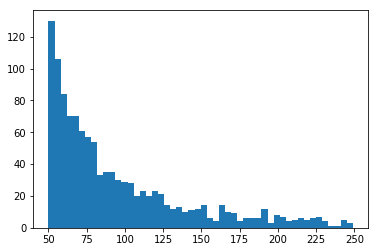

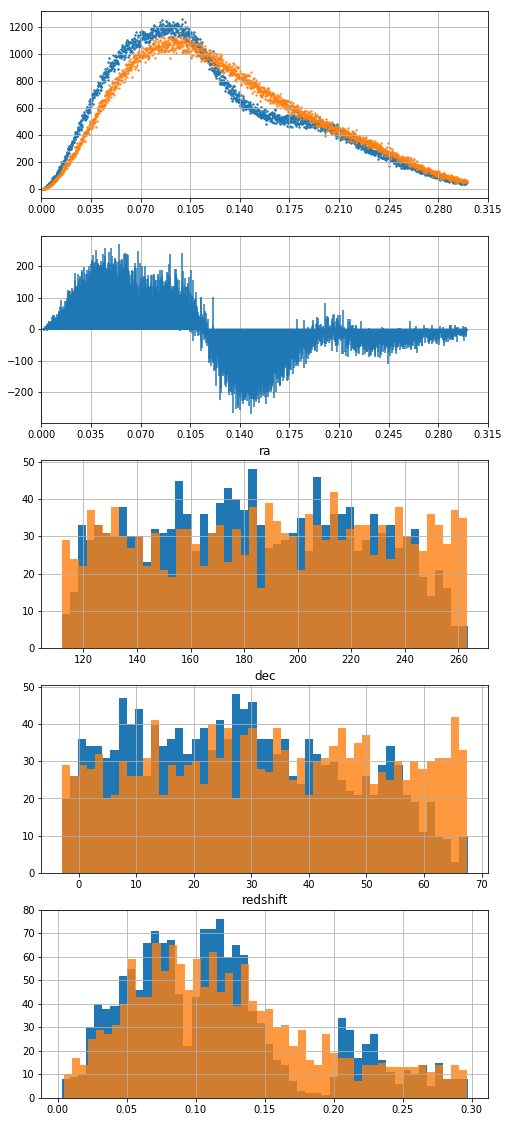

In [0]:
final_3_recounte_huge = final_res(xyz_subareas_5, result_3, 45, True, 15, 700)

result_3_area, result_3_labels = final_3_recounte_huge
result_3_center_clusters = centers_by_labels(result_3_area, result_3_labels)


sil, cal_har, dav_bol = estimate_res(result_3_area, result_3_labels)
print(sil, cal_har, dav_bol)

visual_estimate(final_3_recounte_huge[1]);
plot_results(result_3_center_clusters, num_bins=2000, right_edge=0.3, mod_mix=4)


In [0]:
s, t = silhouette_no_noize(final_3_recounte_huge[0], final_3_recounte_huge[1])

In [0]:
estimate_res(final_3_recounte_huge[0], final_3_recounte_huge[1], 0,0)

43653.030714480818

<IPython.core.display.Javascript object>


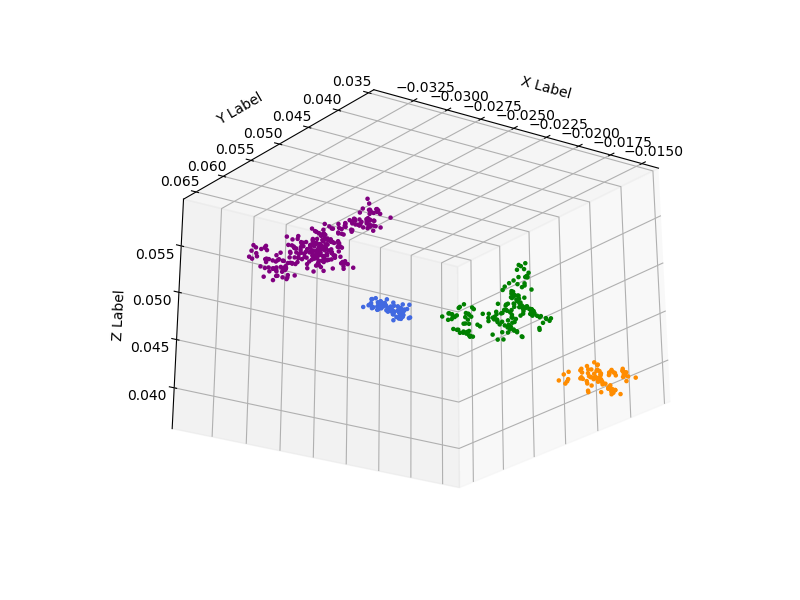

Text(0.5,0,'Z Label')

In [0]:
%matplotlib notebook
fig = plt.figure(figsize=(8,6))
colours = ['royalblue', 'green', 'darkorange', 'purple']
ax = fig.add_subplot(111, projection='3d')

ax.scatter(*(all_area[labels_no_huge==7]).T, c=colours[0], s=5, alpha=1)
ax.scatter(*(all_area[labels_no_huge==8]).T, c=colours[1], s=5, alpha=1)
ax.scatter(*(all_area[labels_no_huge==11]).T, c=colours[2], s=5, alpha=1)
ax.scatter(*(all_area[labels_no_huge==20]).T, c=colours[3], s=5, alpha=1)


ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

In [0]:
%matplotlib inline

In [0]:
A = np.array([[150**2, 150, 1], [100**2, 100, 1], [200**2, 200, 1]])
b = np.array([0, 4, 2])
solve_num_galaxies_in_1_cl = np.linalg.solve(A, b)

num_subareas = 4
subareas = get_subareas(left_area, num_subareas)
result_small_to_noize_huge_too = list()
for i in range(num_subareas):
    print('\n\n\n', i, 'new subarea!!!')
    xyz_subarea = to_xyz(subareas[i])
    
    solve_num_cl = squared_func_coefs_num_clusters(
        round(xyz_subarea.shape[0]/left_area.shape[0]*1300),
        offset=30, 
        value_left=4, 
        value_right=4
    )
    result_ = differential_evolution(loss_func,
                                [(0.00001, 0.001), (3, 40)], 
                                (xyz_subarea, solve_num_galaxies_in_1_cl, solve_num_cl, True),
                                maxiter=12, popsize=10)
    result_small_to_noize_huge_too.append(result_)




 0 new subarea!!!
eps = 0.00049  num_neighbors = 38.0
time: 2.2557075023651123
7112015.89273 466.56 0 

num clusters = 5 num without dropping = 5
7112482.45273
------------------------------------------

eps = 0.00063  num_neighbors = 31.0
time: 2.267697334289551
818667.491656 348.444444444 0 

num clusters = 49 num without dropping = 49
819015.9361
------------------------------------------

eps = 0.00077  num_neighbors = 33.0
time: 2.416614294052124
390934.734275 237.16 0 

num clusters = 98 num without dropping = 99
391171.894275
------------------------------------------

eps = 0.00019  num_neighbors = 38.0
time: 1.8549549579620361
1000000.0 1000000.0 0 

num clusters = 0 num without dropping = 0
2000000.0
------------------------------------------

eps = 0.00011  num_neighbors = 10.0
time: 1.7779786586761475
1000000.0 1000000.0 0 

num clusters = 0 num without dropping = 2
2000000.0
------------------------------------------

eps = 0.00070  num_neighbors = 8.0
time: 2.493567705

eps = 0.00091  num_neighbors = 18.0
time: 2.6754815578460693
45660.3023569 144.0 0 

num clusters = 509 num without dropping = 709
45804.3023569
------------------------------------------

eps = 0.00059  num_neighbors = 34.0
time: 2.2766778469085693
1818970.17859 418.884444444 0 

num clusters = 22 num without dropping = 22
1819389.06304
------------------------------------------

eps = 0.00077  num_neighbors = 38.0
time: 2.4283618927001953
665595.852033 324.0 0 

num clusters = 59 num without dropping = 59
665919.852033
------------------------------------------

eps = 0.00031  num_neighbors = 11.0
time: 2.0448250770568848
1840900.82106 418.884444444 0 

num clusters = 22 num without dropping = 127
1841319.70551
------------------------------------------

eps = 0.00093  num_neighbors = 17.0
time: 3.0482516288757324
40126.7824828 207.36 0 

num clusters = 545 num without dropping = 824
40334.1424828
------------------------------------------

eps = 0.00047  num_neighbors = 13.0
time: 2

eps = 0.00058  num_neighbors = 37.0
time: 2.247694730758667
3010149.0358 443.804444444 0 

num clusters = 13 num without dropping = 13
3010592.84024
------------------------------------------

eps = 0.00080  num_neighbors = 9.0
time: 2.6204941272735596
29319.6161406 381.551111111 0 

num clusters = 622 num without dropping = 2278
29701.1672517
------------------------------------------

eps = 0.00077  num_neighbors = 4.0
time: 2.712442398071289
17859.0985093 535.151111111 0 

num clusters = 676 num without dropping = 6811
18394.2496204
------------------------------------------

eps = 0.00087  num_neighbors = 4.0
time: 2.8893625736236572
17376.6420755 284.484444444 0 

num clusters = 582 num without dropping = 5614
17661.1265199
------------------------------------------

eps = 0.00090  num_neighbors = 7.0
time: 2.8393895626068115
17529.3761466 386.777777778 0 

num clusters = 624 num without dropping = 3060
17916.1539243
------------------------------------------

eps = 0.00086  num_n

eps = 0.00087  num_neighbors = 4.0
time: 3.03427791595459
17376.6420755 284.484444444 0 

num clusters = 582 num without dropping = 5614
17661.1265199
------------------------------------------

eps = 0.00090  num_neighbors = 5.0
time: 2.859358310699463
17357.1131728 298.137777778 0 

num clusters = 588 num without dropping = 4307
17655.2509506
------------------------------------------

eps = 0.00076  num_neighbors = 13.0
time: 2.4765799045562744
51589.4757501 129.96 0 

num clusters = 500 num without dropping = 1081
51719.4357501
------------------------------------------

eps = 0.00076  num_neighbors = 4.0
time: 2.740426778793335
17807.2669643 535.151111111 0 

num clusters = 676 num without dropping = 6946
18342.4180754
------------------------------------------

eps = 0.00078  num_neighbors = 22.0
time: 2.4995651245117188
120168.878277 12.96 0 

num clusters = 275 num without dropping = 336
120181.838277
------------------------------------------

eps = 0.00070  num_neighbors = 4.

eps = 0.00076  num_neighbors = 27.0
time: 2.4385993480682373
204035.746268 101.337777778 0 

num clusters = 178 num without dropping = 183
204137.084046
------------------------------------------

eps = 0.00066  num_neighbors = 3.0
time: 2.635486602783203
21882.8554542 672.537777778 0 

num clusters = 718 num without dropping = 11758
22555.393232
------------------------------------------

eps = 0.00078  num_neighbors = 4.0
time: 2.7154617309570312
17670.1819358 522.884444444 0 

num clusters = 672 num without dropping = 6772
18193.0663803
------------------------------------------

eps = 0.00075  num_neighbors = 3.0
time: 2.7494213581085205
16520.4103256 588.871111111 0 

num clusters = 693 num without dropping = 10034
17109.2814368
------------------------------------------

eps = 0.00074  num_neighbors = 3.0
time: 3.8567850589752197
17294.6155173 582.417777778 0 

num clusters = 691 num without dropping = 10286
17877.0332951
------------------------------------------

eps = 0.00076 

eps = 0.00077  num_neighbors = 4.0
time: 2.7084455490112305
17819.9857532 516.804444444 0 

num clusters = 670 num without dropping = 6781
18336.7901976
------------------------------------------

eps = 0.00070  num_neighbors = 4.0
time: 2.650498390197754
21576.1170775 605.16 0 

num clusters = 698 num without dropping = 7647
22181.2770775
------------------------------------------

eps = 0.00079  num_neighbors = 3.0
time: 3.255152940750122
16594.2127745 529.0 0 

num clusters = 674 num without dropping = 9151
17123.2127745
------------------------------------------

eps = 0.00068  num_neighbors = 3.0
time: 2.6434829235076904
20474.3425093 679.471111111 0 

num clusters = 720 num without dropping = 11440
21153.8136204
------------------------------------------

eps = 0.00071  num_neighbors = 3.0
time: 3.004274845123291
18301.7971174 665.64 0 

num clusters = 716 num without dropping = 10808
18967.4371174
------------------------------------------

eps = 0.00076  num_neighbors = 3.0
tim

eps = 0.00077  num_neighbors = 3.0
time: 2.7564170360565186
16690.0382981 566.44 0 

num clusters = 686 num without dropping = 9518
17256.4782981
------------------------------------------

eps = 0.00078  num_neighbors = 3.0
time: 2.8273766040802
16410.8590044 572.804444444 0 

num clusters = 688 num without dropping = 9433
16983.6634488
------------------------------------------

eps = 0.00077  num_neighbors = 3.0
time: 2.795396327972412
15655.4019483 569.617777778 0 

num clusters = 687 num without dropping = 9630
16225.019726
------------------------------------------

eps = 0.00077  num_neighbors = 3.0
time: 2.7654147148132324
15653.1982669 569.617777778 0 

num clusters = 687 num without dropping = 9627
16222.8160446
------------------------------------------

eps = 0.00077  num_neighbors = 3.0
time: 2.8393900394439697
15655.4019483 569.617777778 0 

num clusters = 687 num without dropping = 9630
16225.019726
------------------------------------------

eps = 0.00100  num_neighbors

eps = 0.00088  num_neighbors = 3.0
time: 2.8453638553619385
23128.4840846 97.3511111111 0 

num clusters = 453 num without dropping = 6545
23225.8351957
------------------------------------------

eps = 0.00015  num_neighbors = 12.0
time: 1.6990258693695068
1000000.0 1000000.0 0 

num clusters = 0 num without dropping = 0
2000000.0
------------------------------------------

eps = 0.00087  num_neighbors = 29.0
time: 2.520552396774292
121169.99301 32.1111111111 0 

num clusters = 220 num without dropping = 222
121202.104121
------------------------------------------

eps = 0.00059  num_neighbors = 20.0
time: 2.112786293029785
258621.456387 144.0 0 

num clusters = 125 num without dropping = 172
258765.456387
------------------------------------------

eps = 0.00054  num_neighbors = 3.0
time: 2.2776920795440674
38465.5192262 148.84 0 

num clusters = 488 num without dropping = 11972
38614.3592262
------------------------------------------

eps = 0.00079  num_neighbors = 4.0
time: 2.62549

eps = 0.00074  num_neighbors = 4.0
time: 3.408043622970581
19466.3637562 260.284444444 0 

num clusters = 547 num without dropping = 6148
19726.6482006
------------------------------------------

eps = 0.00065  num_neighbors = 25.0
time: 2.5375442504882812
267459.718023 152.111111111 0 

num clusters = 120 num without dropping = 120
267611.829134
------------------------------------------

eps = 0.00090  num_neighbors = 7.0
time: 2.662473678588867
20255.1251675 153.76 0 

num clusters = 491 num without dropping = 2437
20408.8851675
------------------------------------------

eps = 0.00084  num_neighbors = 18.0
time: 2.588515281677246
54898.8801037 23.04 0 

num clusters = 377 num without dropping = 577
54921.9201037
------------------------------------------

eps = 0.00044  num_neighbors = 6.0
time: 2.426340103149414
103271.763289 3.24 0 

num clusters = 278 num without dropping = 2826
103275.003289
------------------------------------------

eps = 0.00086  num_neighbors = 5.0
time: 3.

eps = 0.00095  num_neighbors = 3.0
time: 2.9612982273101807
27133.4398276 38.44 0 

num clusters = 398 num without dropping = 5470
27171.8798276
------------------------------------------

eps = 0.00072  num_neighbors = 16.0
time: 2.3336598873138428
72495.7734588 5.13777777778 0 

num clusters = 339 num without dropping = 585
72500.9112366
------------------------------------------

eps = 0.00086  num_neighbors = 4.0
time: 2.7384250164031982
21889.8319511 125.44 0 

num clusters = 473 num without dropping = 5017
22015.2719511
------------------------------------------

eps = 0.00078  num_neighbors = 3.0
time: 2.72943377494812
18187.1687554 203.537777778 0 

num clusters = 519 num without dropping = 8066
18390.7065332
------------------------------------------

eps = 0.00081  num_neighbors = 25.0
time: 2.437600612640381
101678.939056 9.0 0 

num clusters = 260 num without dropping = 271
101687.939056
------------------------------------------

eps = 0.00064  num_neighbors = 3.0
time: 2.

eps = 0.00076  num_neighbors = 5.0
time: 2.8813648223876953
20318.7576676 251.751111111 0 

num clusters = 543 num without dropping = 4523
20570.5087788
------------------------------------------

eps = 0.00077  num_neighbors = 4.0
time: 2.6245617866516113
18197.2070635 253.871111111 0 

num clusters = 544 num without dropping = 5886
18451.0781746
------------------------------------------

eps = 0.00079  num_neighbors = 3.0
time: 2.742434501647949
18120.0085106 197.871111111 0 

num clusters = 516 num without dropping = 7924
18317.8796217
------------------------------------------

eps = 0.00074  num_neighbors = 4.0
time: 2.5185532569885254
19532.9659679 260.284444444 0 

num clusters = 547 num without dropping = 6150
19793.2504123
------------------------------------------

eps = 0.00076  num_neighbors = 4.0
time: 2.620494842529297
18699.5605566 262.44 0 

num clusters = 548 num without dropping = 6045
18962.0005566
------------------------------------------

eps = 0.00075  num_neigh

eps = 0.00079  num_neighbors = 5.0
time: 2.6694672107696533
19238.7665924 219.04 0 

num clusters = 527 num without dropping = 4323
19457.8065924
------------------------------------------

eps = 0.00074  num_neighbors = 32.0
time: 2.3416550159454346
336001.786558 196.0 0 

num clusters = 95 num without dropping = 96
336197.786558
------------------------------------------

eps = 0.00082  num_neighbors = 4.0
time: 2.6694672107696533
19496.9547177 144.0 0 

num clusters = 485 num without dropping = 5336
19640.9547177
------------------------------------------

eps = 0.00078  num_neighbors = 4.0
time: 2.772688627243042
18753.2644165 227.004444444 0 

num clusters = 531 num without dropping = 5810
18980.268861
------------------------------------------

eps = 0.00076  num_neighbors = 22.0
time: 2.3979649543762207
107586.908607 12.4844444444 0 

num clusters = 252 num without dropping = 305
107599.393052
------------------------------------------

eps = 0.00075  num_neighbors = 3.0
time: 3

eps = 0.00075  num_neighbors = 3.0
time: 2.6454784870147705
17597.6402938 264.604444444 0 

num clusters = 549 num without dropping = 8640
17862.2447383
------------------------------------------

eps = 0.00076  num_neighbors = 3.0
time: 2.6394870281219482
17476.3632416 239.217777778 0 

num clusters = 537 num without dropping = 8408
17715.5810194
------------------------------------------

eps = 0.00076  num_neighbors = 4.0
time: 2.6224982738494873
18450.0203602 271.151111111 0 

num clusters = 552 num without dropping = 6025
18721.1714713
------------------------------------------

eps = 0.00077  num_neighbors = 3.0
time: 2.666468858718872
18109.9160454 221.017777778 0 

num clusters = 528 num without dropping = 8210
18330.9338231
------------------------------------------

eps = 0.00074  num_neighbors = 3.0
time: 2.605504274368286
17611.2102556 273.351111111 0 

num clusters = 553 num without dropping = 8762
17884.5613667
------------------------------------------

eps = 0.00076  nu

eps = 0.00028  num_neighbors = 25.0
time: 2.3256642818450928
1000000.0 1000000.0 0 

num clusters = 0 num without dropping = 0
2000000.0
------------------------------------------

eps = 0.00056  num_neighbors = 9.0
time: 2.0428266525268555
26106300.625 576.0 0 

num clusters = 1 num without dropping = 69
26106876.625
------------------------------------------

eps = 0.00003  num_neighbors = 12.0
time: 1.9678704738616943
1000000.0 1000000.0 0 

num clusters = 0 num without dropping = 0
2000000.0
------------------------------------------

eps = 0.00017  num_neighbors = 20.0
time: 2.0608363151550293
1000000.0 1000000.0 0 

num clusters = 0 num without dropping = 0
2000000.0
------------------------------------------

eps = 0.00067  num_neighbors = 23.0
time: 2.1927409172058105
1000000.0 1000000.0 0 

num clusters = 0 num without dropping = 0
2000000.0
------------------------------------------

eps = 0.00075  num_neighbors = 25.0
time: 2.2527060508728027
1000000.0 1000000.0 0 

num clus

eps = 0.00075  num_neighbors = 17.0
time: 2.1847455501556396
13046778.7331 569.617777778 0 

num clusters = 3 num without dropping = 12
13047348.3509
------------------------------------------

eps = 0.00062  num_neighbors = 23.0
time: 2.101792812347412
1000000.0 1000000.0 0 

num clusters = 0 num without dropping = 0
2000000.0
------------------------------------------

eps = 0.00046  num_neighbors = 7.0
time: 2.0448238849639893
1000000.0 1000000.0 0 

num clusters = 0 num without dropping = 106
2000000.0
------------------------------------------

eps = 0.00053  num_neighbors = 3.0
time: 2.1007962226867676
2733102.86221 522.884444444 0 

num clusters = 18 num without dropping = 7308
2733625.74665
------------------------------------------

eps = 0.00098  num_neighbors = 18.0
time: 2.2517030239105225
1722709.65735 489.884444444 0 

num clusters = 29 num without dropping = 59
1723199.54179
------------------------------------------

eps = 0.00090  num_neighbors = 18.0
time: 2.212729454

eps = 0.00066  num_neighbors = 38.0
time: 2.7494213581085205
1000000.0 1000000.0 0 

num clusters = 0 num without dropping = 0
2000000.0
------------------------------------------

eps = 0.00097  num_neighbors = 11.0
time: 2.592510938644409
485113.094093 298.137777778 0 

num clusters = 102 num without dropping = 500
485411.231871
------------------------------------------

eps = 0.00024  num_neighbors = 9.0
time: 1.967867374420166
1000000.0 1000000.0 0 

num clusters = 0 num without dropping = 0
2000000.0
------------------------------------------

eps = 0.00062  num_neighbors = 10.0
time: 2.102792263031006
8691770.06153 563.271111111 0 

num clusters = 5 num without dropping = 67
8692333.33264
------------------------------------------

eps = 0.00094  num_neighbors = 33.0
time: 2.2067322731018066
1000000.0 1000000.0 0 

num clusters = 0 num without dropping = 0
2000000.0
------------------------------------------

eps = 0.00088  num_neighbors = 21.0
time: 2.193739891052246
10433522.8

eps = 0.00100  num_neighbors = 29.0
time: 2.2577033042907715
26103796.045 576.0 0 

num clusters = 1 num without dropping = 1
26104372.045
------------------------------------------

eps = 0.00094  num_neighbors = 5.0
time: 2.570521354675293
148594.059646 16.0 0 

num clusters = 301 num without dropping = 4187
148610.059646
------------------------------------------

eps = 0.00084  num_neighbors = 33.0
time: 2.4535934925079346
1000000.0 1000000.0 0 

num clusters = 0 num without dropping = 0
2000000.0
------------------------------------------

eps = 0.00032  num_neighbors = 30.0
time: 2.273690938949585
1000000.0 1000000.0 0 

num clusters = 0 num without dropping = 0
2000000.0
------------------------------------------

eps = 0.00091  num_neighbors = 4.0
time: 2.3986406326293945
133730.776407 4.27111111111 0 

num clusters = 330 num without dropping = 6772
133735.047518
------------------------------------------

eps = 0.00098  num_neighbors = 10.0
time: 2.4366002082824707
362288.9376

eps = 0.00090  num_neighbors = 3.0
time: 2.4196279048919678
127880.842722 1.77777777778 0 

num clusters = 341 num without dropping = 12714
127882.620499
------------------------------------------

eps = 0.00099  num_neighbors = 3.0
time: 2.405637264251709
95426.8322538 17.0844444444 0 

num clusters = 423 num without dropping = 12960
95443.9166982
------------------------------------------

eps = 0.00094  num_neighbors = 3.0
time: 2.3836498260498047
109219.886045 2.77777777778 0 

num clusters = 386 num without dropping = 12811
109222.663823
------------------------------------------

eps = 0.00017  num_neighbors = 4.0
time: 2.018841028213501
1000000.0 1000000.0 0 

num clusters = 0 num without dropping = 13
2000000.0
------------------------------------------

eps = 0.00088  num_neighbors = 12.0
time: 2.239712715148926
985820.426162 427.111111111 0 

num clusters = 51 num without dropping = 219
986247.537273
------------------------------------------

eps = 0.00099  num_neighbors = 3

eps = 0.00097  num_neighbors = 3.0
time: 2.4116148948669434
99731.002545 10.6711111111 0 

num clusters = 410 num without dropping = 12903
99741.6736561
------------------------------------------

eps = 0.00064  num_neighbors = 4.0
time: 2.1227807998657227
824341.914768 400.0 0 

num clusters = 61 num without dropping = 4223
824741.914768
------------------------------------------

eps = 0.00090  num_neighbors = 4.0
time: 2.319688081741333
148626.12677 16.0 0 

num clusters = 301 num without dropping = 6710
148642.12677
------------------------------------------

eps = 0.00098  num_neighbors = 3.0
time: 2.4086191654205322
97276.6533062 13.9377777778 0 

num clusters = 417 num without dropping = 12943
97290.591084
------------------------------------------

eps = 0.00098  num_neighbors = 3.0
time: 2.4146108627319336
98629.5561614 12.0177777778 0 

num clusters = 413 num without dropping = 12930
98641.5739391
------------------------------------------

eps = 0.00100  num_neighbors = 3.0


eps = 0.00053  num_neighbors = 19.0
time: 1.7460143566131592
1000000.0 1000000.0 0 

num clusters = 0 num without dropping = 0
2000000.0
------------------------------------------

eps = 0.00081  num_neighbors = 16.0
time: 1.8039627075195312
4121406.81764 392.04 0 

num clusters = 8 num without dropping = 26
4121798.85764
------------------------------------------

eps = 0.00019  num_neighbors = 40.0
time: 1.6090798377990723
1000000.0 1000000.0 0 

num clusters = 0 num without dropping = 0
2000000.0
------------------------------------------

eps = 0.00014  num_neighbors = 6.0
time: 1.583089828491211
1000000.0 1000000.0 0 

num clusters = 0 num without dropping = 0
2000000.0
------------------------------------------

eps = 0.00044  num_neighbors = 3.0
time: 1.7060189247131348
6197446.80487 400.0 0 

num clusters = 5 num without dropping = 4081
6197846.80487
------------------------------------------

eps = 0.00010  num_neighbors = 33.0
time: 1.5721168518066406
1000000.0 1000000.0 0 



eps = 0.00010  num_neighbors = 9.0
time: 1.5860893726348877
1000000.0 1000000.0 0 

num clusters = 0 num without dropping = 0
2000000.0
------------------------------------------

eps = 0.00067  num_neighbors = 9.0
time: 1.7879753112792969
2644783.073 378.951111111 0 

num clusters = 13 num without dropping = 136
2645162.02411
------------------------------------------

eps = 0.00033  num_neighbors = 20.0
time: 1.6430561542510986
1000000.0 1000000.0 0 

num clusters = 0 num without dropping = 0
2000000.0
------------------------------------------

eps = 0.00097  num_neighbors = 12.0
time: 1.8979101181030273
706423.655302 289.0 0 

num clusters = 50 num without dropping = 252
706712.655302
------------------------------------------

eps = 0.00074  num_neighbors = 22.0
time: 1.8199536800384521
1000000.0 1000000.0 0 

num clusters = 0 num without dropping = 0
2000000.0
------------------------------------------

eps = 0.00073  num_neighbors = 14.0
time: 1.7949697971343994
4123189.75338 39

eps = 0.00062  num_neighbors = 6.0
time: 1.7509944438934326
1943846.82975 366.084444444 0 

num clusters = 18 num without dropping = 698
1944212.91419
------------------------------------------

eps = 0.00083  num_neighbors = 5.0
time: 1.8569340705871582
299729.593038 160.444444444 0 

num clusters = 115 num without dropping = 2855
299890.037482
------------------------------------------

eps = 0.00057  num_neighbors = 34.0
time: 1.730006217956543
1000000.0 1000000.0 0 

num clusters = 0 num without dropping = 0
2000000.0
------------------------------------------

eps = 0.00048  num_neighbors = 22.0
time: 1.6960256099700928
1000000.0 1000000.0 0 

num clusters = 0 num without dropping = 0
2000000.0
------------------------------------------

eps = 0.00078  num_neighbors = 3.0
time: 1.9239156246185303
240452.851455 118.084444444 0 

num clusters = 142 num without dropping = 9797
240570.935899
------------------------------------------

eps = 0.00084  num_neighbors = 22.0
time: 1.862930

eps = 0.00052  num_neighbors = 21.0
time: 2.086801290512085
1000000.0 1000000.0 0 

num clusters = 0 num without dropping = 0
2000000.0
------------------------------------------

eps = 0.00066  num_neighbors = 31.0
time: 1.7703888416290283
1000000.0 1000000.0 0 

num clusters = 0 num without dropping = 0
2000000.0
------------------------------------------

eps = 0.00096  num_neighbors = 4.0
time: 1.9828648567199707
122183.098946 10.6711111111 0 

num clusters = 256 num without dropping = 5835
122193.770057
------------------------------------------

eps = 0.00044  num_neighbors = 6.0
time: 1.6800353527069092
1000000.0 1000000.0 0 

num clusters = 0 num without dropping = 142
2000000.0
------------------------------------------

eps = 0.00076  num_neighbors = 11.0
time: 1.791971206665039
1677114.86424 358.471111111 0 

num clusters = 21 num without dropping = 111
1677473.33535
------------------------------------------

eps = 0.00096  num_neighbors = 4.0
time: 1.9248967170715332
12218

eps = 0.00093  num_neighbors = 3.0
time: 1.9738686084747314
116541.60903 6.08444444444 0 

num clusters = 268 num without dropping = 10798
116547.693475
------------------------------------------

eps = 0.00004  num_neighbors = 5.0
time: 1.564101219177246
1000000.0 1000000.0 0 

num clusters = 0 num without dropping = 0
2000000.0
------------------------------------------

eps = 0.00058  num_neighbors = 4.0
time: 1.8739261627197266
1415346.55608 348.444444444 0 

num clusters = 25 num without dropping = 2702
1415695.00052
------------------------------------------

eps = 0.00089  num_neighbors = 6.0
time: 1.8739240169525146
276820.174736 145.604444444 0 

num clusters = 124 num without dropping = 1943
276965.77918
------------------------------------------

eps = 0.00026  num_neighbors = 19.0
time: 1.6160714626312256
1000000.0 1000000.0 0 

num clusters = 0 num without dropping = 0
2000000.0
------------------------------------------

eps = 0.00096  num_neighbors = 4.0
time: 1.93389272

eps = 0.00097  num_neighbors = 11.0
time: 2.8003933429718018
618968.607483 273.351111111 0 

num clusters = 57 num without dropping = 358
619241.958594
------------------------------------------

eps = 0.00100  num_neighbors = 4.0
time: 2.0738306045532227
104449.269166 0.871111111111 0 

num clusters = 291 num without dropping = 5962
104450.140277
------------------------------------------

eps = 0.00007  num_neighbors = 4.0
time: 1.5910863876342773
1000000.0 1000000.0 0 

num clusters = 0 num without dropping = 0
2000000.0
------------------------------------------

eps = 0.00093  num_neighbors = 3.0
time: 2.03583025932312
121256.1311 9.40444444444 0 

num clusters = 259 num without dropping = 10785
121265.535544
------------------------------------------

eps = 0.00099  num_neighbors = 4.0
time: 2.2926838397979736
107755.217155 1.96 0 

num clusters = 284 num without dropping = 5914
107757.177155
------------------------------------------

eps = 0.00100  num_neighbors = 3.0
time: 2.0

In [0]:
A = np.array([[150**2, 150, 1], [100**2, 100, 1], [200**2, 200, 1]])
b = np.array([0, 4, 2])
solve_num_galaxies_in_1_cl = np.linalg.solve(A, b)

num_subareas = 4
subareas = get_subareas(left_area, num_subareas)
result_small_to_noize_2 = list()
for i in range(num_subareas):
    print('\n\n\n', i, 'new subarea!!!')
    xyz_subarea = to_xyz(subareas[i])
    
    solve_num_cl = squared_func_coefs_num_clusters(
        round(xyz_subarea.shape[0]/left_area.shape[0]*1300),
        offset=30, 
        value_left=2, 
        value_right=6
    )
    result_ = differential_evolution(loss_func,
                                [(0.00001, 0.001), (3, 40)], 
                                (xyz_subarea, solve_num_galaxies_in_1_cl, solve_num_cl, True),
                                maxiter=12, popsize=10)
    result_small_to_noize_2.append(result_)




 0 new subarea!!!
eps = 0.00045  num_neighbors = 36.0
time: 2.112783432006836
8554467.9508 447.777777778 0 

num clusters = 4 num without dropping = 4
8554915.72858
------------------------------------------

eps = 0.00080  num_neighbors = 13.0
time: 2.53456449508667
44058.0661847 204.24 0 

num clusters = 536 num without dropping = 1159
44262.3061847
------------------------------------------

eps = 0.00016  num_neighbors = 10.0
time: 1.8249516487121582
6187910.32657 442.151111111 0 

num clusters = 6 num without dropping = 17
6188352.47768
------------------------------------------

eps = 0.00051  num_neighbors = 33.0
time: 2.2397119998931885
3024115.39403 422.737777778 0 

num clusters = 13 num without dropping = 13
3024538.13181
------------------------------------------

eps = 0.00064  num_neighbors = 4.0
time: 2.5025625228881836
27508.2938009 564.604444444 0 

num clusters = 678 num without dropping = 8229
28072.8982453
------------------------------------------

eps = 0.00033

eps = 0.00053  num_neighbors = 11.0
time: 3.1651833057403564
161545.941598 42.0 0 

num clusters = 224 num without dropping = 806
161587.941598
------------------------------------------

eps = 0.00064  num_neighbors = 4.0
time: 3.042253017425537
27508.2938009 564.604444444 0 

num clusters = 678 num without dropping = 8229
28072.8982453
------------------------------------------

eps = 0.00099  num_neighbors = 24.0
time: 2.841371536254883
61658.1979402 32.24 0 

num clusters = 407 num without dropping = 465
61690.4379402
------------------------------------------

eps = 0.00097  num_neighbors = 15.0
time: 2.7953948974609375
28795.5085344 374.817777778 0 

num clusters = 612 num without dropping = 1072
29170.3263122
------------------------------------------

eps = 0.00066  num_neighbors = 9.0
time: 2.3726377487182617
53845.3706986 135.084444444 0 

num clusters = 496 num without dropping = 1980
53980.455143
------------------------------------------

eps = 0.00090  num_neighbors = 12.

eps = 0.00094  num_neighbors = 11.0
time: 2.8293938636779785
22374.9209362 491.111111111 0 

num clusters = 654 num without dropping = 1699
22866.0320473
------------------------------------------

eps = 0.00088  num_neighbors = 6.0
time: 2.8223798274993896
16751.8683377 367.111111111 0 

num clusters = 609 num without dropping = 3667
17118.9794488
------------------------------------------

eps = 0.00089  num_neighbors = 5.0
time: 2.9443092346191406
17659.5307986 310.684444444 0 

num clusters = 586 num without dropping = 4339
17970.2152431
------------------------------------------

eps = 0.00099  num_neighbors = 9.0
time: 2.9423301219940186
16900.1550715 359.484444444 0 

num clusters = 606 num without dropping = 2095
17259.6395159
------------------------------------------

eps = 0.00081  num_neighbors = 12.0
time: 3.3110992908477783
39728.8779181 244.151111111 0 

num clusters = 556 num without dropping = 1385
39973.0290292
------------------------------------------

eps = 0.00027

eps = 0.00052  num_neighbors = 9.0
time: 2.2407336235046387
129106.572185 11.5377777778 0 

num clusters = 270 num without dropping = 1387
129118.109962
------------------------------------------

eps = 0.00053  num_neighbors = 9.0
time: 2.190742254257202
126480.655216 9.77777777778 0 

num clusters = 274 num without dropping = 1407
126490.432994
------------------------------------------

eps = 0.00097  num_neighbors = 6.0
time: 2.955301523208618
21225.9044577 211.937777778 0 

num clusters = 540 num without dropping = 3150
21437.8422354
------------------------------------------

eps = 0.00098  num_neighbors = 10.0
time: 2.8853256702423096
19255.2338498 401.084444444 0 

num clusters = 622 num without dropping = 1886
19656.3182942
------------------------------------------

eps = 0.00099  num_neighbors = 8.0
time: 2.936314344406128
15748.6235793 337.084444444 0 

num clusters = 597 num without dropping = 2338
16085.7080237
------------------------------------------

eps = 0.00096  nu

eps = 0.00098  num_neighbors = 8.0
time: 2.9303205013275146
16223.2794236 322.551111111 0 

num clusters = 591 num without dropping = 2357
16545.8305348
------------------------------------------

eps = 0.00093  num_neighbors = 11.0
time: 2.7804062366485596
22704.0302989 509.004444444 0 

num clusters = 660 num without dropping = 1706
23213.0347434
------------------------------------------

eps = 0.00089  num_neighbors = 5.0
time: 2.857377052307129
17606.3822409 332.204444444 0 

num clusters = 595 num without dropping = 4388
17938.5866854
------------------------------------------

eps = 0.00098  num_neighbors = 8.0
time: 2.99627947807312
15745.7871967 344.471111111 0 

num clusters = 600 num without dropping = 2343
16090.2583078
------------------------------------------

eps = 0.00099  num_neighbors = 8.0
time: 3.1132144927978516
15780.3845171 337.084444444 0 

num clusters = 597 num without dropping = 2339
16117.4689615
------------------------------------------

eps = 0.00099  nu

eps = 0.00098  num_neighbors = 8.0
time: 2.9223217964172363
15866.0586504 339.537777778 0 

num clusters = 598 num without dropping = 2346
16205.5964282
------------------------------------------

eps = 0.00090  num_neighbors = 6.0
time: 2.8303744792938232
17115.639399 354.444444444 0 

num clusters = 604 num without dropping = 3587
17470.0838435
------------------------------------------

eps = 0.00099  num_neighbors = 9.0
time: 2.935335397720337
16999.9227201 356.96 0 

num clusters = 605 num without dropping = 2096
17356.8827201
------------------------------------------

eps = 0.00053  num_neighbors = 10.0
time: 2.2307212352752686
150837.585102 32.24 0 

num clusters = 236 num without dropping = 1061
150869.825102
------------------------------------------

eps = 0.00093  num_neighbors = 7.0
time: 2.858358860015869
17169.2547323 393.111111111 0 

num clusters = 619 num without dropping = 2938
17562.3658434
------------------------------------------

eps = 0.00100  num_neighbors = 1

eps = 0.00041  num_neighbors = 8.0
time: 2.0897998809814453
232772.775317 107.217777778 0 

num clusters = 166 num without dropping = 1099
232879.993095
------------------------------------------

eps = 0.00099  num_neighbors = 8.0
time: 2.9393322467803955
15749.7273271 329.777777778 0 

num clusters = 594 num without dropping = 2342
16079.5051048
------------------------------------------

eps = 0.00099  num_neighbors = 8.0
time: 2.97129487991333
15715.4223324 337.084444444 0 

num clusters = 597 num without dropping = 2340
16052.5067769
------------------------------------------

eps = 0.00099  num_neighbors = 8.0
time: 2.94730544090271
15715.0881987 337.084444444 0 

num clusters = 597 num without dropping = 2340
16052.1726431
------------------------------------------

eps = 0.00099  num_neighbors = 8.0
time: 2.922323226928711
15715.4223324 337.084444444 0 

num clusters = 597 num without dropping = 2340
16052.5067769
------------------------------------------

eps = 0.00100  num_n

eps = 0.00059  num_neighbors = 39.0
time: 2.506558895111084
1987970.66404 349.44 0 

num clusters = 17 num without dropping = 18
1988320.10404
------------------------------------------

eps = 0.00097  num_neighbors = 15.0
time: 3.172196388244629
28007.4635078 156.0 0 

num clusters = 485 num without dropping = 863
28163.4635078
------------------------------------------

eps = 0.00097  num_neighbors = 5.0
time: 3.649906635284424
26053.2942485 57.0044444444 0 

num clusters = 411 num without dropping = 3209
26110.298693
------------------------------------------

eps = 0.00061  num_neighbors = 28.0
time: 2.6085023880004883
481487.749465 229.777777778 0 

num clusters = 70 num without dropping = 72
481717.527243
------------------------------------------

eps = 0.00067  num_neighbors = 12.0
time: 2.9083497524261475
63831.2658846 23.1111111111 0 

num clusters = 370 num without dropping = 966
63854.3769957
------------------------------------------

eps = 0.00039  num_neighbors = 40.0
ti

eps = 0.00098  num_neighbors = 11.0
time: 3.304102659225464
21475.5556064 176.64 0 

num clusters = 497 num without dropping = 1372
21652.1956064
------------------------------------------

eps = 0.00078  num_neighbors = 6.0
time: 3.006272077560425
21525.898379 246.24 0 

num clusters = 533 num without dropping = 3413
21772.138379
------------------------------------------

eps = 0.00088  num_neighbors = 9.0
time: 3.3001279830932617
23613.3300722 167.884444444 0 

num clusters = 492 num without dropping = 1840
23781.2145167
------------------------------------------

eps = 0.00084  num_neighbors = 4.0
time: 3.209177255630493
19565.3733717 146.16 0 

num clusters = 479 num without dropping = 5208
19711.5333717
------------------------------------------

eps = 0.00062  num_neighbors = 13.0
time: 2.5975089073181152
87348.6916 0.151111111111 0 

num clusters = 307 num without dropping = 703
87348.8427111
------------------------------------------

eps = 0.00065  num_neighbors = 33.0
time: 

eps = 0.00097  num_neighbors = 8.0
time: 3.2322421073913574
20473.9893024 122.96 0 

num clusters = 464 num without dropping = 1986
20596.9493024
------------------------------------------

eps = 0.00068  num_neighbors = 4.0
time: 2.8060832023620605
22299.2839088 327.36 0 

num clusters = 569 num without dropping = 6645
22626.6439088
------------------------------------------

eps = 0.00097  num_neighbors = 8.0
time: 3.3769311904907227
20473.9893024 122.96 0 

num clusters = 464 num without dropping = 1986
20596.9493024
------------------------------------------

eps = 0.00066  num_neighbors = 3.0
time: 2.997072458267212
22618.9868769 308.337777778 0 

num clusters = 561 num without dropping = 10208
22927.3246546
------------------------------------------

eps = 0.00082  num_neighbors = 4.0
time: 3.336573600769043
18554.7900356 169.617777778 0 

num clusters = 493 num without dropping = 5392
18724.4078134
------------------------------------------

eps = 0.00090  num_neighbors = 9.0
ti

eps = 0.00071  num_neighbors = 4.0
time: 2.9792919158935547
20950.9803806 296.737777778 0 

num clusters = 556 num without dropping = 6376
21247.7181584
------------------------------------------

eps = 0.00092  num_neighbors = 10.0
time: 3.2341411113739014
22647.9553211 183.804444444 0 

num clusters = 501 num without dropping = 1571
22831.7597656
------------------------------------------

eps = 0.00083  num_neighbors = 6.0
time: 3.14920973777771
18956.5332761 240.0 0 

num clusters = 530 num without dropping = 3261
19196.5332761
------------------------------------------

eps = 0.00081  num_neighbors = 5.0
time: 3.2111735343933105
18537.2271969 198.56 0 

num clusters = 509 num without dropping = 4200
18735.7871969
------------------------------------------

eps = 0.00073  num_neighbors = 4.0
time: 3.1971640586853027
19163.268095 313.04 0 

num clusters = 563 num without dropping = 6201
19476.308095
------------------------------------------

eps = 0.00075  num_neighbors = 4.0
time:

eps = 0.00088  num_neighbors = 8.0
time: 3.8937621116638184
21399.2652427 174.871111111 0 

num clusters = 496 num without dropping = 2128
21574.1363538
------------------------------------------

eps = 0.00083  num_neighbors = 5.0
time: 3.1671838760375977
18936.5517254 187.44 0 

num clusters = 503 num without dropping = 4138
19123.9917254
------------------------------------------

eps = 0.00078  num_neighbors = 4.0
time: 3.159186363220215
18776.7275095 248.337777778 0 

num clusters = 534 num without dropping = 5843
19025.0652873
------------------------------------------

eps = 0.00072  num_neighbors = 3.0
time: 3.0472686290740967
18476.0729583 294.444444444 0 

num clusters = 555 num without dropping = 9056
18770.5174027
------------------------------------------

eps = 0.00075  num_neighbors = 4.0
time: 2.95330548286438
19151.2226779 274.204444444 0 

num clusters = 546 num without dropping = 6097
19425.4271223
------------------------------------------

eps = 0.00074  num_neighb

eps = 0.00078  num_neighbors = 5.0
time: 3.024264335632324
19859.0224495 244.151111111 0 

num clusters = 532 num without dropping = 4410
20103.1735606
------------------------------------------

eps = 0.00081  num_neighbors = 4.0
time: 3.2271461486816406
18439.9944159 187.44 0 

num clusters = 503 num without dropping = 5488
18627.4344159
------------------------------------------

eps = 0.00080  num_neighbors = 4.0
time: 3.26911997795105
18393.1279 202.337777778 0 

num clusters = 511 num without dropping = 5570
18595.4656778
------------------------------------------

eps = 0.00077  num_neighbors = 4.0
time: 3.1432135105133057
18096.3062872 272.0 0 

num clusters = 545 num without dropping = 5911
18368.3062872
------------------------------------------

eps = 0.00079  num_neighbors = 3.0
time: 3.223148822784424
18201.4599736 210.0 0 

num clusters = 515 num without dropping = 7920
18411.4599736
------------------------------------------

eps = 0.00074  num_neighbors = 4.0
time: 3.02

eps = 0.00028  num_neighbors = 14.0
time: 2.267697811126709
1000000.0 1000000.0 0 

num clusters = 0 num without dropping = 0
2000000.0
------------------------------------------

eps = 0.00039  num_neighbors = 17.0
time: 2.4775795936584473
1000000.0 1000000.0 0 

num clusters = 0 num without dropping = 0
2000000.0
------------------------------------------

eps = 0.00017  num_neighbors = 26.0
time: 2.29068660736084
1000000.0 1000000.0 0 

num clusters = 0 num without dropping = 0
2000000.0
------------------------------------------

eps = 0.00036  num_neighbors = 8.0
time: 2.3106727600097656
1000000.0 1000000.0 0 

num clusters = 0 num without dropping = 4
2000000.0
------------------------------------------

eps = 0.00074  num_neighbors = 39.0
time: 2.5175538063049316
1000000.0 1000000.0 0 

num clusters = 0 num without dropping = 0
2000000.0
------------------------------------------

eps = 0.00022  num_neighbors = 37.0
time: 2.7404258251190186
1000000.0 1000000.0 0 

num clusters =

eps = 0.00037  num_neighbors = 20.0
time: 1.9998512268066406
1000000.0 1000000.0 0 

num clusters = 0 num without dropping = 0
2000000.0
------------------------------------------

eps = 0.00094  num_neighbors = 10.0
time: 2.2287206649780273
461834.62193 269.804444444 0 

num clusters = 107 num without dropping = 632
462104.426374
------------------------------------------

eps = 0.00037  num_neighbors = 20.0
time: 1.9928555488586426
1000000.0 1000000.0 0 

num clusters = 0 num without dropping = 0
2000000.0
------------------------------------------

eps = 0.00083  num_neighbors = 7.0
time: 2.2147276401519775
429665.034266 252.56 0 

num clusters = 115 num without dropping = 1351
429917.594266
------------------------------------------

eps = 0.00093  num_neighbors = 29.0
time: 2.2886853218078613
1000000.0 1000000.0 0 

num clusters = 0 num without dropping = 0
2000000.0
------------------------------------------

eps = 0.00034  num_neighbors = 20.0
time: 2.0238373279571533
1000000.0 

eps = 0.00031  num_neighbors = 9.0
time: 1.971867561340332
1000000.0 1000000.0 0 

num clusters = 0 num without dropping = 0
2000000.0
------------------------------------------

eps = 0.00087  num_neighbors = 4.0
time: 2.2766940593719482
171364.201342 33.0044444444 0 

num clusters = 267 num without dropping = 6458
171397.205786
------------------------------------------

eps = 0.00016  num_neighbors = 4.0
time: 1.898911714553833
1000000.0 1000000.0 0 

num clusters = 0 num without dropping = 7
2000000.0
------------------------------------------

eps = 0.00099  num_neighbors = 3.0
time: 2.4156153202056885
93109.9026713 26.4444444444 0 

num clusters = 431 num without dropping = 12975
93136.3471157
------------------------------------------

eps = 0.00098  num_neighbors = 4.0
time: 2.3656442165374756
107945.110839 5.04 0 

num clusters = 388 num without dropping = 7148
107950.150839
------------------------------------------

eps = 0.00060  num_neighbors = 40.0
time: 2.076807498931884

eps = 0.00085  num_neighbors = 4.0
time: 2.259721040725708
186944.128548 49.2177777778 0 

num clusters = 248 num without dropping = 6316
186993.346326
------------------------------------------

eps = 0.00086  num_neighbors = 20.0
time: 2.197744369506836
10433923.4174 542.64 0 

num clusters = 4 num without dropping = 8
10434466.0574
------------------------------------------

eps = 0.00085  num_neighbors = 5.0
time: 2.2227251529693604
226661.735804 92.5511111111 0 

num clusters = 209 num without dropping = 3642
226754.286915
------------------------------------------

eps = 0.00093  num_neighbors = 22.0
time: 2.2307016849517822
8691019.13793 539.537777778 0 

num clusters = 5 num without dropping = 9
8691558.67571
------------------------------------------

eps = 0.00099  num_neighbors = 4.0
time: 2.3856303691864014
103505.708626 9.77777777778 0 

num clusters = 401 num without dropping = 7199
103515.486404
------------------------------------------

eps = 0.00040  num_neighbors = 1

eps = 0.00047  num_neighbors = 7.0
time: 2.0438265800476074
1000000.0 1000000.0 0 

num clusters = 0 num without dropping = 118
2000000.0
------------------------------------------

eps = 0.00096  num_neighbors = 5.0
time: 2.32468318939209
134849.799643 2.87111111111 0 

num clusters = 327 num without dropping = 4274
134852.670754
------------------------------------------

eps = 0.00100  num_neighbors = 37.0
time: 2.9912822246551514
1000000.0 1000000.0 0 

num clusters = 0 num without dropping = 0
2000000.0
------------------------------------------

eps = 0.00094  num_neighbors = 5.0
time: 2.815401077270508
154274.919062 16.56 0 

num clusters = 292 num without dropping = 4146
154291.479062
------------------------------------------

eps = 0.00075  num_neighbors = 26.0
time: 2.1467695236206055
1000000.0 1000000.0 0 

num clusters = 0 num without dropping = 0
2000000.0
------------------------------------------

eps = 0.00099  num_neighbors = 5.0
time: 2.308673143386841
125979.206003 

eps = 0.00088  num_neighbors = 4.0
time: 2.2766940593719482
164316.847535 25.76 0 

num clusters = 277 num without dropping = 6531
164342.607535
------------------------------------------

eps = 0.00099  num_neighbors = 40.0
time: 2.2487077713012695
1000000.0 1000000.0 0 

num clusters = 0 num without dropping = 0
2000000.0
------------------------------------------

eps = 0.00090  num_neighbors = 4.0
time: 2.317690134048462
150121.727599 12.9511111111 0 

num clusters = 299 num without dropping = 6679
150134.67871
------------------------------------------

eps = 0.00096  num_neighbors = 4.0
time: 2.335679531097412
116894.008549 0.24 0 

num clusters = 364 num without dropping = 7021
116894.248549
------------------------------------------

eps = 0.00048  num_neighbors = 3.0
time: 2.1045424938201904
6513954.56395 533.36 0 

num clusters = 7 num without dropping = 6180
6514487.92395
------------------------------------------

eps = 0.00089  num_neighbors = 4.0
time: 2.2537078857421875


eps = 0.00071  num_neighbors = 11.0
time: 1.7849745750427246
2849037.07185 362.017777778 0 

num clusters = 12 num without dropping = 79
2849399.08962
------------------------------------------

eps = 0.00067  num_neighbors = 6.0
time: 1.794970989227295
1182746.61508 317.777777778 0 

num clusters = 30 num without dropping = 956
1183064.39286
------------------------------------------

eps = 0.00037  num_neighbors = 26.0
time: 1.8039612770080566
1000000.0 1000000.0 0 

num clusters = 0 num without dropping = 0
2000000.0
------------------------------------------

eps = 0.00049  num_neighbors = 28.0
time: 2.208731174468994
1000000.0 1000000.0 0 

num clusters = 0 num without dropping = 0
2000000.0
------------------------------------------

eps = 0.00020  num_neighbors = 7.0
time: 2.090797185897827
1000000.0 1000000.0 0 

num clusters = 0 num without dropping = 0
2000000.0
------------------------------------------

eps = 0.00057  num_neighbors = 18.0
time: 1.7479984760284424
1000000.0 

eps = 0.00071  num_neighbors = 12.0
time: 1.7849748134613037
3708888.98404 369.671111111 0 

num clusters = 9 num without dropping = 52
3709258.65515
------------------------------------------

eps = 0.00022  num_neighbors = 14.0
time: 1.623067855834961
1000000.0 1000000.0 0 

num clusters = 0 num without dropping = 0
2000000.0
------------------------------------------

eps = 0.00042  num_neighbors = 4.0
time: 1.6960256099700928
18614908.361 390.471111111 0 

num clusters = 1 num without dropping = 1110
18615298.8321
------------------------------------------

eps = 0.00016  num_neighbors = 8.0
time: 1.6440587043762207
1000000.0 1000000.0 0 

num clusters = 0 num without dropping = 0
2000000.0
------------------------------------------

eps = 0.00025  num_neighbors = 37.0
time: 1.6370558738708496
1000000.0 1000000.0 0 

num clusters = 0 num without dropping = 0
2000000.0
------------------------------------------

eps = 0.00088  num_neighbors = 11.0
time: 1.8549339771270752
1012333.30

eps = 0.00058  num_neighbors = 22.0
time: 1.7320048809051514
1000000.0 1000000.0 0 

num clusters = 0 num without dropping = 0
2000000.0
------------------------------------------

eps = 0.00099  num_neighbors = 4.0
time: 1.9688873291015625
106350.532135 0.24 0 

num clusters = 287 num without dropping = 5917
106350.772135
------------------------------------------

eps = 0.00094  num_neighbors = 3.0
time: 2.0098636150360107
108796.118881 0.56 0 

num clusters = 284 num without dropping = 10864
108796.678881
------------------------------------------

eps = 0.00046  num_neighbors = 20.0
time: 1.7090177536010742
1000000.0 1000000.0 0 

num clusters = 0 num without dropping = 0
2000000.0
------------------------------------------

eps = 0.00052  num_neighbors = 15.0
time: 1.7190086841583252
1000000.0 1000000.0 0 

num clusters = 0 num without dropping = 0
2000000.0
------------------------------------------

eps = 0.00018  num_neighbors = 11.0
time: 1.6160192489624023
1000000.0 1000000.0

eps = 0.00097  num_neighbors = 4.0
time: 1.9988539218902588
120885.327439 6.68444444444 0 

num clusters = 258 num without dropping = 5846
120892.011884
------------------------------------------

eps = 0.00012  num_neighbors = 3.0
time: 1.593085527420044
1000000.0 1000000.0 0 

num clusters = 0 num without dropping = 50
2000000.0
------------------------------------------

eps = 0.00030  num_neighbors = 4.0
time: 1.6440577507019043
1000000.0 1000000.0 0 

num clusters = 0 num without dropping = 272
2000000.0
------------------------------------------

eps = 0.00017  num_neighbors = 20.0
time: 1.608079195022583
1000000.0 1000000.0 0 

num clusters = 0 num without dropping = 0
2000000.0
------------------------------------------

eps = 0.00005  num_neighbors = 4.0
time: 1.5551233291625977
1000000.0 1000000.0 0 

num clusters = 0 num without dropping = 0
2000000.0
------------------------------------------

eps = 0.00098  num_neighbors = 33.0
time: 1.9308931827545166
18612581.729 390.471

eps = 0.00062  num_neighbors = 4.0
time: 1.7869737148284912
869391.931552 292.16 0 

num clusters = 41 num without dropping = 3240
869684.091552
------------------------------------------

eps = 0.00088  num_neighbors = 3.0
time: 1.9878787994384766
150031.185281 29.2711111111 0 

num clusters = 216 num without dropping = 10544
150060.456392
------------------------------------------

eps = 0.00096  num_neighbors = 4.0
time: 1.9459033012390137
125227.754811 9.36 0 

num clusters = 251 num without dropping = 5815
125237.114811
------------------------------------------

eps = 0.00097  num_neighbors = 8.0
time: 1.9458794593811035
286374.929398 139.777777778 0 

num clusters = 120 num without dropping = 1009
286514.707176
------------------------------------------

eps = 0.00093  num_neighbors = 4.0
time: 2.49456787109375
147490.981744 27.84 0 

num clusters = 218 num without dropping = 5674
147518.821744
------------------------------------------

eps = 0.00061  num_neighbors = 17.0
time:

eps = 0.00100  num_neighbors = 21.0
time: 1.8979096412658691
2049122.90749 349.44 0 

num clusters = 17 num without dropping = 24
2049472.34749
------------------------------------------

eps = 0.00092  num_neighbors = 15.0
time: 1.8659279346466064
1531205.74702 334.64 0 

num clusters = 23 num without dropping = 76
1531540.38702
------------------------------------------

eps = 0.00029  num_neighbors = 22.0
time: 1.6340653896331787
1000000.0 1000000.0 0 

num clusters = 0 num without dropping = 0
2000000.0
------------------------------------------

eps = 0.00091  num_neighbors = 3.0
time: 1.952894926071167
130775.605851 12.9511111111 0 

num clusters = 243 num without dropping = 10726
130788.556962
------------------------------------------

eps = 0.00098  num_neighbors = 4.0
time: 1.9708898067474365
108614.603097 0.684444444444 0 

num clusters = 283 num without dropping = 5880
108615.287542
------------------------------------------

eps = 0.00098  num_neighbors = 4.0
time: 1.93489

In [0]:
A = np.array([[120**2, 120, 1], [80**2, 80, 1], [160**2, 160, 1]])
b = np.array([0, 4, 2])
solve_num_galaxies_in_1_cl = np.linalg.solve(A, b)

num_subareas = 4
subareas = get_subareas(left_area, num_subareas)
result_small_loss = list()
for i in range(num_subareas):
    print('\n\n\n', i, 'new subarea!!')
    xyz_subarea = to_xyz(subareas[i])
    
    solve_num_cl = squared_func_coefs_num_clusters(
        round(xyz_subarea.shape[0]/left_area.shape[0]*1300),
        offset=40, 
        value_left=1, 
        value_right=8
    )
    result_ = differential_evolution(loss_func,
                                [(0.00001, 0.001), (3, 40)], 
                                (xyz_subarea, solve_num_galaxies_in_1_cl, solve_num_cl, True),
                                maxiter=20, popsize=10)
    result_small_loss.append(result_)




 0 new subarea!!
eps = 0.00029  num_neighbors = 16.0
time: 2.107790470123291
3185325.89235 241.5028125 0 

num clusters = 20
3185567.39516
----------------------------------

eps = 0.00018  num_neighbors = 17.0
time: 2.0977940559387207
9688328.76973 265.1628125 0 

num clusters = 6
9688593.93254
----------------------------------

eps = 0.00100  num_neighbors = 11.0
time: 3.089226484298706
8598.36689209 4985.995 0 

num clusters = 1645
13584.3618921
----------------------------------

eps = 0.00088  num_neighbors = 3.0
time: 3.389071464538574
992.040939476 142519.475313 0 

num clusters = 7432
143511.516252
----------------------------------

eps = 0.00093  num_neighbors = 31.0
time: 2.913327217102051
221111.161772 18.9028125 0 

num clusters = 230
221130.064585
----------------------------------

eps = 0.00023  num_neighbors = 13.0
time: 1.9868574142456055
2316255.14175 228.4778125 0 

num clusters = 28
2316483.61956
----------------------------------

eps = 0.00074  num_neighbors 

eps = 0.00072  num_neighbors = 17.0
time: 2.4535763263702393
88009.4908821 144.955 0 

num clusters = 541
88154.4458821
----------------------------------

eps = 0.00097  num_neighbors = 26.0
time: 2.7424399852752686
120981.042414 4.655 0 

num clusters = 357
120985.697414
----------------------------------

eps = 0.00063  num_neighbors = 9.0
time: 2.387648820877075
17759.7040679 7186.3253125 0 

num clusters = 1912
24946.0293804
----------------------------------

eps = 0.00054  num_neighbors = 15.0
time: 2.305668354034424
181867.553064 -0.59375 0 

num clusters = 319
181866.959314
----------------------------------

eps = 0.00099  num_neighbors = 21.0
time: 3.1042325496673584
56401.7155273 241.68625 0 

num clusters = 607
56643.4017773
----------------------------------

eps = 0.00089  num_neighbors = 37.0
time: 2.7304320335388184
439597.064168 95.0 0 

num clusters = 129
439692.064168
----------------------------------

eps = 0.00083  num_neighbors = 21.0
time: 2.6124963760375977
10

eps = 0.00080  num_neighbors = 10.0
time: 2.6155142784118652
12044.8243543 7069.90625 0 

num clusters = 1899
19114.7306043
----------------------------------

eps = 0.00078  num_neighbors = 11.0
time: 2.5155675411224365
17941.7716665 4376.68 0 

num clusters = 1561
22318.4516665
----------------------------------

eps = 0.00044  num_neighbors = 9.0
time: 2.129774808883667
60343.9297715 963.65625 0 

num clusters = 899
61307.5860215
----------------------------------

eps = 0.00091  num_neighbors = 14.0
time: 2.7164392471313477
23037.1215778 1856.2628125 0 

num clusters = 1126
24893.3843903
----------------------------------

eps = 0.00070  num_neighbors = 12.0
time: 2.387629270553589
33007.0568453 1991.17625 0 

num clusters = 1155
34998.2330953
----------------------------------

eps = 0.00078  num_neighbors = 11.0
time: 2.55855131149292
17893.4348918 4397.7578125 0 

num clusters = 1564
22291.1927043
----------------------------------

eps = 0.00070  num_neighbors = 11.0
time: 2.57

eps = 0.00032  num_neighbors = 9.0
time: 2.0668129920959473
203946.001405 -0.625 0 

num clusters = 309
203945.376405
----------------------------------

eps = 0.00086  num_neighbors = 10.0
time: 2.6874563694000244
9854.1689039 7330.9153125 0 

num clusters = 1928
17185.0842164
----------------------------------

eps = 0.00028  num_neighbors = 10.0
time: 1.936887264251709
597559.322597 116.875 0 

num clusters = 109
597676.197597
----------------------------------

eps = 0.00076  num_neighbors = 10.0
time: 2.6554949283599854
13991.6401355 6708.9653125 0 

num clusters = 1858
20700.605448
----------------------------------

eps = 0.00053  num_neighbors = 10.0
time: 2.2047154903411865
47490.0915565 1455.52 0 

num clusters = 1033
48945.6115565
----------------------------------

eps = 0.00059  num_neighbors = 10.0
time: 2.300678253173828
30988.5849521 3127.0653125 0 

num clusters = 1368
34115.6502646
----------------------------------

eps = 0.00096  num_neighbors = 10.0
time: 2.8683524

eps = 0.00100  num_neighbors = 10.0
time: 2.938312530517578
6442.62594516 6857.47625 0 

num clusters = 1875
13300.1021952
----------------------------------

eps = 0.00092  num_neighbors = 11.0
time: 2.8273775577545166
10854.6521446 5375.3003125 0 

num clusters = 1696
16229.9524571
----------------------------------

eps = 0.00099  num_neighbors = 10.0
time: 2.9023332595825195
6693.33820408 6901.4653125 0 

num clusters = 1880
13594.8035166
----------------------------------

eps = 0.00077  num_neighbors = 10.0
time: 2.54353928565979
13336.4322742 6839.92 0 

num clusters = 1873
20176.3522742
----------------------------------

eps = 0.00098  num_neighbors = 10.0
time: 2.8973381519317627
6797.78621263 6981.0 0 

num clusters = 1889
13778.7862126
----------------------------------

eps = 0.00099  num_neighbors = 11.0
time: 2.876349925994873
8845.08653918 5106.555 0 

num clusters = 1661
13951.6415392
----------------------------------

eps = 0.00100  num_neighbors = 10.0
time: 2.99029

eps = 0.00099  num_neighbors = 10.0
time: 3.0102734565734863
6565.04752088 6945.595 0 

num clusters = 1885
13510.6425209
----------------------------------

eps = 0.00098  num_neighbors = 10.0
time: 2.9013354778289795
6727.53882199 6927.92625 0 

num clusters = 1883
13655.465072
----------------------------------

eps = 0.00082  num_neighbors = 10.0
time: 2.6714844703674316
11097.2866843 7285.57625 0 

num clusters = 1923
18382.8629343
----------------------------------

eps = 0.00100  num_neighbors = 10.0
time: 3.1661977767944336
6496.38338569 6910.28 0 

num clusters = 1881
13406.6633857
----------------------------------

eps = 0.00022  num_neighbors = 10.0
time: 1.889909267425537
1286736.74316 193.03625 0 

num clusters = 51
1286929.77941
----------------------------------

eps = 0.00097  num_neighbors = 10.0
time: 2.9773104190826416
7021.11299755 6963.28625 0 

num clusters = 1887
13984.3992476
----------------------------------

eps = 0.00100  num_neighbors = 11.0
time: 3.048259

eps = 0.00067  num_neighbors = 11.0
time: 2.5205721855163574
27969.2951387 2894.2903125 0 

num clusters = 1328
30863.5854512
----------------------------------

eps = 0.00100  num_neighbors = 9.0
time: 3.127206563949585
4902.22266039 8736.6378125 0 

num clusters = 2076
13638.8604729
----------------------------------

eps = 0.00010  num_neighbors = 10.0
time: 1.8239500522613525
1000000.0 1000000.0 0 

num clusters = 0
2000000.0
----------------------------------

eps = 0.00067  num_neighbors = 10.0
time: 2.7894182205200195
21248.7133721 4785.8153125 0 

num clusters = 1618
26034.5286846
----------------------------------

eps = 0.00100  num_neighbors = 10.0
time: 2.92332124710083
6439.81404935 6866.2628125 0 

num clusters = 1876
13306.0768618
----------------------------------

eps = 0.00100  num_neighbors = 10.0
time: 3.1102135181427
6461.73303823 6892.65625 0 

num clusters = 1879
13354.3892882
----------------------------------

eps = 0.00035  num_neighbors = 10.0
time: 2.1427698

eps = 0.00063  num_neighbors = 33.0
time: 2.1517493724823
1205022.34872 168.7528125 0 

num clusters = 44
1205191.10153
----------------------------------

eps = 0.00056  num_neighbors = 20.0
time: 2.1197800636291504
366613.201986 62.1328125 0 

num clusters = 140
366675.334798
----------------------------------

eps = 0.00074  num_neighbors = 4.0
time: 2.506561040878296
1004.72377955 97456.7653125 0 

num clusters = 6176
98461.489092
----------------------------------

eps = 0.00023  num_neighbors = 37.0
time: 1.748992919921875
1000000.0 1000000.0 0 

num clusters = 0
2000000.0
----------------------------------

eps = 0.00091  num_neighbors = 6.0
time: 2.7744035720825195
3382.46500761 19982.65625 0 

num clusters = 2955
23365.1212576
----------------------------------

eps = 0.00100  num_neighbors = 23.0
time: 2.6225154399871826
63463.4558068 62.22625 0 

num clusters = 439
63525.6820568
----------------------------------

eps = 0.00003  num_neighbors = 24.0
time: 1.587085247039795
1

eps = 0.00087  num_neighbors = 15.0
time: 3.9177541732788086
29293.2540068 752.68625 0 

num clusters = 807
30045.9402568
----------------------------------

eps = 0.00093  num_neighbors = 6.0
time: 3.6628971099853516
3404.16624051 19122.48 0 

num clusters = 2897
22526.6462405
----------------------------------

eps = 0.00094  num_neighbors = 12.0
time: 3.400056838989258
12787.4613298 2439.995 0 

num clusters = 1221
15227.4563298
----------------------------------

eps = 0.00055  num_neighbors = 9.0
time: 2.2857072353363037
24964.4890725 3338.12625 0 

num clusters = 1379
28302.6153225
----------------------------------

eps = 0.00021  num_neighbors = 7.0
time: 1.751013994216919
372639.386168 52.4503125 0 

num clusters = 152
372691.836481
----------------------------------

eps = 0.00076  num_neighbors = 9.0
time: 2.435619592666626
9414.26282533 7060.9903125 0 

num clusters = 1874
16475.2531378
----------------------------------

eps = 0.00091  num_neighbors = 9.0
time: 2.682467699

eps = 0.00088  num_neighbors = 14.0
time: 2.6644699573516846
22862.5928075 1153.3203125 0 

num clusters = 930
24015.91312
----------------------------------

eps = 0.00092  num_neighbors = 8.0
time: 2.7454416751861572
5042.13233949 8766.40625 0 

num clusters = 2055
13808.5385895
----------------------------------

eps = 0.00066  num_neighbors = 10.0
time: 2.2837107181549072
19929.5853857 3381.1653125 0 

num clusters = 1386
23310.7506982
----------------------------------

eps = 0.00013  num_neighbors = 7.0
time: 1.7040231227874756
4155497.27295 214.255 0 

num clusters = 13
4155711.52795
----------------------------------

eps = 0.00098  num_neighbors = 6.0
time: 2.8673512935638428
4589.84930248 15830.9378125 0 

num clusters = 2662
20420.787115
----------------------------------

eps = 0.00053  num_neighbors = 7.0
time: 2.1847474575042725
11470.2088559 13043.13625 0 

num clusters = 2443
24513.3451059
----------------------------------

eps = 0.00008  num_neighbors = 9.0
time: 1.64

eps = 0.00045  num_neighbors = 9.0
time: 1.9968502521514893
46540.1269412 1200.63625 0 

num clusters = 943
47740.7631912
----------------------------------

eps = 0.00094  num_neighbors = 12.0
time: 2.727454900741577
12594.3547688 2382.6953125 0 

num clusters = 1210
14977.0500813
----------------------------------

eps = 0.00079  num_neighbors = 8.0
time: 2.5565338134765625
6102.66592162 11391.0128125 0 

num clusters = 2302
17493.6787341
----------------------------------

eps = 0.00098  num_neighbors = 9.0
time: 2.760434150695801
6727.87490362 5476.875 0 

num clusters = 1685
12204.7499036
----------------------------------

eps = 0.00095  num_neighbors = 9.0
time: 2.790414333343506
6198.65484113 5835.8203125 0 

num clusters = 1730
12034.4751536
----------------------------------

eps = 0.00098  num_neighbors = 10.0
time: 2.7814221382141113
7457.31670357 4203.0003125 0 

num clusters = 1512
11660.3170161
----------------------------------

eps = 0.00077  num_neighbors = 10.0
time:

eps = 0.00100  num_neighbors = 10.0
time: 2.812405824661255
7481.64052006 3999.2253125 0 

num clusters = 1482
11480.8658326
----------------------------------

eps = 0.00097  num_neighbors = 9.0
time: 2.79339599609375
6661.79811765 5587.32625 0 

num clusters = 1699
12249.1243676
----------------------------------

eps = 0.00032  num_neighbors = 12.0
time: 1.8779187202453613
538682.008834 97.08625 0 

num clusters = 103
538779.095084
----------------------------------

eps = 0.00095  num_neighbors = 9.0
time: 2.7664270401000977
6184.24038439 5827.72 0 

num clusters = 1729
12011.9603844
----------------------------------

eps = 0.00087  num_neighbors = 11.0
time: 2.5985288619995117
11589.9741065 3587.77625 0 

num clusters = 1419
15177.7503565
----------------------------------

eps = 0.00096  num_neighbors = 9.0
time: 2.8063879013061523
6539.10350619 5563.5653125 0 

num clusters = 1696
12102.6688187
----------------------------------

eps = 0.00071  num_neighbors = 9.0
time: 2.45558

eps = 0.00097  num_neighbors = 10.0
time: 2.7424278259277344
7343.44337234 4454.2128125 0 

num clusters = 1548
11797.6561848
----------------------------------

eps = 0.00099  num_neighbors = 10.0
time: 2.7774059772491455
7499.27955858 4100.48 0 

num clusters = 1497
11599.7595586
----------------------------------

eps = 0.00099  num_neighbors = 10.0
time: 2.9742956161499023
7521.43284953 4127.695 0 

num clusters = 1501
11649.1278495
----------------------------------

eps = 0.00099  num_neighbors = 11.0
time: 2.8953518867492676
9219.19172443 3150.8378125 0 

num clusters = 1348
12370.0295369
----------------------------------

eps = 0.00099  num_neighbors = 10.0
time: 2.7604362964630127
7501.63861613 4073.355 0 

num clusters = 1493
11574.9936161
----------------------------------

eps = 0.00100  num_neighbors = 11.0
time: 2.8363916873931885
9096.22504378 3109.295 0 

num clusters = 1341
12205.5200438
----------------------------------

eps = 0.00006  num_neighbors = 11.0
time: 1.6

eps = 0.00100  num_neighbors = 10.0
time: 2.9183242321014404
7467.08964926 3972.4378125 0 

num clusters = 1478
11439.5274618
----------------------------------

eps = 0.00100  num_neighbors = 10.0
time: 2.8563807010650635
7484.71303559 3992.52 0 

num clusters = 1481
11477.2330356
----------------------------------

eps = 0.00100  num_neighbors = 10.0
time: 4.01010537147522
7493.18155152 3979.12625 0 

num clusters = 1479
11472.3078015
----------------------------------

eps = 0.00086  num_neighbors = 10.0
time: 2.7484424114227295
9154.64012203 5114.1378125 0 

num clusters = 1638
14268.7779345
----------------------------------

eps = 0.00100  num_neighbors = 11.0
time: 3.788825035095215
9087.3936818 3085.68 0 

num clusters = 1337
12173.0736818
----------------------------------

eps = 0.00100  num_neighbors = 10.0
time: 3.8329081535339355
7467.08964926 3972.4378125 0 

num clusters = 1478
11439.5274618
----------------------------------

eps = 0.00100  num_neighbors = 10.0
time: 3.

eps = 0.00095  num_neighbors = 20.0
time: 2.3026773929595947
3865115.35592 297.2028125 0 

num clusters = 20
3865412.55874
----------------------------------

eps = 0.00069  num_neighbors = 5.0
time: 2.1847453117370605
26045.5780305 13458.255 0 

num clusters = 2533
39503.8330305
----------------------------------

eps = 0.00063  num_neighbors = 9.0
time: 2.178748369216919
561027.059506 115.7278125 0 

num clusters = 142
561142.787319
----------------------------------

eps = 0.00044  num_neighbors = 12.0
time: 2.0608153343200684
1000000.0 1000000.0 0 

num clusters = 0
2000000.0
----------------------------------

eps = 0.00062  num_neighbors = 28.0
time: 2.1117870807647705
1000000.0 1000000.0 0 

num clusters = 0
2000000.0
----------------------------------

eps = 0.00076  num_neighbors = 6.0
time: 2.2077338695526123
40012.7978279 5167.375 0 

num clusters = 1701
45180.1728279
----------------------------------

eps = 0.00031  num_neighbors = 10.0
time: 2.029832124710083
1000000.0 10

eps = 0.00072  num_neighbors = 4.0
time: 2.2676987648010254
10815.8699195 65220.0 0 

num clusters = 5161
76035.8699195
----------------------------------

eps = 0.00076  num_neighbors = 5.0
time: 2.2127299308776855
20294.6475384 20480.5128125 0 

num clusters = 3044
40775.1603509
----------------------------------

eps = 0.00060  num_neighbors = 6.0
time: 2.20273494720459
89368.8878831 712.48 0 

num clusters = 849
90081.3678831
----------------------------------

eps = 0.00067  num_neighbors = 5.0
time: 2.153778553009033
28371.4871573 11550.0528125 0 

num clusters = 2372
39921.5399698
----------------------------------

eps = 0.00074  num_neighbors = 6.0
time: 2.3606436252593994
43491.4807447 4362.65625 0 

num clusters = 1591
47854.1369947
----------------------------------

eps = 0.00075  num_neighbors = 8.0
time: 2.14578914642334
127777.660073 168.90625 0 

num clusters = 591
127946.566323
----------------------------------

eps = 0.00039  num_neighbors = 27.0
time: 2.00884509086

eps = 0.00093  num_neighbors = 6.0
time: 2.3366732597351074
21517.6710852 15027.32 0 

num clusters = 2657
36544.9910852
----------------------------------

eps = 0.00093  num_neighbors = 6.0
time: 2.3256866931915283
21540.5094792 15001.32625 0 

num clusters = 2655
36541.8357292
----------------------------------

eps = 0.00086  num_neighbors = 6.0
time: 2.3806333541870117
26383.0609006 11031.6328125 0 

num clusters = 2326
37414.6937131
----------------------------------

eps = 0.00089  num_neighbors = 6.0
time: 2.391627550125122
23992.2162301 12826.0 0 

num clusters = 2481
36818.2162301
----------------------------------

eps = 0.00084  num_neighbors = 6.0
time: 2.3016791343688965
28594.5116041 9599.68 0 

num clusters = 2193
38194.1916041
----------------------------------

eps = 0.00096  num_neighbors = 6.0
time: 2.4246091842651367
19852.0566508 16792.655 0 

num clusters = 2789
36644.7116508
----------------------------------

eps = 0.00092  num_neighbors = 6.0
time: 2.360639810

eps = 0.00063  num_neighbors = 14.0
time: 1.7729840278625488
7266814.01242 223.68625 0 

num clusters = 7
7267037.69867
----------------------------------

eps = 0.00013  num_neighbors = 10.0
time: 1.5950827598571777
1000000.0 1000000.0 0 

num clusters = 0
2000000.0
----------------------------------

eps = 0.00060  num_neighbors = 35.0
time: 1.770984172821045
1000000.0 1000000.0 0 

num clusters = 0
2000000.0
----------------------------------

eps = 0.00095  num_neighbors = 10.0
time: 1.894911766052246
113199.750153 83.0628125 0 

num clusters = 462
113282.812965
----------------------------------

eps = 0.00076  num_neighbors = 22.0
time: 1.8389439582824707
1000000.0 1000000.0 0 

num clusters = 0
2000000.0
----------------------------------

eps = 0.00067  num_neighbors = 4.0
time: 1.8059625625610352
11727.4337799 32714.0078125 0 

num clusters = 3700
44441.4415924
----------------------------------

eps = 0.00033  num_neighbors = 10.0
time: 1.6670444011688232
1000000.0 1000000.0 

eps = 0.00086  num_neighbors = 4.0
time: 1.8969123363494873
6444.90106866 69542.0628125 0 

num clusters = 5262
75986.9638812
----------------------------------

eps = 0.00092  num_neighbors = 9.0
time: 2.0708088874816895
85743.0997802 268.82625 0 

num clusters = 599
86011.9260302
----------------------------------

eps = 0.00065  num_neighbors = 6.0
time: 2.0388307571411133
62645.2934231 870.5028125 0 

num clusters = 846
63515.7962356
----------------------------------

eps = 0.00096  num_neighbors = 6.0
time: 1.9188995361328125
18169.3701581 10710.92 0 

num clusters = 2241
28880.2901581
----------------------------------

eps = 0.00097  num_neighbors = 5.0
time: 1.9858601093292236
9792.5965293 30730.65625 0 

num clusters = 3595
40523.2527793
----------------------------------

eps = 0.00068  num_neighbors = 9.0
time: 1.7929699420928955
345508.023403 44.28625 0 

num clusters = 163
345552.309653
----------------------------------

eps = 0.00097  num_neighbors = 7.0
time: 1.9439029

eps = 0.00087  num_neighbors = 6.0
time: 1.8769419193267822
23495.2903558 7213.32625 0 

num clusters = 1891
30708.6166058
----------------------------------

eps = 0.00075  num_neighbors = 5.0
time: 1.8409621715545654
18942.7971083 12420.82625 0 

num clusters = 2391
31363.6233583
----------------------------------

eps = 0.00075  num_neighbors = 5.0
time: 1.8409652709960938
18942.7971083 12420.82625 0 

num clusters = 2391
31363.6233583
----------------------------------

eps = 0.00008  num_neighbors = 4.0
time: 1.5800914764404297
1000000.0 1000000.0 0 

num clusters = 0
2000000.0
----------------------------------

eps = 0.00050  num_neighbors = 5.0
time: 1.7479948997497559
78719.926467 471.07625 0 

num clusters = 699
79191.002717
----------------------------------

eps = 0.00098  num_neighbors = 6.0
time: 1.919893741607666
17247.8660117 11538.65625 0 

num clusters = 2315
28786.5222617
----------------------------------

eps = 0.00089  num_neighbors = 5.0
time: 2.0378499031066895


eps = 0.00091  num_neighbors = 6.0
time: 1.908923625946045
21163.5914295 8510.095 0 

num clusters = 2029
29673.6864295
----------------------------------

eps = 0.00091  num_neighbors = 6.0
time: 2.044825792312622
20775.2293583 8786.28 0 

num clusters = 2057
29561.5093583
----------------------------------

eps = 0.00088  num_neighbors = 6.0
time: 1.892913579940796
22721.7749649 7642.9503125 0 

num clusters = 1938
30364.7252774
----------------------------------

eps = 0.00096  num_neighbors = 5.0
time: 2.0428271293640137
9977.22602785 30046.5378125 0 

num clusters = 3558
40023.7638404
----------------------------------

eps = 0.00067  num_neighbors = 5.0
time: 1.810962200164795
27027.4327579 6536.3278125 0 

num clusters = 1814
33563.7605704
----------------------------------

eps = 0.00098  num_neighbors = 6.0
time: 1.9218952655792236
16961.1064272 11802.2003125 0 

num clusters = 2338
28763.3067397
----------------------------------

eps = 0.00093  num_neighbors = 5.0
time: 1.97

eps = 0.00099  num_neighbors = 5.0
time: 2.01885724067688
9299.25630966 32255.2028125 0 

num clusters = 3676
41554.4591222
----------------------------------

eps = 0.00098  num_neighbors = 6.0
time: 1.9568920135498047
16949.908285 11813.72625 0 

num clusters = 2339
28763.634535
----------------------------------

eps = 0.00100  num_neighbors = 6.0
time: 2.0278232097625732
16160.049755 12646.4453125 0 

num clusters = 2410
28806.4950675
----------------------------------

eps = 0.00097  num_neighbors = 6.0
time: 1.970869779586792
17578.0580822 11266.82625 0 

num clusters = 2291
28844.8843322
----------------------------------

eps = 0.00099  num_neighbors = 6.0
time: 2.0318288803100586
16683.1620476 12092.03625 0 

num clusters = 2363
28775.1982976
----------------------------------

eps = 0.00100  num_neighbors = 6.0
time: 1.9938571453094482
16337.8965104 12432.6503125 0 

num clusters = 2392
28770.5468229
----------------------------------

eps = 0.00097  num_neighbors = 6.0
time:

In [0]:
A = np.array([[150**2, 150, 1], [100**2, 100, 1], [200**2, 200, 1]])
b = np.array([0, 30, 20])
solve_num_galaxies_in_1_cl = np.linalg.solve(A, b)

num_subareas = 4
subareas = get_subareas(left_area, num_subareas)
result_no_num_clusters = list()
for i in range(num_subareas):
    print('\n\n\n', i)
    xyz_subarea = to_xyz(subareas[i])
    
    solve_num_cl = squared_func_coefs_num_clusters(
        round(xyz_subarea.shape[0]/left_area.shape[0]*1300),
        offset=20, 
        value_left=4, 
        value_right=10
    )
    
    #print(xyz_subarea, solve_num_cl)
    
    result_ = differential_evolution(loss_func,
                                [(0.00001, 0.003), (3, 50)], 
                                (xyz_subarea, solve_num_galaxies_in_1_cl, solve_num_cl, True),
                                maxiter=20, popsize=8)
    result_no_num_clusters.append(result_)




 0
eps = 0.00199  num_neighbors = 30.0
time: 4.6923041343688965
526008.198198 31.6075 0 

num clusters = 282
526039.805698
----------------------------------

eps = 0.00241  num_neighbors = 19.0
time: 5.5578083992004395
3128512.60316 907.12 0 

num clusters = 97
3129419.72316
----------------------------------

eps = 0.00044  num_neighbors = 6.0
time: 2.1677558422088623
72594.0518914 125437.2075 0 

num clusters = 3002
198031.259391
----------------------------------

eps = 0.00288  num_neighbors = 23.0
time: 6.486274242401123
12130509.5775 1550.77 0 

num clusters = 27
12132060.3475
----------------------------------

eps = 0.00171  num_neighbors = 49.0
time: 3.7968201637268066
563017.413933 131.2675 0 

num clusters = 238
563148.681433
----------------------------------

eps = 0.00216  num_neighbors = 35.0
time: 4.883216381072998
755082.560896 225.97 0 

num clusters = 211
755308.530896
----------------------------------

eps = 0.00092  num_neighbors = 42.0
time: 2.635486841201782

eps = 0.00116  num_neighbors = 13.0
time: 5.513225078582764
54012.235951 12861.1075 0 

num clusters = 1182
66873.343451
----------------------------------

eps = 0.00089  num_neighbors = 5.0
time: 5.8646323680877686
10433.4993611 285809.5075 0 

num clusters = 4366
296243.006861
----------------------------------

eps = 0.00154  num_neighbors = 16.0
time: 4.191596031188965
167516.629317 1620.0 0 

num clusters = 629
169136.629317
----------------------------------

eps = 0.00073  num_neighbors = 4.0
time: 2.8623569011688232
4880.32730732 833485.2075 0 

num clusters = 7226
838365.534807
----------------------------------

eps = 0.00135  num_neighbors = 19.0
time: 3.7379231452941895
110213.957385 2651.6875 0 

num clusters = 714
112865.644885
----------------------------------

eps = 0.00132  num_neighbors = 5.0
time: 3.5849430561065674
141454.753444 25760.7675 0 

num clusters = 1538
167215.520944
----------------------------------

eps = 0.00094  num_neighbors = 5.0
time: 2.983287334

eps = 0.00100  num_neighbors = 12.0
time: 3.2591307163238525
57928.4504485 23885.28 0 

num clusters = 1493
81813.7304485
----------------------------------

eps = 0.00098  num_neighbors = 10.0
time: 4.6676671504974365
36013.5802072 42385.12 0 

num clusters = 1881
78398.7002072
----------------------------------

eps = 0.00114  num_neighbors = 12.0
time: 4.9877283573150635
45629.8228166 16713.7075 0 

num clusters = 1302
62343.5303166
----------------------------------

eps = 0.00130  num_neighbors = 13.0
time: 7.4453511238098145
88855.8227221 9104.1075 0 

num clusters = 1046
97959.9302221
----------------------------------

eps = 0.00129  num_neighbors = 12.0
time: 5.028172492980957
84577.781955 10764.0 0 

num clusters = 1109
95341.781955
----------------------------------

eps = 0.00117  num_neighbors = 10.0
time: 4.095668315887451
53943.2361038 25043.92 0 

num clusters = 1521
78987.1561038
----------------------------------

eps = 0.00115  num_neighbors = 12.0
time: 4.0366821289

eps = 0.00111  num_neighbors = 11.0
time: 3.5719292163848877
37843.9129345 23967.13 0 

num clusters = 1495
61811.0429345
----------------------------------

eps = 0.00116  num_neighbors = 11.0
time: 3.743729591369629
47233.8127845 20764.1875 0 

num clusters = 1414
67998.0002845
----------------------------------

eps = 0.00122  num_neighbors = 13.0
time: 4.0036985874176025
50756.2994181 10957.0075 0 

num clusters = 1116
61713.3069181
----------------------------------

eps = 0.00117  num_neighbors = 13.0
time: 3.600928783416748
52991.2780899 12092.8075 0 

num clusters = 1156
65084.0855899
----------------------------------

eps = 0.00125  num_neighbors = 13.0
time: 3.9157497882843018
64248.0335197 10248.7675 0 

num clusters = 1090
74496.8010197
----------------------------------

eps = 0.00112  num_neighbors = 12.0
time: 3.6679041385650635
46591.3395701 17509.68 0 

num clusters = 1325
64101.0195701
----------------------------------

eps = 0.00110  num_neighbors = 10.0
time: 3.71

eps = 0.00113  num_neighbors = 11.0
time: 3.1282060146331787
38684.0802531 22594.72 0 

num clusters = 1461
61278.8002531
----------------------------------

eps = 0.00117  num_neighbors = 12.0
time: 3.2571287155151367
50110.8950235 15802.93 0 

num clusters = 1275
65913.8250235
----------------------------------

eps = 0.00121  num_neighbors = 13.0
time: 10.796889781951904
51198.6607556 11179.6875 0 

num clusters = 1124
62378.3482556
----------------------------------

eps = 0.00108  num_neighbors = 11.0
time: 3.075242042541504
39040.24051 26187.1675 0 

num clusters = 1548
65227.40801
----------------------------------

eps = 0.00113  num_neighbors = 10.0
time: 3.191213369369507
48492.456768 28953.97 0 

num clusters = 1611
77446.426768
----------------------------------

eps = 0.00113  num_neighbors = 10.0
time: 3.123227119445801
48606.961795 28864.0 0 

num clusters = 1609
77470.961795
----------------------------------

eps = 0.00113  num_neighbors = 11.0
time: 3.1272315979003906

eps = 0.00114  num_neighbors = 11.0
time: 3.123210906982422
45757.2079903 22041.37 0 

num clusters = 1447
67798.5779903
----------------------------------

eps = 0.00113  num_neighbors = 11.0
time: 3.119213342666626
38419.3916335 22396.3075 0 

num clusters = 1456
60815.6991335
----------------------------------

eps = 0.00113  num_neighbors = 11.0
time: 3.1231906414031982
38214.5478857 22198.77 0 

num clusters = 1451
60413.3178857
----------------------------------

eps = 0.00113  num_neighbors = 11.0
time: 3.127209186553955
44896.7452381 22080.6675 0 

num clusters = 1448
66977.4127381
----------------------------------

eps = 0.00113  num_neighbors = 11.0
time: 3.095237970352173
38343.9623008 22356.73 0 

num clusters = 1455
60700.6923008
----------------------------------

eps = 0.00114  num_neighbors = 12.0
time: 3.0392537117004395
45650.7335245 16885.17 0 

num clusters = 1307
62535.9035245
----------------------------------

eps = 0.00113  num_neighbors = 11.0
time: 3.10324025

eps = 0.00078  num_neighbors = 7.0
time: 2.707313299179077
23291.293612 109137.3075 0 

num clusters = 2798
132428.601112
----------------------------------

eps = 0.00257  num_neighbors = 32.0
time: 5.774543762207031
2123252.42059 704.6875 0 

num clusters = 100
2123957.10809
----------------------------------

eps = 0.00205  num_neighbors = 33.0
time: 4.746798515319824
604501.406231 184.3075 0 

num clusters = 198
604685.713731
----------------------------------

eps = 0.00202  num_neighbors = 50.0
time: 4.458870887756348
575417.8165 351.13 0 

num clusters = 159
575768.9465
----------------------------------

eps = 0.00151  num_neighbors = 15.0
time: 3.623079299926758
198510.646607 1140.1675 0 

num clusters = 556
199650.814107
----------------------------------

eps = 0.00008  num_neighbors = 43.0
time: 1.6275885105133057
1000000.0 1000000.0 0 

num clusters = 0
2000000.0
----------------------------------

eps = 0.00038  num_neighbors = 25.0
time: 1.9075284004211426
18020599.5906 

eps = 0.00086  num_neighbors = 23.0
time: 2.4953548908233643
546665.350618 51.25 0 

num clusters = 355
546716.600618
----------------------------------

eps = 0.00164  num_neighbors = 25.0
time: 3.775045394897461
291519.706455 35.5675 0 

num clusters = 346
291555.273955
----------------------------------

eps = 0.00066  num_neighbors = 38.0
time: 2.2194395065307617
8558371.66471 1253.92 0 

num clusters = 33
8559625.58471
----------------------------------

eps = 0.00123  num_neighbors = 11.0
time: 3.2871649265289307
82556.3006316 9667.9675 0 

num clusters = 1044
92224.2681316
----------------------------------

eps = 0.00112  num_neighbors = 14.0
time: 2.947277545928955
75790.2705055 6474.88 0 

num clusters = 909
82265.1505055
----------------------------------

eps = 0.00088  num_neighbors = 21.0
time: 2.523381471633911
381357.895664 394.93 0 

num clusters = 451
381752.825664
----------------------------------

eps = 0.00118  num_neighbors = 19.0
time: 3.0432112216949463
135436.

eps = 0.00100  num_neighbors = 11.0
time: 3.405747652053833
48165.080586 18539.6875 0 

num clusters = 1330
66704.768086
----------------------------------

eps = 0.00110  num_neighbors = 11.0
time: 3.602275848388672
61316.7020017 14405.1075 0 

num clusters = 1208
75721.8095017
----------------------------------

eps = 0.00101  num_neighbors = 11.0
time: 3.5520119667053223
48089.1599098 18539.6875 0 

num clusters = 1330
66628.8474098
----------------------------------

eps = 0.00105  num_neighbors = 14.0
time: 3.6518399715423584
83461.7127195 6995.92 0 

num clusters = 933
90457.6327195
----------------------------------

eps = 0.00102  num_neighbors = 11.0
time: 3.4257500171661377
47926.6364973 18109.9075 0 

num clusters = 1318
66036.5439973
----------------------------------

eps = 0.00106  num_neighbors = 12.0
time: 3.386507511138916
55901.8102009 12444.4675 0 

num clusters = 1144
68346.2777009
----------------------------------

eps = 0.00108  num_neighbors = 12.0
time: 3.48072

eps = 0.00102  num_neighbors = 9.0
time: 3.464405059814453
35674.8225842 31015.3075 0 

num clusters = 1632
66690.1300842
----------------------------------

eps = 0.00103  num_neighbors = 13.0
time: 3.362726926803589
72303.1467176 9746.17 0 

num clusters = 1047
82049.3167176
----------------------------------

eps = 0.00095  num_neighbors = 11.0
time: 3.3807973861694336
52470.0449244 20688.0075 0 

num clusters = 1388
73158.0524244
----------------------------------

eps = 0.00102  num_neighbors = 10.0
time: 3.4113032817840576
42041.5604928 23518.6875 0 

num clusters = 1460
65560.2479928
----------------------------------

eps = 0.00100  num_neighbors = 11.0
time: 3.3887617588043213
48548.4764302 18829.0075 0 

num clusters = 1338
67377.4839302
----------------------------------

eps = 0.00100  num_neighbors = 10.0
time: 3.433931350708008
39969.4574054 24295.93 0 

num clusters = 1479
64265.3874054
----------------------------------

eps = 0.00103  num_neighbors = 10.0
time: 3.51839

eps = 0.00114  num_neighbors = 36.0
time: 2.752920389175415
217509366.135 2214.0 0 

num clusters = 1
217511580.135
----------------------------------

eps = 0.00270  num_neighbors = 13.0
time: 3.9607014656066895
161281.393634 6411.1675 0 

num clusters = 962
167692.561134
----------------------------------

eps = 0.00100  num_neighbors = 40.0
time: 2.686166286468506
1000000.0 1000000.0 0 

num clusters = 0
2000000.0
----------------------------------

eps = 0.00024  num_neighbors = 18.0
time: 2.39229416847229
1000000.0 1000000.0 0 

num clusters = 0
2000000.0
----------------------------------

eps = 0.00035  num_neighbors = 7.0
time: 2.364504814147949
27170619.4056 2043.13 0 

num clusters = 15
27172662.5356
----------------------------------

eps = 0.00226  num_neighbors = 20.0
time: 3.5357232093811035
371106.423565 1203.57 0 

num clusters = 619
372309.993565
----------------------------------

eps = 0.00284  num_neighbors = 11.0
time: 4.237544536590576
128609.275082 11291.8675 0 


eps = 0.00226  num_neighbors = 14.0
time: 3.5920448303222656
190431.12257 5127.0075 0 

num clusters = 898
195558.13007
----------------------------------

eps = 0.00270  num_neighbors = 11.0
time: 4.2376792430877686
120027.824859 12533.17 0 

num clusters = 1203
132560.994859
----------------------------------

eps = 0.00238  num_neighbors = 5.0
time: 4.012502670288086
32597.4395826 226206.0675 0 

num clusters = 3952
258803.507083
----------------------------------

eps = 0.00281  num_neighbors = 8.0
time: 4.166809797286987
86615.0777494 34608.37 0 

num clusters = 1763
121223.447749
----------------------------------

eps = 0.00288  num_neighbors = 4.0
time: 4.61872410774231
42084.327923 256207.77 0 

num clusters = 4183
298292.097923
----------------------------------

eps = 0.00224  num_neighbors = 6.0
time: 3.8587396144866943
40681.7518276 129213.4075 0 

num clusters = 3074
169895.159328
----------------------------------

eps = 0.00280  num_neighbors = 9.0
time: 4.8459801673889

eps = 0.00236  num_neighbors = 8.0
time: 3.2121591567993164
69003.0090246 46568.8075 0 

num clusters = 1988
115571.816525
----------------------------------

eps = 0.00212  num_neighbors = 9.0
time: 3.0582258701324463
77657.7125194 36706.48 0 

num clusters = 1805
114364.192519
----------------------------------

eps = 0.00224  num_neighbors = 9.0
time: 3.08516001701355
81073.7729529 34460.8675 0 

num clusters = 1760
115534.640453
----------------------------------

eps = 0.00205  num_neighbors = 9.0
time: 3.215198278427124
77002.4755186 38036.25 0 

num clusters = 1831
115038.725519
----------------------------------

eps = 0.00251  num_neighbors = 8.0
time: 3.9843151569366455
70782.4314131 43757.8075 0 

num clusters = 1938
114540.238913
----------------------------------

eps = 0.00215  num_neighbors = 9.0
time: 3.7579879760742188
81464.5879248 35549.8675 0 

num clusters = 1782
117014.455425
----------------------------------

eps = 0.00236  num_neighbors = 9.0
time: 4.0316512584

eps = 0.00195  num_neighbors = 18.0
time: 2.934037208557129
354270.862849 1149.12 0 

num clusters = 557
355419.982849
----------------------------------

eps = 0.00128  num_neighbors = 43.0
time: 2.4045357704162598
51522944.8383 1530.0 0 

num clusters = 5
51524474.8383
----------------------------------

eps = 0.00085  num_neighbors = 12.0
time: 2.1696395874023438
2273532.36538 503.73 0 

num clusters = 131
2274036.09538
----------------------------------

eps = 0.00233  num_neighbors = 26.0
time: 3.2317769527435303
603874.325435 16.8075 0 

num clusters = 332
603891.132935
----------------------------------

eps = 0.00180  num_neighbors = 34.0
time: 3.076308488845825
4406224.55462 980.2675 0 

num clusters = 64
4407204.82212
----------------------------------

eps = 0.00253  num_neighbors = 28.0
time: 3.4879961013793945
591828.097382 3.7675 0 

num clusters = 316
591831.864882
----------------------------------

eps = 0.00212  num_neighbors = 30.0
time: 2.7920477390289307
1185592.10

eps = 0.00041  num_neighbors = 44.0
time: 2.0284066200256348
1000000.0 1000000.0 0 

num clusters = 0
2000000.0
----------------------------------

eps = 0.00281  num_neighbors = 8.0
time: 3.5600967407226562
66105.8845483 29224.72 0 

num clusters = 1593
95330.6045483
----------------------------------

eps = 0.00189  num_neighbors = 7.0
time: 3.01949143409729
41518.7453839 68418.7075 0 

num clusters = 2278
109937.452884
----------------------------------

eps = 0.00254  num_neighbors = 11.0
time: 3.307370185852051
108485.70067 8532.73 0 

num clusters = 999
117018.43067
----------------------------------

eps = 0.00281  num_neighbors = 7.0
time: 3.5477182865142822
56496.2421488 45942.88 0 

num clusters = 1921
102439.122149
----------------------------------

eps = 0.00026  num_neighbors = 6.0
time: 1.9285085201263428
77572222.5075 1550.77 0 

num clusters = 3
77573773.2775
----------------------------------

eps = 0.00058  num_neighbors = 7.0
time: 2.0970897674560547
1131102.77981 2

eps = 0.00220  num_neighbors = 9.0
time: 2.595339775085449
71104.5672485 23518.6875 0 

num clusters = 1460
94623.2547485
----------------------------------

eps = 0.00219  num_neighbors = 8.0
time: 2.6673476696014404
56639.100985 36000.25 0 

num clusters = 1735
92639.350985
----------------------------------

eps = 0.00246  num_neighbors = 8.0
time: 2.7953009605407715
61135.949837 32096.25 0 

num clusters = 1655
93232.199837
----------------------------------

eps = 0.00197  num_neighbors = 6.0
time: 2.4553821086883545
27539.0654973 119603.25 0 

num clusters = 2915
147142.315497
----------------------------------

eps = 0.00245  num_neighbors = 7.0
time: 2.787297487258911
47940.906818 53427.3075 0 

num clusters = 2048
101368.214318
----------------------------------

eps = 0.00221  num_neighbors = 10.0
time: 2.619335889816284
89917.5265551 14917.6675 0 

num clusters = 1224
104835.194055
----------------------------------

eps = 0.00219  num_neighbors = 8.0
time: 2.603343725204467

eps = 0.00237  num_neighbors = 7.0
time: 3.262383222579956
45171.5173836 55526.8075 0 

num clusters = 2082
100698.324884
----------------------------------

eps = 0.00260  num_neighbors = 8.0
time: 3.643340587615967
62015.5070851 31015.3075 0 

num clusters = 1632
93030.8145851
----------------------------------

eps = 0.00215  num_neighbors = 8.0
time: 3.0593934059143066
56991.1643331 36554.5675 0 

num clusters = 1746
93545.7318331
----------------------------------

eps = 0.00234  num_neighbors = 7.0
time: 3.3145742416381836
45101.2156462 56403.0675 0 

num clusters = 2096
101504.283146
----------------------------------

eps = 0.00244  num_neighbors = 8.0
time: 3.405205726623535
60342.5907983 32572.0 0 

num clusters = 1665
92914.5907983
----------------------------------

eps = 0.00223  num_neighbors = 8.0
time: 3.097745656967163
56553.2444335 35699.68 0 

num clusters = 1729
92252.9244335
----------------------------------

eps = 0.00211  num_neighbors = 7.0
time: 3.289282798767

In [0]:
A = np.array([[150**2, 150, 1], [100**2, 100, 1], [200**2, 200, 1]])
b = np.array([0, 30, 20])
solve_num_galaxies_in_1_cl = np.linalg.solve(A, b)

num_subareas = 4
subareas = get_subareas(left_area, num_subareas)
result = list()
for i in range(1, num_subareas):
    print('\n\n\n', i)
    xyz_subarea = to_xyz(subareas[i])
    
    solve_num_cl = squared_func_coefs_num_clusters(
        round(xyz_subarea.shape[0]/left_area.shape[0]*1300),
        offset=10, 
        value_left=4, 
        value_right=4
    )
    
    #print(xyz_subarea, solve_num_cl)
    
    result_ = differential_evolution(loss_func,
                                [(0.00001, 0.003), (3, 50)], 
                                (xyz_subarea, solve_num_galaxies_in_1_cl, solve_num_cl, True),
                                maxiter=10, popsize=10)

    result.append(result_)
    
    #print(squared_func(np.array([20, 50, 250, 300, 700]), solve_num_cl))




 1
eps = 0.00077  num_neighbors = 42.0
time: 2.511561393737793
5497679.85608 2601.0 2402.31867878 

num clusters = 50
5502683.17476
----------------------------------

eps = 0.00123  num_neighbors = 48.0
time: 2.947309732437134
1284210.15457 961.0 1426.0324302 

num clusters = 150
1286597.187
----------------------------------

eps = 0.00031  num_neighbors = 32.0
time: 1.8759212493896484
155144145.87 3696.64 2753.20879331 

num clusters = 1
155150595.719
----------------------------------

eps = 0.00033  num_neighbors = 49.0
time: 1.8909153938293457
1000000.0 1000000.0 2756.25 

num clusters = 0
2002756.25
----------------------------------

eps = 0.00282  num_neighbors = 28.0
time: 6.393336296081543
4419159.20271 2440.36 190.142581147 

num clusters = 58
4421789.70529
----------------------------------

eps = 0.00139  num_neighbors = 15.0
time: 3.428036689758301
133119.519453 6052.84 4.6604216896 

num clusters = 694
139177.019875
----------------------------------

eps = 0.00295  

eps = 0.00096  num_neighbors = 38.0
time: 2.572528600692749
1620628.38972 1049.76 1863.91165253 

num clusters = 143
1623542.06137
----------------------------------

eps = 0.00089  num_neighbors = 4.0
time: 2.8773515224456787
12405.4063194 780042.24 26.4086484222 

num clusters = 4721
792474.054968
----------------------------------

eps = 0.00077  num_neighbors = 13.0
time: 2.4395852088928223
144331.700798 18009.64 873.666675165 

num clusters = 976
163215.007474
----------------------------------

eps = 0.00057  num_neighbors = 12.0
time: 2.186828851699829
289386.089838 7534.24 1649.72216226 

num clusters = 739
298570.052
----------------------------------

eps = 0.00173  num_neighbors = 13.0
time: 4.130648851394653
421261.745467 707.56 76.5642363375 

num clusters = 438
422045.869703
----------------------------------

eps = 0.00033  num_neighbors = 4.0
time: 1.994858741760254
34900.5259586 982873.96 1308.91402601 

num clusters = 5262
1019083.39998
-------------------------------

eps = 0.00090  num_neighbors = 44.0
time: 2.5235543251037598
3284659.51675 2043.04 2198.61392188 

num clusters = 79
3288901.17067
----------------------------------

eps = 0.00080  num_neighbors = 19.0
time: 2.417635917663574
385728.60438 1267.36 1350.35977399 

num clusters = 483
388346.324154
----------------------------------

eps = 0.00088  num_neighbors = 32.0
time: 2.4935712814331055
1283002.09989 625.0 1850.70744363 

num clusters = 180
1285477.80733
----------------------------------

eps = 0.00156  num_neighbors = 10.0
time: 3.835801839828491
287825.953164 4173.16 80.5030494345 

num clusters = 628
292079.616213
----------------------------------

eps = 0.00112  num_neighbors = 13.0
time: 2.9523086547851562
69276.7623848 19154.56 89.2385284808 

num clusters = 997
88520.5609133
----------------------------------

eps = 0.00081  num_neighbors = 17.0
time: 2.504565954208374
270353.133552 3721.0 1120.92162216 

num clusters = 610
275195.055174
----------------------------------


eps = 0.00124  num_neighbors = 14.0
time: 3.188173294067383
103783.101456 10732.96 39.6174241523 

num clusters = 823
114555.67888
----------------------------------

eps = 0.00116  num_neighbors = 11.0
time: 3.120769500732422
67113.8793772 26764.96 15.8093006142 

num clusters = 1123
93894.6486778
----------------------------------

eps = 0.00102  num_neighbors = 15.0
time: 2.8254013061523438
103638.14069 12723.84 333.384682958 

num clusters = 869
116695.365373
----------------------------------

eps = 0.00104  num_neighbors = 13.0
time: 2.8843677043914795
69900.1548436 22440.04 186.146911151 

num clusters = 1054
92526.3417548
----------------------------------

eps = 0.00112  num_neighbors = 11.0
time: 2.9782931804656982
62310.8744511 30206.44 29.9505147561 

num clusters = 1174
92547.2649658
----------------------------------

eps = 0.00107  num_neighbors = 14.0
time: 2.933319568634033
80541.3669181 15475.36 193.296824661 

num clusters = 927
96210.0237428
------------------------

eps = 0.00104  num_neighbors = 12.0
time: 2.891343355178833
55915.8241216 30835.36 129.770794969 

num clusters = 1183
86880.9549166
----------------------------------

eps = 0.00109  num_neighbors = 13.0
time: 2.9603044986724854
62424.058023 21667.84 119.008433146 

num clusters = 1041
84210.9064562
----------------------------------

eps = 0.00106  num_neighbors = 14.0
time: 2.8863673210144043
82852.3630819 15475.36 210.596081135 

num clusters = 927
98538.319163
----------------------------------

eps = 0.00104  num_neighbors = 12.0
time: 2.8073761463165283
56878.5210051 30136.96 126.125641977 

num clusters = 1173
87141.6066471
----------------------------------

eps = 0.00104  num_neighbors = 12.0
time: 2.866666555404663
55769.1850924 31258.24 131.157932329 

num clusters = 1189
87158.5830248
----------------------------------

eps = 0.00108  num_neighbors = 12.0
time: 2.9273226261138916
57677.4597904 28156.84 91.7681182106 

num clusters = 1144
85926.0679086
---------------------

eps = 0.00107  num_neighbors = 12.0
time: 2.8413748741149902
54956.0724042 28358.56 97.6771884083 

num clusters = 1147
83412.3095926
----------------------------------

eps = 0.00107  num_neighbors = 12.0
time: 2.9313201904296875
54954.8717247 28358.56 97.6693437962 

num clusters = 1147
83411.1010685
----------------------------------

eps = 0.00107  num_neighbors = 12.0
time: 2.931323528289795
54956.0724042 28358.56 97.6771884083 

num clusters = 1147
83412.3095926
----------------------------------

eps = 0.00107  num_neighbors = 12.0
time: 3.088223457336426
54956.0724042 28358.56 97.6771884083 

num clusters = 1147
83412.3095926
----------------------------------

eps = 0.00107  num_neighbors = 12.0
time: 2.9213366508483887
54954.8717247 28358.56 97.6693437962 

num clusters = 1147
83411.1010685
----------------------------------

eps = 0.00107  num_neighbors = 12.0
time: 2.9203429222106934
54956.0724042 28358.56 97.6771884083 

num clusters = 1147
83412.3095926
------------------

eps = 0.00289  num_neighbors = 40.0
time: 3.311098098754883
1123162.81183 585.64 1420.60750023 

num clusters = 240
1125169.05933
----------------------------------

eps = 0.00163  num_neighbors = 18.0
time: 2.6084978580474854
644461.731309 900.0 1887.92071044 

num clusters = 511
647249.652019
----------------------------------

eps = 0.00261  num_neighbors = 28.0
time: 3.147197961807251
610910.169158 36.0 1183.27349697 

num clusters = 391
612129.442655
----------------------------------

eps = 0.00203  num_neighbors = 11.0
time: 2.960304021835327
127200.484996 34521.64 632.748090102 

num clusters = 1290
162354.873086
----------------------------------

eps = 0.00104  num_neighbors = 5.0
time: 2.365664482116699
50929.0413591 713011.36 1134.17640574 

num clusters = 4583
765074.577765
----------------------------------

eps = 0.00058  num_neighbors = 10.0
time: 2.101778984069824
10067493.6533 4070.44 2736.60532992 

num clusters = 42
10074300.6986
----------------------------------



eps = 0.00242  num_neighbors = 8.0
time: 3.297112226486206
70473.879771 102784.36 105.589836501 

num clusters = 1964
173363.829607
----------------------------------

eps = 0.00224  num_neighbors = 8.0
time: 3.3860607147216797
63600.162244 119439.36 184.615885267 

num clusters = 2089
183224.138129
----------------------------------

eps = 0.00040  num_neighbors = 12.0
time: 2.060819149017334
1000000.0 1000000.0 2756.25 

num clusters = 0
2002756.25
----------------------------------

eps = 0.00262  num_neighbors = 30.0
time: 3.3290934562683105
686865.089397 0.36 1268.22552912 

num clusters = 364
688133.674926
----------------------------------

eps = 0.00186  num_neighbors = 10.0
time: 2.846369981765747
107485.545258 62400.04 704.206096228 

num clusters = 1610
170589.791354
----------------------------------

eps = 0.00068  num_neighbors = 3.0
time: 2.4765825271606445
23752.8948193 4035277.44 1226.0505185 

num clusters = 10405
4060256.38534
----------------------------------

eps 

eps = 0.00249  num_neighbors = 11.0
time: 3.355062246322632
117304.803783 32328.04 256.088523997 

num clusters = 1260
149888.932307
----------------------------------

eps = 0.00257  num_neighbors = 10.0
time: 3.4860024452209473
102668.610099 44184.04 153.180563689 

num clusters = 1412
147005.830663
----------------------------------

eps = 0.00252  num_neighbors = 9.0
time: 3.8378024101257324
87399.8593621 65946.24 124.991650295 

num clusters = 1645
153471.091012
----------------------------------

eps = 0.00210  num_neighbors = 10.0
time: 4.385706186294556
97243.5549052 54475.56 460.543112561 

num clusters = 1528
152179.658018
----------------------------------

eps = 0.00254  num_neighbors = 4.0
time: 4.625349760055542
28886.7570724 879844.0 15.6366217366 

num clusters = 5051
908746.393694
----------------------------------

eps = 0.00234  num_neighbors = 15.0
time: 4.64933705329895
213445.188879 7779.24 660.610642558 

num clusters = 802
221885.039522
-------------------------

eps = 0.00250  num_neighbors = 7.0
time: 3.7108943462371826
58180.9078932 156499.36 40.2815255026 

num clusters = 2339
214720.549419
----------------------------------

eps = 0.00239  num_neighbors = 8.0
time: 3.3031105995178223
69431.5805791 105495.04 117.861690323 

num clusters = 1985
175044.482269
----------------------------------

eps = 0.00259  num_neighbors = 10.0
time: 4.057694673538208
104520.116294 43597.44 146.677884369 

num clusters = 1405
148264.234179
----------------------------------

eps = 0.00235  num_neighbors = 12.0
time: 3.526979684829712
136885.761773 24523.56 417.135256368 

num clusters = 1144
161826.457029
----------------------------------

eps = 0.00267  num_neighbors = 10.0
time: 3.700882911682129
106546.548276 40561.96 117.861690323 

num clusters = 1368
147226.369966
----------------------------------

eps = 0.00251  num_neighbors = 9.0
time: 3.3860607147216797
87170.4288963 66254.76 128.791106272 

num clusters = 1648
153553.980003
--------------------

eps = 0.00253  num_neighbors = 10.0
time: 4.324524879455566
101303.405268 46225.0 171.39484535 

num clusters = 1436
147699.800113
----------------------------------

eps = 0.00250  num_neighbors = 9.0
time: 3.58595609664917
86849.8048211 66254.76 130.003960129 

num clusters = 1648
153234.568781
----------------------------------

eps = 0.00243  num_neighbors = 10.0
time: 3.5029947757720947
96138.2974662 49996.96 216.7558936 

num clusters = 1479
146352.01336
----------------------------------

eps = 0.00245  num_neighbors = 11.0
time: 3.4310388565063477
117042.148731 33489.0 276.459609815 

num clusters = 1276
150807.608341
----------------------------------

eps = 0.00259  num_neighbors = 9.0
time: 3.6888859272003174
88681.2545438 63504.0 99.3923759581 

num clusters = 1621
152284.64692
----------------------------------

eps = 0.00257  num_neighbors = 11.0
time: 3.365072011947632
118795.324871 30976.0 210.970146201 

num clusters = 1241
149982.295017
-------------------------------

eps = 0.00039  num_neighbors = 18.0
time: 1.7270076274871826
1000000.0 1000000.0 2756.25 

num clusters = 0
2002756.25
----------------------------------

eps = 0.00298  num_neighbors = 37.0
time: 2.985304117202759
813887.926136 295.84 1259.83568652 

num clusters = 219
815443.601823
----------------------------------

eps = 0.00181  num_neighbors = 45.0
time: 2.5216524600982666
11491074.2973 3136.0 2619.59347468 

num clusters = 25
11496829.8908
----------------------------------

eps = 0.00029  num_neighbors = 20.0
time: 1.7450199127197266
1000000.0 1000000.0 2756.25 

num clusters = 0
2002756.25
----------------------------------

eps = 0.00103  num_neighbors = 6.0
time: 2.0078492164611816
79597.0619944 196426.24 1500.42047756 

num clusters = 2521
277523.722472
----------------------------------

eps = 0.00225  num_neighbors = 8.0
time: 2.801410675048828
56531.8419372 79862.76 208.758272917 

num clusters = 1718
136603.36021
----------------------------------

eps = 0.00011  num_ne

eps = 0.00199  num_neighbors = 46.0
time: 2.4096221923828125
10101325.5141 3069.16 2551.12418662 

num clusters = 28
10106945.7983
----------------------------------

eps = 0.00164  num_neighbors = 17.0
time: 2.2976808547973633
474514.307419 1383.84 1866.74665553 

num clusters = 491
477764.894074
----------------------------------

eps = 0.00224  num_neighbors = 4.0
time: 2.8483693599700928
17326.1765034 829192.36 0.06400263222 

num clusters = 4858
846518.600506
----------------------------------

eps = 0.00277  num_neighbors = 11.0
time: 3.1631882190704346
115311.732267 16744.36 154.064279969 

num clusters = 952
132210.156546
----------------------------------

eps = 0.00222  num_neighbors = 4.0
time: 2.910332441329956
16918.4565024 855995.04 0.342547198552 

num clusters = 4931
872913.83905
----------------------------------

eps = 0.00109  num_neighbors = 17.0
time: 2.094802141189575
2859041.62067 1632.16 2602.67469086 

num clusters = 103
2863276.45536
--------------------------

eps = 0.00273  num_neighbors = 9.0
time: 3.502990961074829
77813.6738251 43513.96 76.8258617852 

num clusters = 1348
121404.459687
----------------------------------

eps = 0.00285  num_neighbors = 5.0
time: 3.2271506786346436
39376.2665523 266256.0 12.4161877021 

num clusters = 2885
305644.68274
----------------------------------

eps = 0.00298  num_neighbors = 13.0
time: 3.1721863746643066
158278.688363 6889.0 164.443535454 

num clusters = 720
165332.131899
----------------------------------

eps = 0.00215  num_neighbors = 9.0
time: 2.5935168266296387
72312.6891114 53545.96 366.134528513 

num clusters = 1462
126224.78364
----------------------------------

eps = 0.00215  num_neighbors = 9.0
time: 2.6704699993133545
72206.0126981 53638.56 361.334231123 

num clusters = 1463
126205.906929
----------------------------------

eps = 0.00232  num_neighbors = 7.0
time: 2.811389207839966
45042.8769169 129456.04 103.817160223 

num clusters = 2104
174602.734077
---------------------------

eps = 0.00235  num_neighbors = 9.0
time: 2.952308416366577
74465.1297531 45881.64 236.258342457 

num clusters = 1376
120583.028096
----------------------------------

eps = 0.00218  num_neighbors = 11.0
time: 2.606506109237671
109249.401549 22260.64 528.060840405 

num clusters = 1051
132038.10239
----------------------------------

eps = 0.00224  num_neighbors = 10.0
time: 2.7244603633880615
88537.2022358 34151.04 388.32340997 

num clusters = 1229
123076.565646
----------------------------------

eps = 0.00250  num_neighbors = 10.0
time: 2.8743746280670166
90401.421988 29309.44 222.917619932 

num clusters = 1161
119933.779608
----------------------------------

eps = 0.00245  num_neighbors = 10.0
time: 2.7664148807525635
89827.681129 30415.36 249.346905722 

num clusters = 1177
120492.388035
----------------------------------

eps = 0.00238  num_neighbors = 10.0
time: 2.772411823272705
85440.6473784 32905.96 286.547920684 

num clusters = 1212
118633.155299
------------------------

In [0]:
list_xyz_subareas = list()
subareas_labels = list()
for subarea, res in zip_longest(subareas[1:], result_no_num_clusters):
    eps = res.x[0]
    num_neighbors = round(res.x[1])
    
    xyz_subarea = to_xyz(subarea)
    labels = apply_dbscan(xyz_subarea, eps, num_neighbors)[0]
    
    list_xyz_subareas.append(xyz_subarea)
    subareas_labels.append(labels)

print(list_xyz_subareas)
print(subareas_labels)
    
all_centers = concat_results(list_xyz_subareas, subareas_labels)

    
    

[array([[-0.05335642, -0.00909723,  0.01200446],
       [-0.0379581 , -0.00647189,  0.051932  ],
       [-0.03855985, -0.00657462,  0.05255706],
       ..., 
       [-0.00424495, -0.06283377,  0.08810041],
       [-0.00390255, -0.05840709,  0.07974207],
       [-0.00347735, -0.05471763,  0.07484163]]), array([[-0.06397273,  0.18564973,  0.16120856],
       [-0.03680575,  0.10612574,  0.09266452],
       [-0.06452006,  0.18599404,  0.16134217],
       ..., 
       [-0.12286279, -0.02094328,  0.01641706],
       [-0.13212662, -0.02252354, -0.00700338],
       [-0.15697421, -0.02675984,  0.02007173]]), array([[-0.08270644, -0.01410108,  0.12529289],
       [-0.15370455, -0.02620738,  0.00868712],
       [-0.08911439, -0.01519458,  0.07323634],
       ..., 
       [-0.00492666, -0.0734152 ,  0.10051479],
       [-0.00694039, -0.1040508 ,  0.14418135],
       [-0.00418807, -0.06543937,  0.08977346]])]
[array([-1,  0,  0, ..., -1, -1, -1], dtype=int64), array([    0,     1,     0, ...,    -1

In [0]:
list_c = list()
with open('data/Abell clusters (ra, dec).txt', 'r') as fd:
    for line in fd:
        line = line.split()
        ra =float(line[0])
        dec = float(line[1])
        list_c.append([ra, dec])
        
abell_clusters_ray = np.array(list_c)
left_abell, right_abell = left_right_regions(abell_clusters_ray)


In [0]:
labels_list, num_in_clusters = eval_dif_evol(subareas, result_small_loss)

In [0]:
labels_list, num_in_clusters = eval_dif_evol(subareas, result_no_num_clusters)
xyz_subareas = list()
for subarea in subareas:
    xyz_subareas.append(to_xyz(subarea))

all_area, all_labels = concat_results(xyz_subareas, labels_list)
start_time = time()
sil_coef_2 = silhouette_no_noize(all_area, all_labels)
print(time() - start_time)



3395.203337430954


## Кубическая структура

In [0]:
bot_edge = 0
top_edge = 12
scale_coef = 0.0087
eps=scale_coef*10e-4
cub_struct = np.zeros(((top_edge-bot_edge)**3, 3))
noize = (np.random.random_sample(size=cub_struct.shape)-0.5) + 1

idx = 0
for i in range(bot_edge, top_edge):
    for j in range(bot_edge, top_edge):
        for k in range(bot_edge, top_edge):
            cub_struct[idx, 0] = i + eps
            cub_struct[idx, 1] = j + eps
            cub_struct[idx, 2] = k + eps
            idx+=1
            
cub_struct = cub_struct * scale_coef * noize

array=to_ra_dec_redshift(cub_struct)
ra = 0.
mask = ((array[:,0] > ra - 75.) & (array[:, 0] < ra + 75.) &
            (array[:,1] > 0.1) & (array[:,1] < 65.))
cub_struct_cutted = to_xyz(array[mask])

In [0]:
unif_cutted = uniform_distr(cub_struct, False)
array=to_ra_dec_redshift(unif_cutted)
ra = 0.
mask = ((array[:,0] > ra - 75.) & (array[:, 0] < ra + 75.) &
            (array[:,1] > 0.) & (array[:,1] < 65.))
unif_cutted = to_xyz(array[mask])

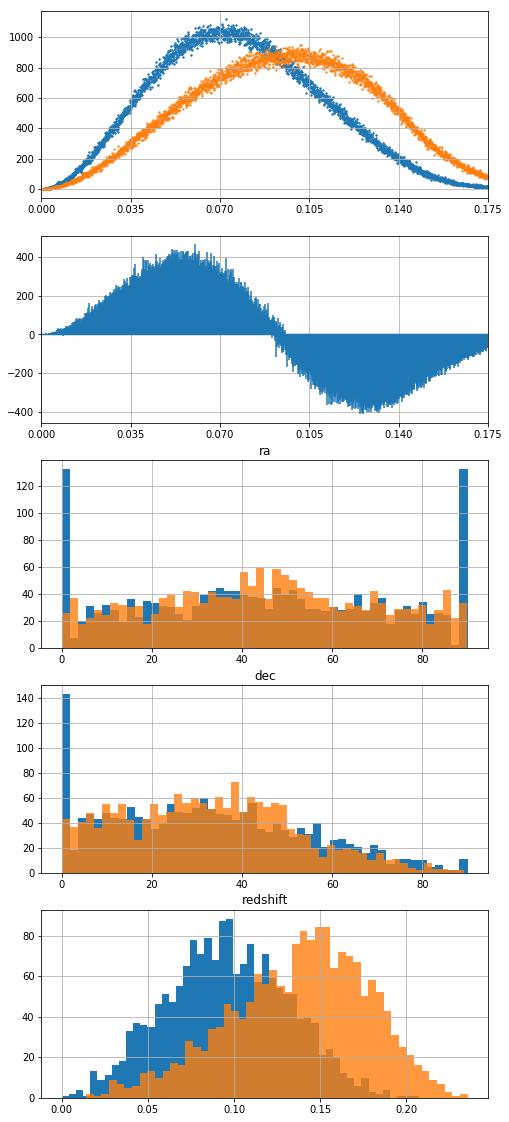

In [0]:
plot_results(cub_struct, 3000, 0.175, mod_mix=5)

In [0]:
min(cub_struct[:, 2]) / 0.035

3.0629190243193575e-05

In [0]:
uniform_distr(cub_struct, in_polar=True)

array([[ 0.11357792,  0.06215384,  0.24247759],
       [ 0.01870737,  0.01229132,  0.05923897],
       [ 0.0086103 ,  0.02576406,  0.06570405],
       ..., 
       [ 0.01953556,  0.01156802,  0.07764621],
       [-0.01038169,  0.00305078,  0.1064924 ],
       [ 0.01049375,  0.00685654,  0.0360866 ]])

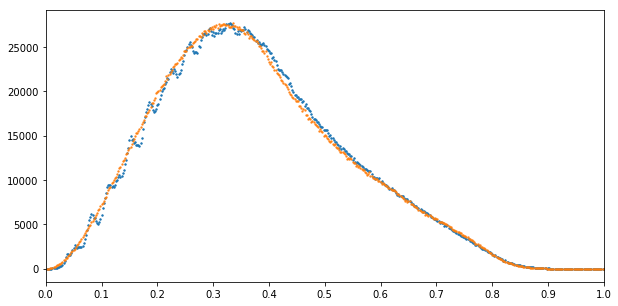

In [0]:
num_bins = 500
right_edge = 1
n1 = get_hist(cub_struct, num_bins, right_edge)           
n2 = get_hist(uniform_distr(cub_struct, in_polar=False), num_bins, right_edge)



fig = plt.figure(figsize=(10, 5))
plt.scatter(n1[1][1:], n1[0], s=2)
plt.scatter(n2[1][1:], n2[0], s=2, alpha=0.8)
plt.xlim([0, right_edge])
plt.xticks(np.linspace(0, right_edge, 11))
plt.show()

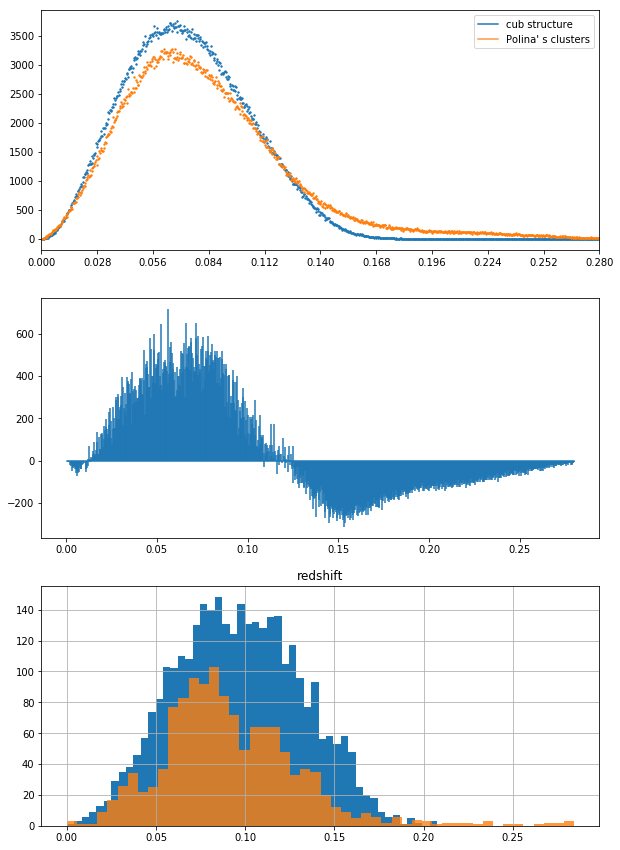

In [0]:
num_bins = 800
right_edge = 0.28
n1 = get_hist(cub_struct_cutted, num_bins, right_edge)  
n3 = get_hist(to_xyz(polina_clusters_left), num_bins, right_edge)  

fig = plt.figure(figsize=(10, 15))
plt.subplot(311)
plt.scatter(n1[1][1:], n1[0], s=2)
plt.scatter(n3[1][1:], n3[0], s=2)
plt.xlim([0, right_edge])
plt.xticks(np.linspace(0, right_edge, 11))

cub = mlines.Line2D([], [], color='C0', label='cub structure')
pol = mlines.Line2D([], [], color='C1', alpha=0.8, label="Polina' s clusters")
plt.legend(handles=[cub, pol])

#plt.show()
plt.subplot(312)
plot_distinguish(n1, n3)


plt.subplot(313)
plt.title('redshift')
plt.hist(to_ra_dec_redshift(cub_struct)[:,2], 50)
plt.hist(polina_clusters_left[:,2], 50, alpha=0.8)
plt.grid(True)
plt.show()

## Работа с кластерами Роберта

In [0]:
threshold_cone_with_cluster = 120
abell_ray = left_abell
area = left_area

list_cones = list()
list_no_clusters = list()
no_cluster_here = 0
for ra_dec in abell_ray:
    ra, dec = ra_dec[0], ra_dec[1]
    cone_with_cluster = (get_cone(area, ra, dec))
    if cone_with_cluster.shape[0] < threshold_cone_with_cluster:
        no_cluster_here += 1
        list_no_clusters.append(ra_dec)
    else:
        list_cones.append(cone_with_cluster)

        
for cone in list_cones:
    plt.hist(cone[:,2], 12, [0, 0.3])
    plt.xticks(np.linspace(0, 0.3, 11))
    plt.show()
    

In [0]:
left_rob, right_rob = left_right_regions(robert_cl)

In [0]:
left_rob = left_rob[left_rob[:,2]>10e-4]

In [0]:
left_rob[left_rob[:,2]<0.3].shape

(9034, 3)

In [0]:
?plot_results

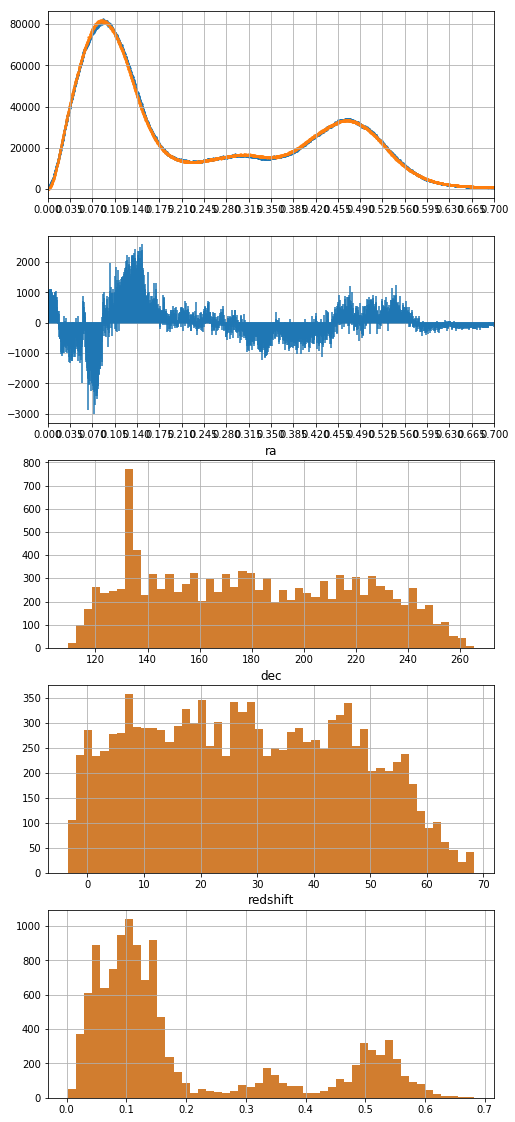

In [0]:
plot_results(to_xyz(left_rob), 3000, 0.7, mod_mix=2)

## Работа с кластерами Полины

In [0]:
polina_clusters = reader('data/Clusters Polina.txt', commos2points=True)
mask_na = np.any(np.isnan(polina_clusters), axis=1)
polina_clusters = polina_clusters[~mask_na]
polina_clusters_left, _ = left_right_regions(polina_clusters)

In [0]:
plot_results(to_xyz(...), 1500, 0.3, mod_mix=4, save=False, name='uniform xyz')

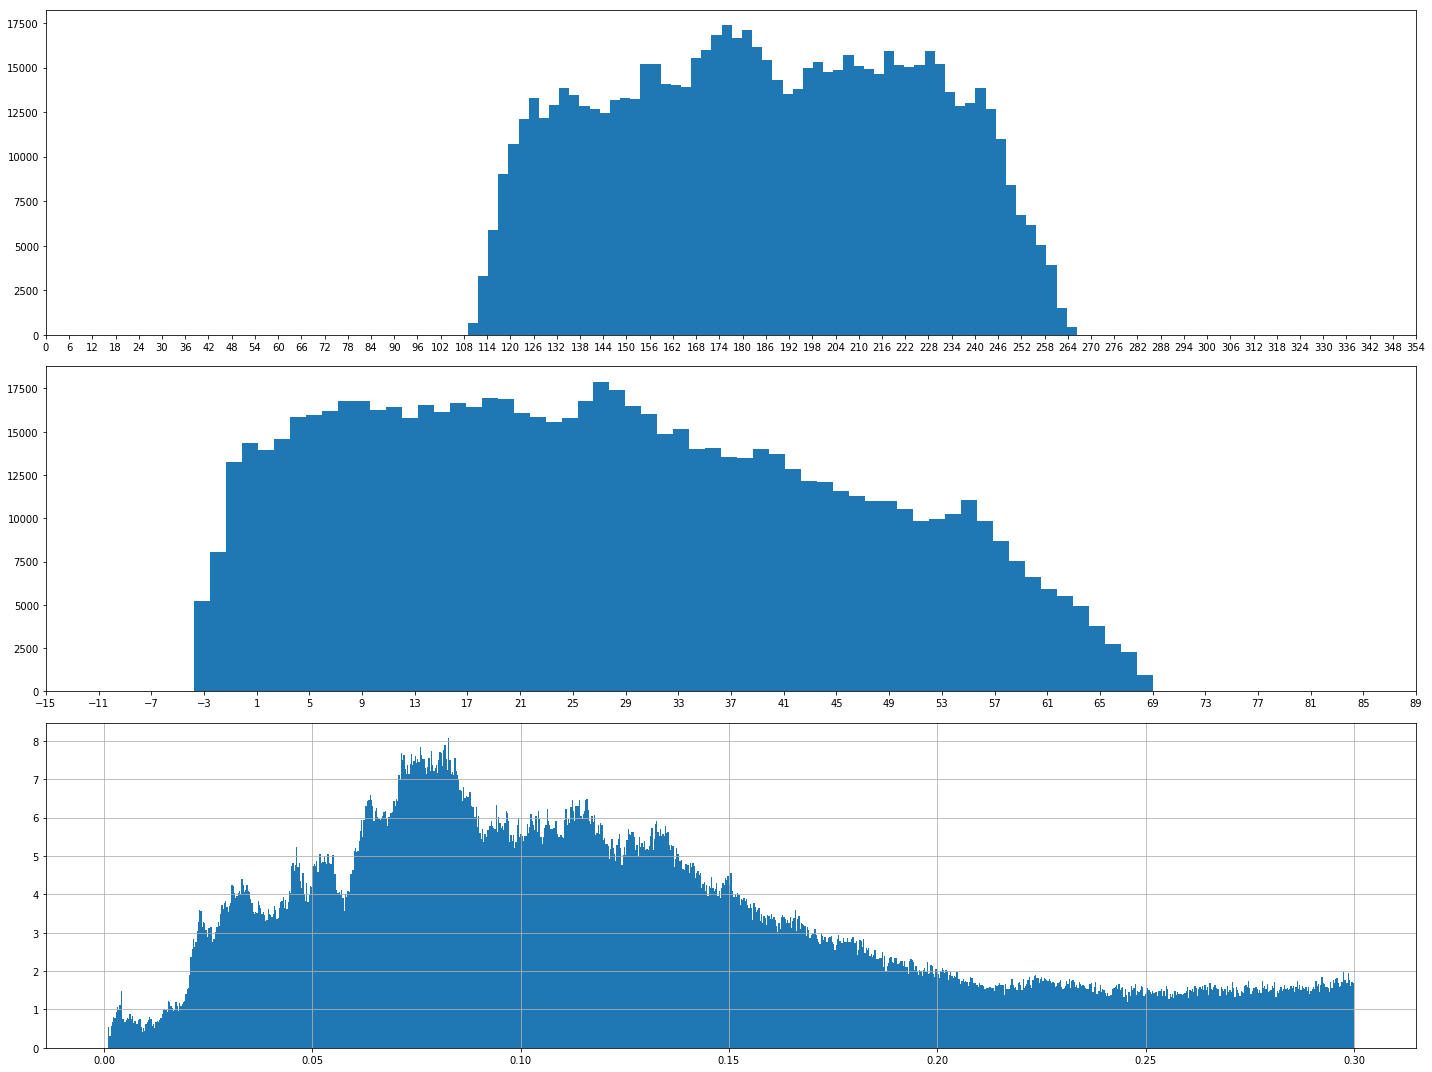

In [0]:
fig = plt.figure(figsize=(20, 15))

data = left_area
ax = plt.subplot(3, 1, 1)
plt.hist(data[:,0], bins=60)
plt.xticks(range(0, 360, 6))

ax = plt.subplot(3, 1, 2)
plt.hist(data[:,1], bins=60)
plt.xticks(range(-15, 90, 4))

ax = plt.subplot(3, 1, 3)
plt.hist(data[:,2], bins=1000, density=True)


#z_distr = distr_red_shift()
x = np.linspace(0, 0.7, 200)
#pdf_fitted = z_distr.pdf(x)
#plt.plot(x, pdf_fitted, color='r')
#plt.hist(z_distr.rvs(size=200000), bins=1000, density=True, alpha=0.8)
#plt.xticks(np.linspace(0, 0.3, 31))
plt.grid(True)
    
plt.tight_layout()

In [0]:
a = distr_red_shift()
a.pdf(0.2)

2.0

In [0]:
left_area[(0.02 < left_area[:,2]) & (left_area[:,2]<0.2)].shape

(620087, 3)

In [0]:
left_area.shape

(751945, 3)

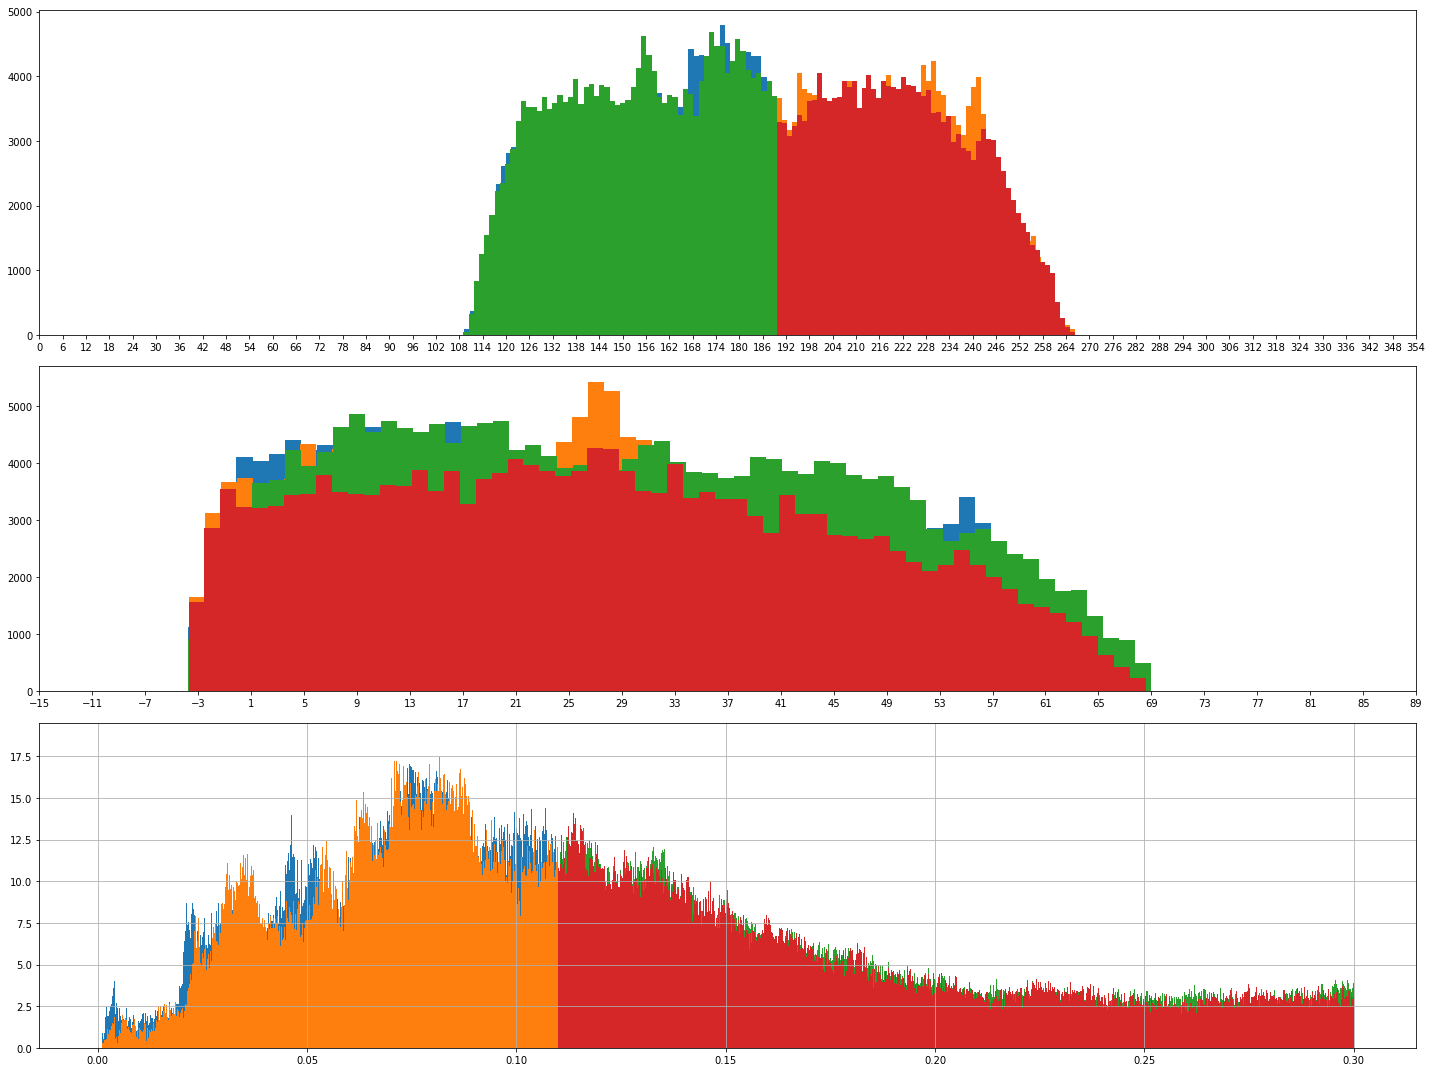

In [0]:
fig = plt.figure(figsize=(20, 15))


data_some = subareas
ax = plt.subplot(3, 1, 1)
for data in data_some:
    plt.hist(data[:,0], bins=60)
plt.xticks(range(0, 360, 6))

ax = plt.subplot(3, 1, 2)
for data in data_some:
    plt.hist(data[:,1], bins=60)
plt.xticks(range(-15, 90, 4))

ax = plt.subplot(3, 1, 3)
for data in data_some:
    plt.hist(data[:,2], bins=1000, density=True)


#z_distr = distr_red_shift()
x = np.linspace(0, 0.7, 200)
#pdf_fitted = z_distr.pdf(x)
#plt.plot(x, pdf_fitted, color='r')
#plt.hist(z_distr.rvs(size=200000), bins=1000, density=True, alpha=0.8)
#plt.xticks(np.linspace(0, 0.3, 31))
plt.grid(True)
    
plt.tight_layout()

In [0]:
def do_scan_reg(points_xyz, eps, n_neighbors,
                c_very_small=20, c_small=50, c_huge=300):
    dbscan_model = DBSCAN(eps=eps, min_samples=n_neighbors+1, metric='euclidean', algorithm='ball_tree')
    res = dbscan_model.fit_predict(points_xyz)
    lab, counts = np.unique(res, return_counts=True)
    
    noize = counts[0]
    counts = counts[1:]
    very_small = counts[counts<c_very_small].shape[0]
    small = counts[counts<c_small].shape[0] - very_small
    good = counts[(counts<c_huge) & (counts>c_small)].shape[0]
    huge = counts[counts>c_huge].shape[0]
    
    print('noize/all = {0:.3f}'.format(noize/points_xyz.shape[0]))
    print('under {0}: {1}'.format(c_very_small, very_small))
    print('under {0}: {1}'.format(c_small, small))
    print('more {0}: {1}'.format(c_huge, huge))      
    print('bigest cluster: {0}'.format(max(counts)))
    print('good clusters: {0}'.format(good))
    return res, lab, counts
    

(455, 3)
max = 1332.073
mediana = 270.73776954646416
for label 0 there are 276 galaxies
for label 2 there are 60 galaxies
for label 4 there are 35 galaxies
noize num :  (24, 3)


<IPython.core.display.Javascript object>


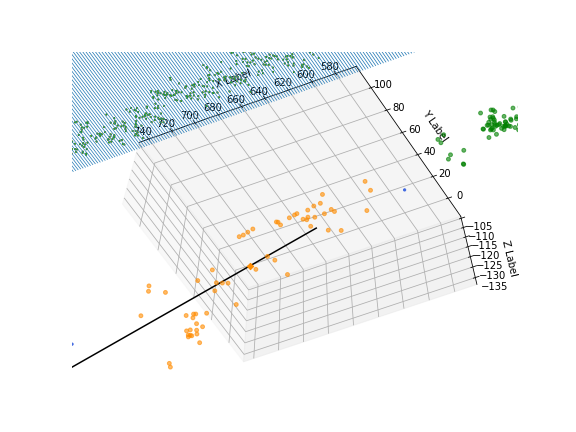

0
1
2


In [0]:
#dir_path = 'data/Abell less 0.3 chosen/'
#name_file = 'Abell_9 less 0.3 chosen.txt'

dir_path = 'data/Abell less 0.3/'
name_file = 'Abell_g_less_0.3 8.txt'

full_path = dir_path + name_file
points_xyz, ray = get_one(full_path)
print(points_xyz.shape)


pair_dist = pairwise_distances(points_xyz)
not_zero_pair = np.triu(pair_dist)
print("max = {0:.3f}".format(np.max(not_zero_pair[not_zero_pair!=0])))

med = np.median(not_zero_pair[not_zero_pair!=0])
print("mediana = {0}".format(med))

clusters, cen_clusters, noize, labels_ = do_scan(points_xyz, n_neighbors=5, eps=med/8, verbose=True)
%matplotlib notebook
fig = plt.figure(figsize=(8,6))
colours = ['royalblue', 'green', 'darkorange', 'purple']
ax = fig.add_subplot(111, projection='3d')

#ax.scatter(0, 0, 0, c='black', s=20)
ax.plot([ray[0]/2, ray[0]], [ray[1]/2, ray[1]], [ray[2]/2, ray[2]], c='black')
for i, cluster in enumerate(clusters):
    print(i)
    if i >= 3:
        break
    ax.scatter(*(cluster.T), c=colours[i+1], s=15, alpha=0.6)
    ax.scatter((*cen_clusters[i]), c=colours[i+1], s=20, marker='D') 
ax.scatter(*(noize.T), c=colours[0], s=5, alpha=1)


ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
#ax.set_zticks([])
#plt.xticks([], [])
#plt.yticks([], [])

plt.axis('equal')
#plt.gca().set_aspect('equal', adjustable='box')
#ax.set_zlim(10, 500)
plt.grid('True')
plt.show()


In [0]:
  '''
    p_d = pairwise_distances(cen_cl)
    args_close = np.argwhere((0. < p_d) & (p_d < 0.002))
    close_pairs_uniq = np.unique(args_close, return_counts=True)
    close_pairs_uniq[0][close_pairs_uniq[1]>2].shape
    for pair in args_close:
        if (cen_cl[pair[0]] != np.zeros((3,))).any:
              cen_cl[pair[0]] =  (cen_cl[pair[0]] + cen_cl[pair[1]])/2
            cen_cl[pair[1]] = np.zeros((3,))
            i+=1
        print(i)
    
    
    '''

In [0]:
def analyze_seria(list_cones, verbose=False):
    '''
    seria of less chosen files
    
    '''
    coef_hugest_cluster = 0.4
    coef_2_clusters = 0.3
    coef_1st_to_2nd = 0.25
    many_galaxies = 500

    all_clusters = list()
    not_big = 0
    two_small = 0
    not_big_70 = 0
    bad_alg = 0
    two_clusters = 0
    bad_cluster = 0 
    
    all_clusters = list()
    
    for cone in list_cones:
        points_xyz = to_xyz(cone)
        num_galaxies = points_xyz.shape[0]
        pair_dist = pairwise_distances(points_xyz)
        not_zero_pair = np.triu(pair_dist)
        med = np.median(not_zero_pair[not_zero_pair!=0])
        
        if num_galaxies > many_galaxies:
            clusters, cen_clusters, noize, labels_ = do_scan(points_xyz, n_neighbors=5, eps=med*0.2)
        else:
            clusters, cen_clusters, noize, labels_ = do_scan(points_xyz, n_neighbors=3, eps=med*0.3)
        
        num_bigest = clusters[0].shape[0]
        if len(clusters) == 1:
            num_second = 0
        else:
            num_second = clusters[1].shape[0]
        
        if num_galaxies > many_galaxies:
            if (num_bigest-num_second)/num_bigest < coef_1st_to_2nd:
                if num_bigest > coef_2_clusters:
                    all_clusters.append(cen_clusters[0])
                    all_clusters.append(cen_clusters[1])
                    two_clusters += 1
                else:
                     two_small += 1
            elif num_bigest/num_galaxies > coef_hugest_cluster:
                all_clusters.append(cen_clusters[0])
        
            else:
                not_big += 1
    
        elif num_bigest/num_galaxies > coef_hugest_cluster:
            all_clusters.append(cen_clusters[0])  
        else:
            not_big_70 += 1
    
    if verbose:
        print(not_big, two_small, two_clusters, not_big_70)
    arr_clusters = np.array(all_clusters)
    return arr_clusters 

def pairwise_dist(points_xyz):
    MAX_MEM = 295000000
    #MAX_MEM = 1
    batch_size = round(MAX_MEM/points_xyz.shape[0]) - 10
    num_batches = (points_xyz.shape[0]+1)//batch_size
    print(points_xyz.shape[0], batch_size, num_batches)
    dataset_avg = 0.
    for i in range(1, num_batches):
        
        batch = points_xyz[(i-1)*batch_size : i*batch_size]
        d_avg = pairwise_distances(batch, points_xyz).mean(axis=1).sum()
        if i % 10==0:
            print(i, d_avg/batch_size)
        dataset_avg += d_avg
    return dataset_avg/points_xyz.shape[0]
     

<IPython.core.display.Javascript object>


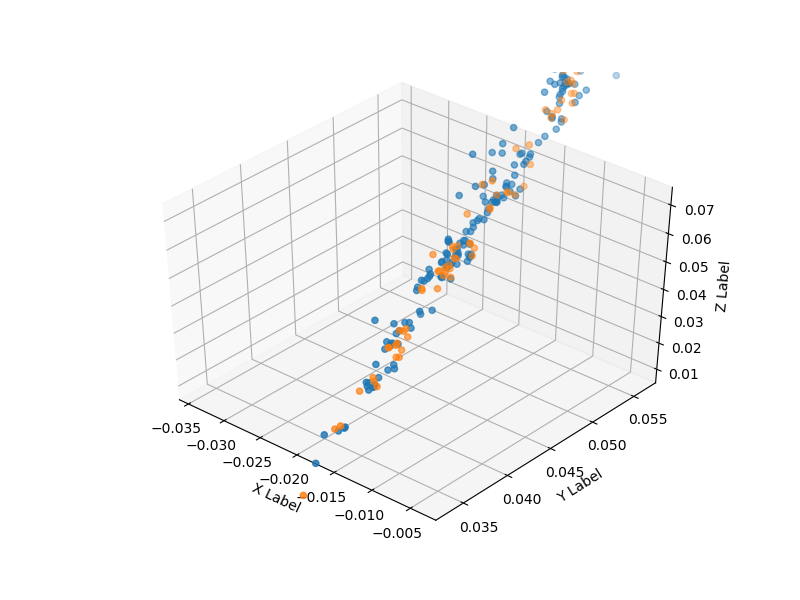

(-0.036809947143851822,
 -0.0011843875667747921,
 0.0032893065994873366,
 0.086339568433905056)

In [0]:
x

In [0]:
import gc
gc.collect()

220